# Module 2 Project

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Project Overview

    1) Establish business questions to explore
    2) Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.
    3) Merge data sets into larger data sets as needed. Clean further until working with robust data.
    4) EDA on data sets including visualizations

# Business Exploration Questions

1. What are the primary factors influencing housing prices in the King County metro area?
2. Can we effectively use a regression model based system for realtors to determine a proper list price?
3. Is a model-based system more accurate for determining list price than the traditional comps-based system?
4. What easy-to-use features can we add to our model to increase its accuracy?

# Notebook Preparation

## Recommended Extensions

Recommended to also install the nbextensions "Table of Contents 2" and "Collapsible Headings" for easier navigation through this notebook.

Gitbhub here: https://github.com/ipython-contrib/jupyter_contrib_nbextensions


Ensure seaborn is updated to recent version

## Importing Modules

In [1]:
import csv

from joblib import dump

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import statsmodels.api as sm
from statsmodels.formula.api import ols
#from statsmodels.formula.api import wls

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

from sklearn.feature_selection import RFECV, RFE

from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn import neighbors
from math import sqrt
import itertools

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Preprocessing

In [2]:
# load and look at our king county housing data
df = pd.read_csv('kc_house_data.csv')
df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0          5650     1.0         NaN   0.0          3      7        1180   
1          7242     2.0         0.0   0.0          3      7        2170   
2         10000     1.0         0.0   0.0          3      6         770   
3          5000     1.0         0.0   0.0          5      7        1050   
4          8080     1.0         0.0   0.0          3      8        1680   
...         ...     ...         ...   ...        ...    ...         ...   
21592      1131     3.0         0.0   0.0          3      8        1530   
21593      5813     2.0         0.0   0.0          3      8        2310   
21594      1350     2.0         0.0   0.0          3      7        1020   
21595      2388     2.0         NaN   0.0          3      8        1600   
21596      1076     2.0         0.0   0.0          3      7        1020   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0               0.0      1955           0.0    98178  47.5112 -122.257   
1             400.0      1951        1991.0    98125  47.7210 -122.319   
2               0.0      1933           NaN    98028  47.7379 -122.233   
3             910.0      1965           0.0    98136  47.5208 -122.393   
4               0.0      1987           0.0    98074  47.6168 -122.045   
...             ...       ...           ...      ...      ...      ...   
21592           0.0      2009           0.0    98103  47.6993 -122.346   
21593           0.0      2014           0.0    98146  47.5107 -122.362   
21594           0.0      2009           0.0    98144  47.5944 -122.299   
21595           0.0      2004           0.0    98027  47.5345 -122.069   
21596           0.0      2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [3]:
# what are the columns in our data?

df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## EDA

### Duplicate Data

In [4]:
df['lat'] = round(df['lat'], 3)
df['long'] = round(df['long'], 3)

In [5]:
df[df.duplicated(subset=['lat','long', 'sqft_living'], keep=False)].sort_values('lat')
# We have 1003 duplicate entries total. We're going to keep the later of these entries and hope that if it's an outlier,
# it's caught in our outlier processing later.

id        date     price  bedrooms  bathrooms  sqft_living  \
4071   6802210090   8/22/2014  252000.0         3       2.25         1570   
9192   6802210450   3/31/2015  272950.0         3       2.25         1570   
20909  8141310040   6/27/2014  246950.0         3       3.00         1670   
20670  8141310030   7/30/2014  256703.0         3       2.00         1670   
8178   7212680850    9/3/2014  258000.0         3       2.50         1730   
...           ...         ...       ...       ...        ...          ...   
12819  9238500040   6/24/2014  400000.0         3       2.50         2970   
16657  9250900104  11/10/2014  300000.0         5       1.75         2110   
16135  8564950280   10/9/2014  533000.0         3       2.50         2810   
10526   253600160   5/30/2014  384950.0         3       2.50         1860   
7525    253600150   8/26/2014  380000.0         2       2.50         1860   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
4071       8410     1.0         0.0   0.0          3      7        1180   
9192       9096     1.0         0.0   0.0          4      7        1180   
20909      4440     1.0         0.0   0.0          3      7        1670   
20670      4441     1.0         0.0   0.0          3      7        1670   
8178       6930     2.0         0.0   0.0          3      8        1730   
...         ...     ...         ...   ...        ...    ...         ...   
12819     23100     1.0         0.0   0.0          3      7        1510   
16657      8500     1.0         0.0   0.0          3      7        1100   
16135      4607     2.0         0.0   0.0          3      8        2810   
10526      3690     2.0         0.0   0.0          3      7        1860   
7525       3504     2.0         0.0   0.0          3      7        1860   

      sqft_basement  yr_built  yr_renovated  zipcode     lat     long  \
4071          390.0      1991           0.0    98022  47.194 -121.990   
9192          390.0      1991           0.0    98022  47.194 -121.990   
20909           0.0      2014           0.0    98022  47.195 -121.975   
20670           0.0      2014           0.0    98022  47.195 -121.975   
8178            0.0      1994           0.0    98003  47.262 -122.308   
...             ...       ...           ...      ...     ...      ...   
12819        1460.0      1967           0.0    98072  47.774 -122.133   
16657        1010.0      1962           0.0    98133  47.774 -122.350   
16135           0.0      2004           0.0    98011  47.774 -122.227   
10526           0.0      2000           0.0    98028  47.776 -122.239   
7525            0.0      2000           0.0    98028  47.776 -122.239   

       sqft_living15  sqft_lot15  
4071            1540        8410  
9192            1570        8418  
20909           1670        4622  
20670           1670        4622  
8178            1780        6930  
...              ...         ...  
12819           2390       20300  
16657           2020        8500  
16135           2540        4871  
10526           1870        4394  
7525            1860        4246  

[1003 rows x 21 columns]

In [6]:
df.drop_duplicates(['lat','long', 'sqft_living'], keep='last', inplace=True)

### Outliers

In [7]:
# looking for outliers in the percentiles

df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.106600e+04  2.106600e+04  21066.000000  21066.000000  21066.000000   
mean   4.575182e+09  5.437305e+05      3.379094      2.116289   2089.317383   
std    2.874098e+09  3.696944e+05      0.926969      0.770347    921.470953   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123787e+09  3.249625e+05      3.000000      1.750000   1430.000000   
50%    3.904920e+09  4.530000e+05      3.000000      2.250000   1930.000000   
75%    7.304301e+09  6.499500e+05      4.000000      2.500000   2560.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.106600e+04  21066.000000  18755.000000  21004.000000  21066.000000   
mean   1.531476e+04      1.486970      0.007785      0.237764      3.415504   
std    4.185045e+04      0.533972      0.087889      0.770986      0.652483   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.100000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.666500e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.078225e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21066.000000  21066.000000  21066.000000  17307.000000  21066.000000   
mean       7.662632   1794.042533   1970.661492     85.344254  98077.867986   
std        1.176826    831.028961     29.311577    403.837560     53.594126   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1200.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1570.000000   1974.000000      0.000000  98065.000000   
75%        8.000000   2220.000000   1996.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

               lat          long  sqft_living15     sqft_lot15  
count  21066.00000  21066.000000   21066.000000   21066.000000  
mean      47.56020   -122.213828    1993.263648   12922.049606  
std        0.13876      0.140540     686.615079   27547.628425  
min       47.15600   -122.519000     399.000000     651.000000  
25%       47.47000   -122.327000    1490.000000    5150.000000  
50%       47.57200   -122.229000    1850.000000    7663.500000  
75%       47.67800   -122.125000    2370.000000   10125.000000  
max       47.77800   -121.315000    6210.000000  871200.000000

We see potential outliers in price, sqft_lot, sqft_living, and bedrooms.

I also see a possible significant outlier in longitude. We will look at what that means visually.

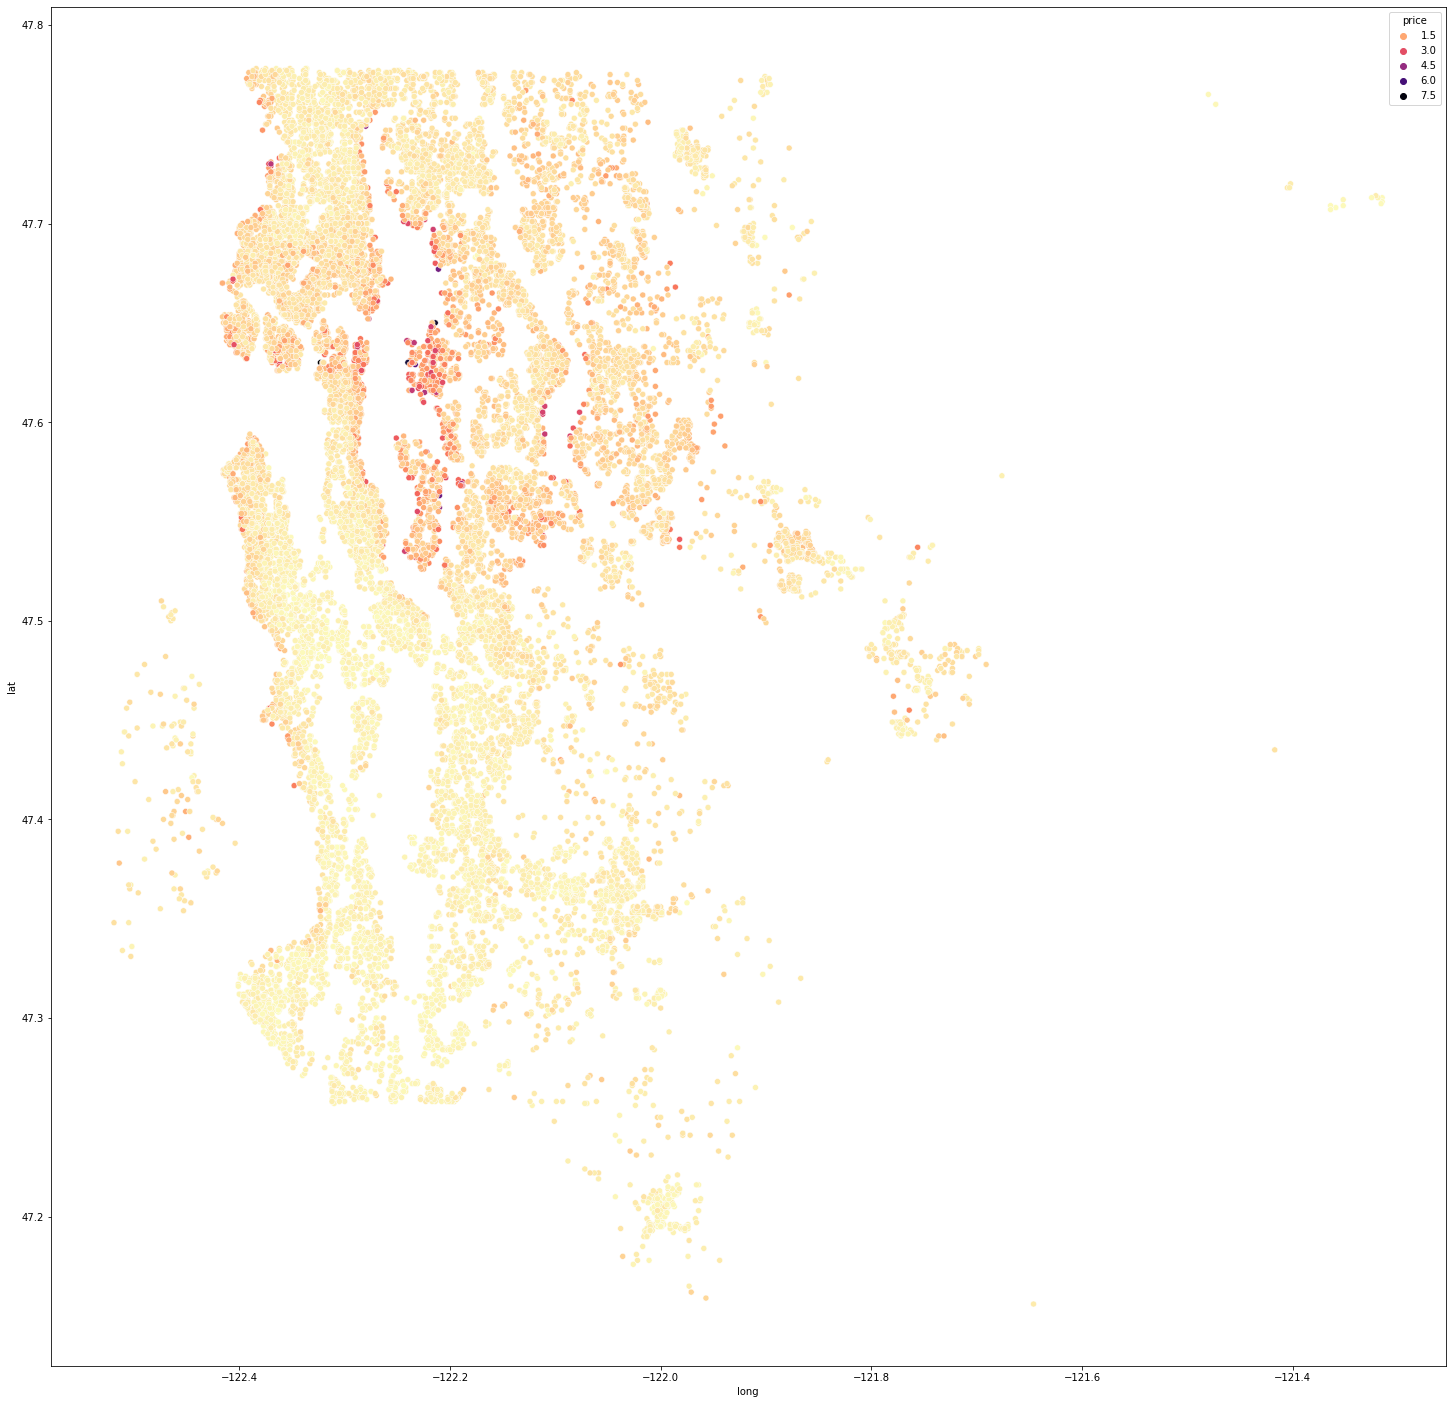

In [8]:
# plotting latitude and longitude as a visual scatter plot

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");

Using latitude and longitude, we make a visual map of the King County area that lets us see the map outliers. We can see that there are a few sales in locations that are outliers in some way - still in King County but very far away from the metro area on which we are focusing. Sales that are too far outside of our comparison area geographically may add noise to our model. So I'm going to drop the longitude outliers as well. 

This visualization suggests that location is very important to home price. We're going to check that out more directly.

In [9]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

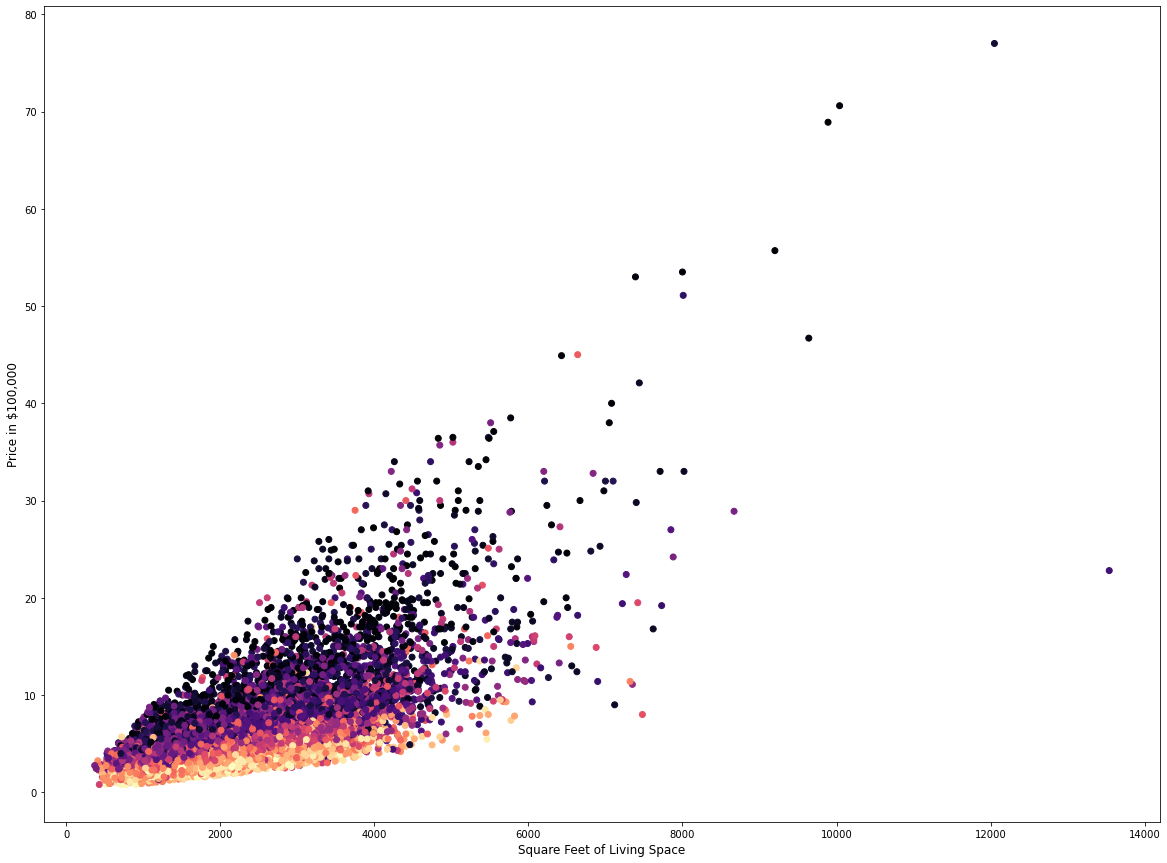

In [10]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12);

This plot show us massive outliers - but it also shows us that Zip Code is VERY relevant to sales price.

One thing this data set lacks is type of sale. We want a model that properly describes the open market, but this dataset likely includes sales that are outside the market, such as inter-family sales or other sales that don't properly reflect market value. The best way I can think of to find these outliers is to find suspiciously low sales based on location, because we can see in the lat/long scatter that location makes a difference.

In [11]:
# visualize our price stats by zip code and displaying top 30 zip codes by mean

find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(30)

# very suspicious values in many zip codes for min

count          mean           std       min        25%        50%  \
zipcode                                                                      
98039     49.0  2.187551e+06  1.163985e+06  787500.0  1410000.0  1910000.0   
98004    313.0  1.358921e+06  7.489828e+05  425000.0   845000.0  1160000.0   
98040    282.0  1.194874e+06  6.077676e+05  500000.0   822000.0   993750.0   
98112    264.0  1.104278e+06  5.965502e+05  169317.0   682250.0   940000.0   
98102     98.0  9.245847e+05  8.073409e+05  330000.0   600000.0   745000.0   
98109    109.0  8.800778e+05  4.557008e+05  216650.0   620000.0   736000.0   
98105    225.0  8.682797e+05  4.805345e+05  380000.0   550000.0   680000.0   
98006    487.0  8.596815e+05  4.465748e+05  247500.0   576250.0   760369.0   
98119    178.0  8.573125e+05  4.386158e+05  300523.0   601250.0   750000.0   
98005    167.0  8.108902e+05  2.696751e+05  400000.0   636850.0   768500.0   
98033    427.0  8.050767e+05  4.649693e+05  130000.0   532500.0   678000.0   
98199    313.0  7.964501e+05  3.990187e+05  323000.0   535000.0   696000.0   
98075    351.0  7.940076e+05  2.874524e+05  406430.0   644000.0   744000.0   
98077    193.0  6.881447e+05  2.638042e+05  250000.0   515000.0   655000.0   
98074    428.0  6.875930e+05  2.695213e+05  280000.0   534375.0   641000.0   
98053    394.0  6.798835e+05  2.660505e+05  170000.0   490287.5   635000.0   
98177    254.0  6.776258e+05  4.368150e+05  245560.0   430000.0   557000.0   
98008    279.0  6.476086e+05  4.244552e+05  250000.0   465375.0   545000.0   
98052    567.0  6.464232e+05  1.974791e+05  270000.0   509625.0   615000.0   
98122    280.0  6.383442e+05  2.884103e+05  202000.0   453000.0   574500.0   
98027    392.0  6.246339e+05  2.952740e+05  130000.0   458675.0   575000.0   
98116    321.0  6.224749e+05  2.535779e+05  130000.0   460000.0   565500.0   
98115    570.0  6.221684e+05  2.370360e+05  200000.0   460000.0   572400.0   
98007    137.0  6.211074e+05  2.005068e+05  295000.0   470000.0   560000.0   
98029    304.0  6.197821e+05  2.166322e+05  285000.0   495000.0   579275.0   
98144    329.0  6.028781e+05  4.070890e+05  181000.0   375000.0   460000.0   
98024     79.0  5.900591e+05  3.774649e+05  200000.0   345000.0   465000.0   
98103    576.0  5.893997e+05  2.113606e+05  238000.0   436082.5   560000.0   
98107    255.0  5.824679e+05  2.362859e+05  290000.0   469500.0   530000.0   
98117    534.0  5.809160e+05  1.875699e+05  125000.0   457000.0   545000.0   

                75%        max  
zipcode                         
98039    2580000.00  6890000.0  
98004    1690000.00  7060000.0  
98040    1387500.00  5300000.0  
98112    1332500.00  3400000.0  
98102     981588.50  7700000.0  
98109    1000000.00  3200000.0  
98105    1020000.00  3650000.0  
98006     975000.00  4210000.0  
98119     940000.00  3070000.0  
98005     912500.00  1960000.0  
98033     904500.00  5110000.0  
98199     951250.00  3200000.0  
98075     870257.50  3200000.0  
98077     835000.00  1920000.0  
98074     795000.00  3080000.0  
98053     793875.00  2280000.0  
98177     744712.50  3800000.0  
98008     661250.00  3570000.0  
98052     751000.00  2200000.0  
98122     729999.25  2050000.0  
98027     726275.00  2700000.0  
98116     710000.00  2050000.0  
98115     720500.00  2300000.0  
98007     732000.00  1320000.0  
98029     690000.00  2200000.0  
98144     675000.00  3600000.0  
98024     705000.00  1860000.0  
98103     700000.00  1700000.0  
98107     630750.00  2950000.0  
98117     660000.00  1370000.0

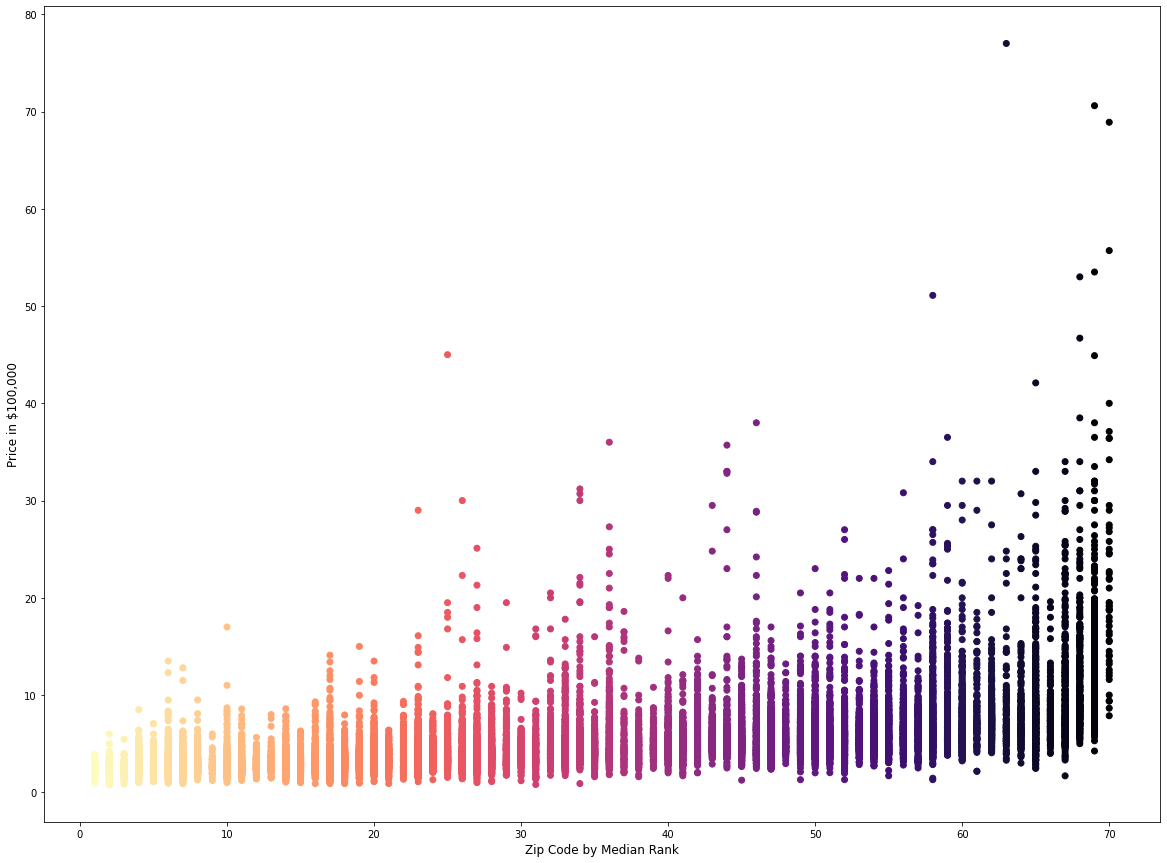

In [12]:
# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['zip_rank'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12);

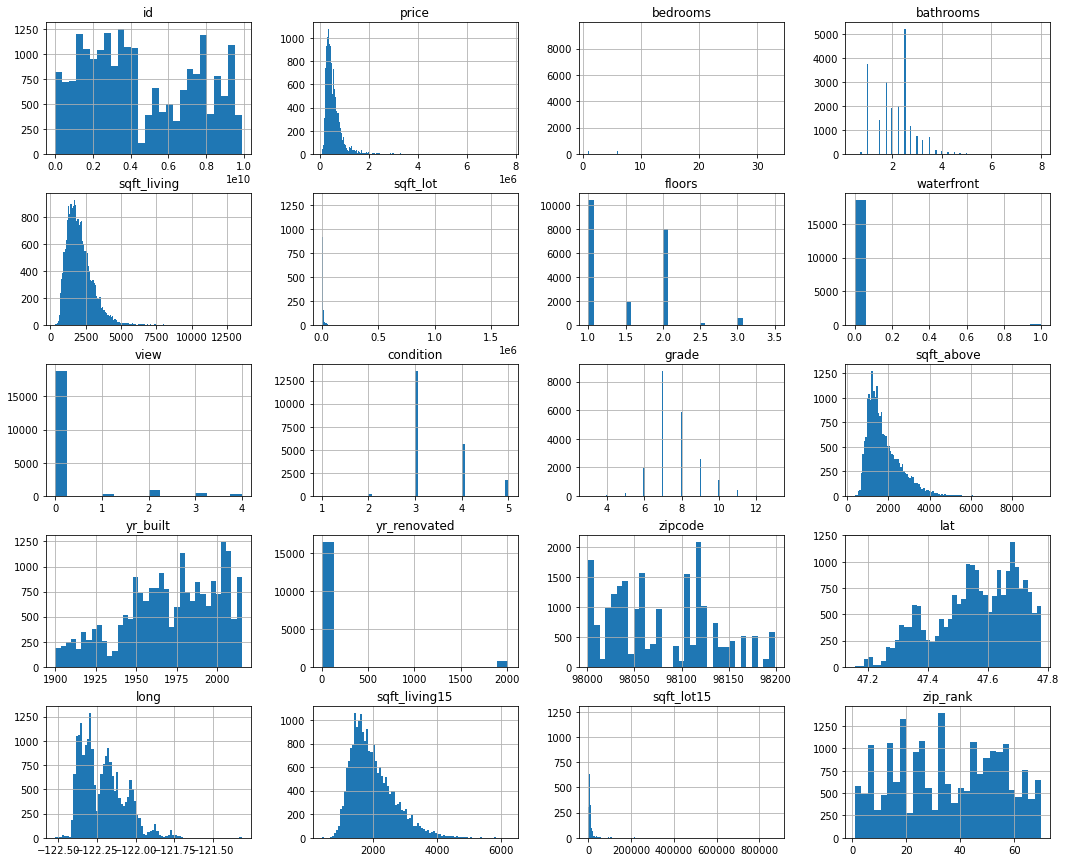

In [13]:
# check how our histograms are looking

df.hist(figsize=(18,15), bins='auto');

#### Outlier Removal

In [14]:
# A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.75"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.5 * iqr)
    upper_range = Q3 + (1.5 * iqr)
    return lower_range,upper_range  

In [15]:
# determing our IQR for price, lot size, sq footage and longitude

lotlower,lotupper = iqr_outliers(df.sqft_lot)
sqftlower, sqftupper = iqr_outliers(df.sqft_living)
longlower, longupper = iqr_outliers(df.long)
#pricelower,priceupper = iqr_outliers(df.price)


# dropping the things outside of our lower and upper range

df.drop(df[ (df.sqft_lot > lotupper) | (df.sqft_lot < lotlower) ].index , inplace=True)
df.drop(df[ (df.sqft_living > sqftupper) | (df.sqft_living < sqftlower) ].index , inplace=True)
df.drop(df[ (df.long > longupper) | (df.long < longlower) ].index , inplace=True)
#df.drop(df[ (df.price > priceupper) | (df.price < pricelower) ].index , inplace=True)


In [16]:
# also removing outlier prices based on IQR on a per-zipcode
'''
zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)
    '''

"\nzipcodes = df['zipcode'].unique()\n\nfor i in zipcodes:\n    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])\n    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)\n    "

In [17]:
# also removing outlier prices based on IQR on a per-zipcode
def std_removal(column):
    """return the lower range and upper range for the data based on 3 standard deviations"""
    data_mean, data_std = mean(column), std(column)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    return lower, upper

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = std_removal(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)

In [18]:
#pricelower,priceupper = iqr_outliers(df.price)
#df.drop(df[ (df.price > priceupper) | (df.price < pricelower) ].index , inplace=True)


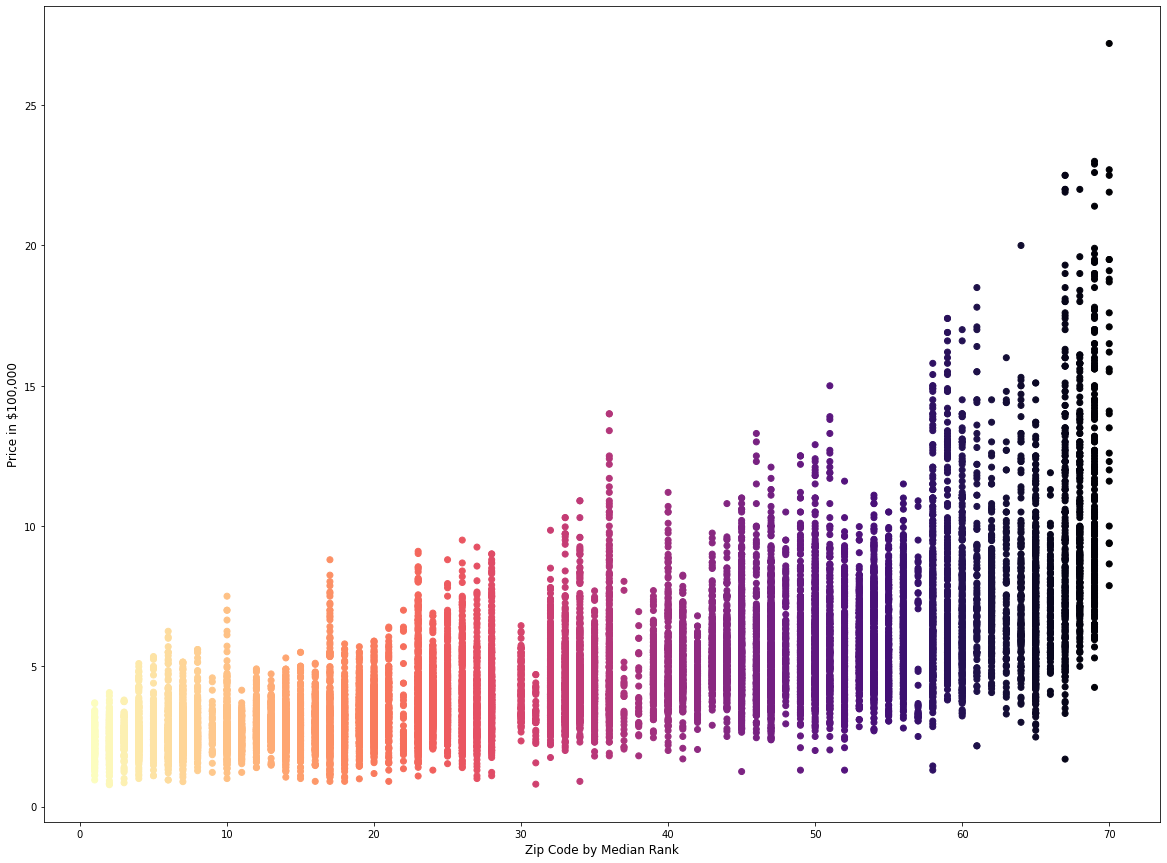

In [19]:
# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['zip_rank'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12);

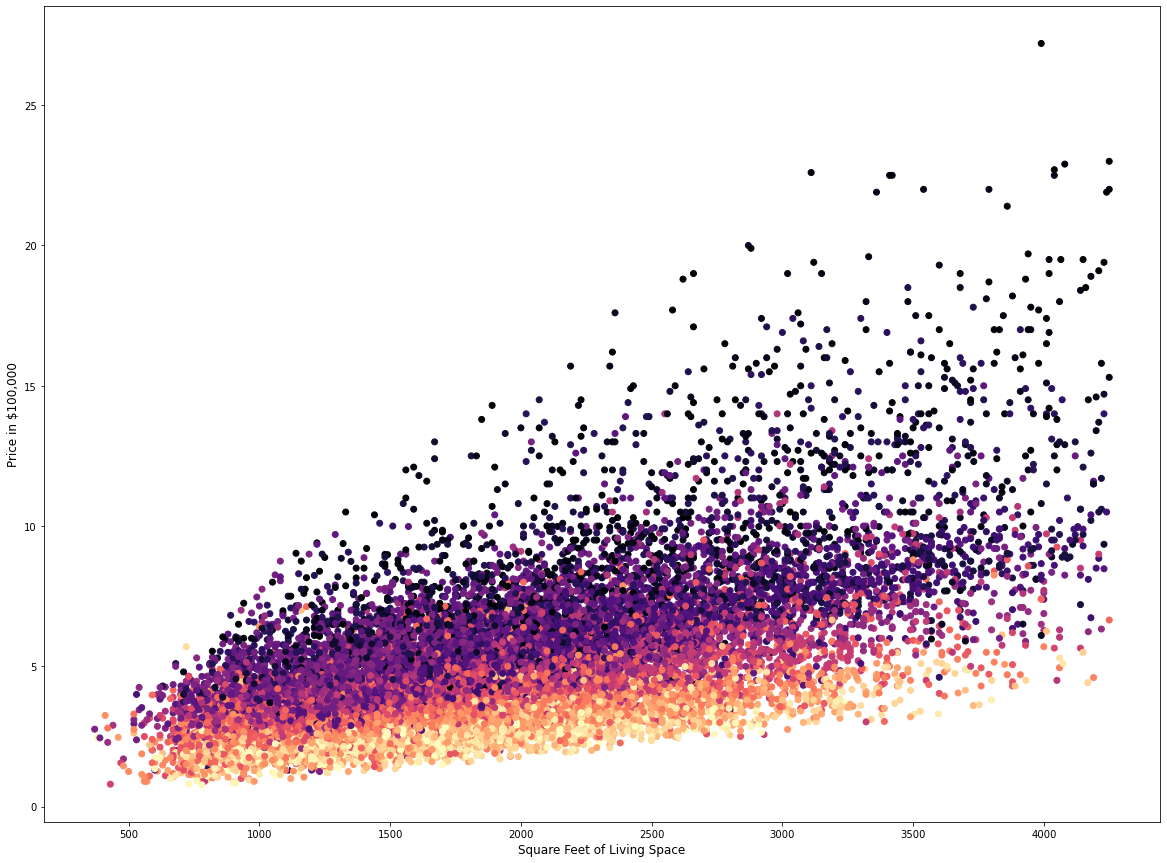

In [20]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12);

In [21]:
# visualize our price stats by zip code and displaying top 30 zip codes by mean

find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(30)

# very suspicious values in many zip codes for min

count          mean            std       min         25%        50%  \
zipcode                                                                        
98039     27.0  1.569630e+06  486971.954503  787500.0  1215000.00  1560000.0   
98004    226.0  1.099533e+06  401580.262663  425000.0   785500.00   977000.0   
98040    217.0  1.004862e+06  308924.597595  500000.0   780000.00   938000.0   
98112    237.0  9.611785e+05  408883.162416  169317.0   650000.00   856000.0   
98109    106.0  8.339479e+05  344169.382823  216650.0   612500.00   730500.0   
98105    215.0  7.968508e+05  331277.869696  380000.0   549997.50   671500.0   
98119    170.0  7.919507e+05  286906.676745  300523.0   596250.00   740000.0   
98102     92.0  7.820576e+05  277829.321446  330000.0   581750.00   710000.0   
98075    249.0  7.574647e+05  165560.382511  406430.0   660000.00   745000.0   
98199    294.0  7.308567e+05  269604.864507  323000.0   529624.75   673750.0   
98006    383.0  7.259521e+05  235518.477602  248000.0   550000.00   710000.0   
98005    117.0  7.143414e+05  152769.882045  400000.0   599380.00   705000.0   
98033    377.0  7.064741e+05  268784.562207  130000.0   510000.00   649800.0   
98074    360.0  6.377584e+05  162159.326086  280000.0   525000.00   626400.0   
98052    509.0  6.187097e+05  157027.641810  270000.0   500000.00   600000.0   
98122    272.0  6.055749e+05  217260.516073  202000.0   449987.50   561625.0   
98115    553.0  5.973526e+05  184357.020898  200000.0   455000.00   564000.0   
98053    230.0  5.898591e+05  172719.043227  305000.0   445500.00   559000.0   
98007    128.0  5.885993e+05  157259.539669  295000.0   464500.00   550000.0   
98116    307.0  5.862685e+05  185267.161349  130000.0   454500.00   555000.0   
98077     43.0  5.839860e+05  259593.177676  250000.0   330000.00   490000.0   
98029    279.0  5.827993e+05  132042.011246  285000.0   487500.00   570000.0   
98027    230.0  5.770984e+05  182020.875708  130000.0   440000.00   574975.0   
98103    566.0  5.746011e+05  180444.121591  238000.0   435000.00   550000.0   
98117    522.0  5.664725e+05  161547.948014  125000.0   456125.00   543500.0   
98107    250.0  5.584772e+05  123836.284017  290000.0   469000.00   529975.0   
98177    212.0  5.562214e+05  200323.614107  245560.0   412250.00   505500.0   
98008    252.0  5.528930e+05  134461.090322  250000.0   458487.50   537000.0   
98144    313.0  5.314597e+05  227260.493456  181000.0   373000.00   450000.0   
98136    249.0  5.290672e+05  180327.587819  200000.0   399000.00   485000.0   

               75%        max  
zipcode                        
98039    1895000.0  2720000.0  
98004    1390000.0  2300000.0  
98040    1200000.0  2200000.0  
98112    1230000.0  2250000.0  
98109     974750.0  1850000.0  
98105     969500.0  1740000.0  
98119     925975.0  2000000.0  
98102     950500.0  1600000.0  
98075     850000.0  1450000.0  
98199     871375.0  1700000.0  
98006     859500.0  1510000.0  
98005     810000.0  1190000.0  
98033     830000.0  1580000.0  
98074     749962.5  1150000.0  
98052     737000.0  1110000.0  
98122     692416.0  1500000.0  
98115     700000.0  1290000.0  
98053     730637.5  1050000.0  
98007     691650.0  1050000.0  
98116     674000.0  1250000.0  
98077     822500.0  1090000.0  
98029     675000.0   998000.0  
98027     693725.0  1160000.0  
98103     690000.0  1210000.0  
98117     650000.0  1100000.0  
98107     624750.0   975000.0  
98177     651375.0  1330000.0  
98008     618500.0  1080000.0  
98144     635000.0  1400000.0  
98136     620000.0  1120000.0

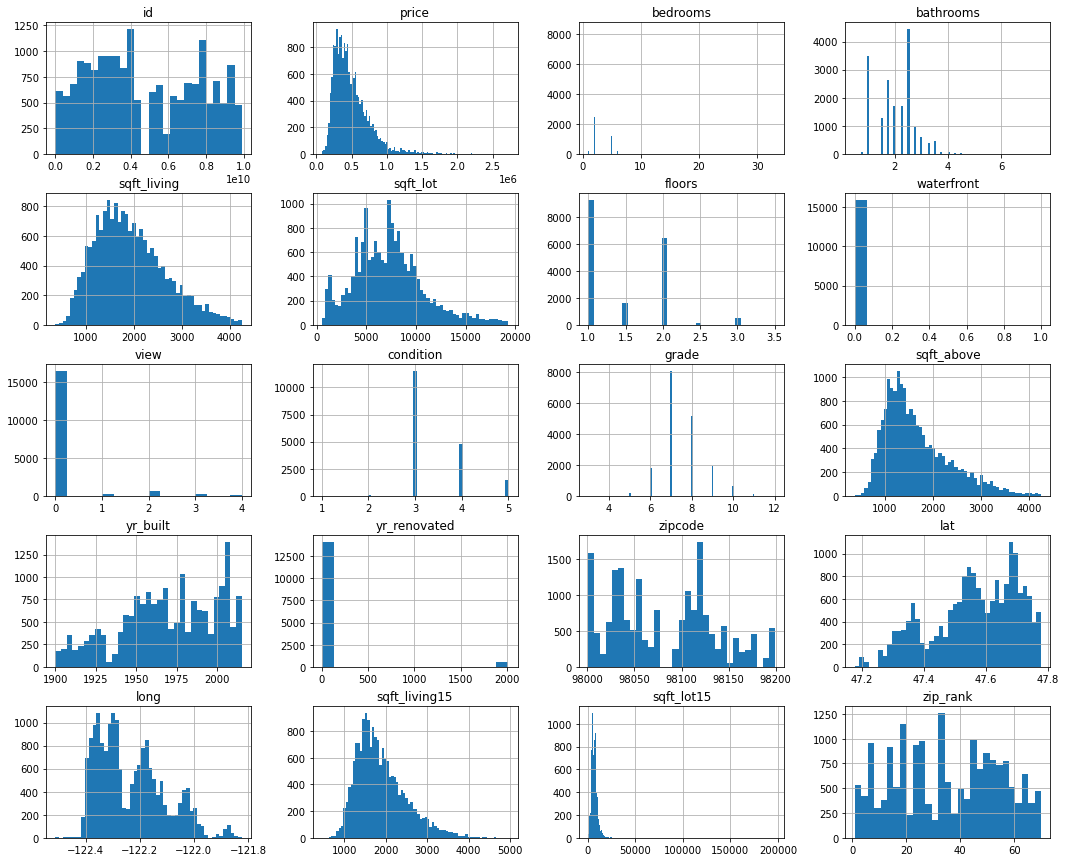

In [22]:
# check how our histograms are looking

df.hist(figsize=(18,15), bins='auto');

Our data is still largely not normally distributed, but using our IQR has gotten rid of some severely skewing outliers in the price, long and sqft_living categories and ESPECIALLY in the sqft_lot category.

In [23]:
# looking again at our percentile outliers

df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  1.795900e+04  1.795900e+04  17959.000000  17959.000000  17959.000000   
mean   4.717196e+09  4.921159e+05      3.331087      2.039604   1935.680884   
std    2.860530e+09  2.544592e+05      0.913004      0.708244    729.831472   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.301401e+09  3.140000e+05      3.000000      1.500000   1390.000000   
50%    4.045501e+09  4.350000e+05      3.000000      2.000000   1830.000000   
75%    7.454000e+09  6.050000e+05      4.000000      2.500000   2390.000000   
max    9.900000e+09  2.720000e+06     33.000000      7.500000   4250.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  17959.000000  17959.000000  15965.000000  17905.000000  17959.000000   
mean    7328.995824      1.470822      0.001441      0.168724      3.422184   
std     3550.858961      0.537450      0.037930      0.628366      0.655279   
min      520.000000      1.000000      0.000000      0.000000      1.000000   
25%     4906.000000      1.000000      0.000000      0.000000      3.000000   
50%     7200.000000      1.000000      0.000000      0.000000      3.000000   
75%     9290.500000      2.000000      0.000000      0.000000      4.000000   
max    19290.000000      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  17959.000000  17959.000000  17959.000000  14730.000000  17959.000000   
mean       7.505874   1663.334428   1969.378418     77.390631  98081.428921   
std        1.008791    684.657941     29.953428    385.404136     54.217794   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1160.000000   1950.000000      0.000000  98033.000000   
50%        7.000000   1490.000000   1970.000000      0.000000  98074.000000   
75%        8.000000   2040.000000   1996.000000      0.000000  98118.000000   
max       12.000000   4250.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15      zip_rank  
count  17959.000000  17959.000000   17959.000000   17959.000000  17959.000000  
mean      47.562883   -122.232570    1889.436104    7337.029734     35.056072  
std        0.137281      0.124101     594.539797    4371.452749     19.163171  
min       47.178000   -122.512000     460.000000     651.000000      1.000000  
25%       47.480000   -122.336000    1460.000000    5000.000000     19.000000  
50%       47.575000   -122.267000    1770.000000    7212.000000     34.000000  
75%       47.680000   -122.155000    2220.000000    9000.000000     51.000000  
max       47.778000   -121.823000    4950.000000  196591.000000     70.000000

In [24]:
#check what is going on with the sqft_lot15 outliers by sorting descending

df.sort_values('sqft_lot15', ascending=False)

id        date     price  bedrooms  bathrooms  sqft_living  \
9436   3523029077   10/7/2014  297000.0         3       1.00         1340   
4607   3523029059   7/31/2014  181000.0         2       1.50         1560   
8112   1923039089   6/10/2014  285000.0         2       2.00         1651   
7086   8656800020   2/12/2015  309000.0         3       2.50         1450   
13153  1523069197    5/3/2014  379880.0         3       2.50         1650   
...           ...         ...       ...       ...        ...          ...   
21520  8562780180   6/12/2014  336750.0         2       2.25         1170   
20891  8562780540  12/22/2014  325000.0         2       2.25         1150   
513    2827100070   11/5/2014  290000.0         4       1.00         1330   
20733  2827100075   7/27/2014  286308.0         2       1.50         1220   
19653  7899800863   10/1/2014  299900.0         3       2.50         1210   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
9436      18000     1.0         0.0   0.0          4      7        1340   
4607      10807     1.0         0.0   0.0          2      7        1560   
8112      18200     1.0         0.0   0.0          3      6        1651   
7086      11480     2.0         NaN   0.0          3      7        1450   
13153     14054     1.0         0.0   0.0          4      7        1130   
...         ...     ...         ...   ...        ...    ...         ...   
21520      1011     2.0         0.0   0.0          3      7        1170   
20891       711     2.0         0.0   0.0          3      7        1150   
513        8184     1.5         0.0   0.0          3      7        1330   
20733      1036     3.0         0.0   0.0          3      7        1220   
19653      2046     2.0         0.0   0.0          3      9         920   

      sqft_basement  yr_built  yr_renovated  zipcode     lat     long  \
9436            0.0      1924           NaN    98070  47.444 -122.509   
4607            0.0      1949           0.0    98070  47.444 -122.509   
8112            0.0      1946           0.0    98070  47.462 -122.461   
7086            0.0      1990           0.0    98014  47.672 -121.864   
13153         520.0      1986           0.0    98027  47.482 -122.017   
...             ...       ...           ...      ...     ...      ...   
21520           0.0      2009           0.0    98027  47.532 -122.073   
20891           0.0      2013           NaN    98027  47.532 -122.070   
513             0.0      1949           0.0    98133  47.734 -122.347   
20733           0.0      2006           0.0    98133  47.735 -122.347   
19653         290.0      2008           NaN    98106  47.521 -122.357   

       sqft_living15  sqft_lot15  zip_rank  
9436            1660      196591        38  
4607            1660      196591        38  
8112            1510       89595        38  
7086            2080       87991        31  
13153           1940       87555        52  
...              ...         ...       ...  
21520           1240         750        52  
20891           1150         748        52  
513             1220         660        24  
20733           1210         659        24  
19653           1070         651        18  

[17959 rows x 22 columns]

In [25]:
# there is something off about these two large and nearly identical entries at the top of the list. We are going to drop these two rows.

df.drop(df[df['sqft_lot15'] == 196591].index, axis=0, inplace = True)

In [26]:
#check what is going on with the weird bedroom value by sorting descending

df.sort_values('bedrooms', ascending=False)

id        date      price  bedrooms  bathrooms  sqft_living  \
15856  2402100895   6/25/2014   640000.0        33       1.75         1620   
8748   1773100755   8/21/2014   520000.0        11       3.00         3000   
15147  5566100170  10/29/2014   650000.0        10       2.00         3610   
19239  8812401450  12/29/2014   660000.0        10       3.00         2920   
6073   9822700190    8/8/2014  1280000.0         9       4.50         3650   
...           ...         ...        ...       ...        ...          ...   
19402  3163600076   7/30/2014   152275.0         1       1.00         1020   
8591   2461900845    9/3/2014   310000.0         1       1.00          570   
4142    461002551   10/4/2014   330600.0         1       1.00          580   
16367  6329000050   3/10/2015   641500.0         1       1.00         1000   
8158   1797500530    5/5/2015   655100.0         1       1.00         1220   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
15856      6000     1.0         0.0   0.0          5      7        1040   
8748       4960     2.0         0.0   0.0          3      7        2400   
15147     11914     2.0         0.0   0.0          4      7        3010   
19239      3745     2.0         0.0   0.0          4      7        1860   
6073       5000     2.0         0.0   0.0          3      8        2530   
...         ...     ...         ...   ...        ...    ...         ...   
19402      6871     1.0         0.0   0.0          3      6        1020   
8591       6000     1.0         0.0   0.0          2      5         570   
4142       1799     1.0         0.0   0.0          3      7         580   
16367      9084     1.0         NaN   3.0          3      7        1000   
8158       4160     1.0         0.0   0.0          3      7        1220   

      sqft_basement  yr_built  yr_renovated  zipcode     lat     long  \
15856         580.0      1947           0.0    98103  47.688 -122.331   
8748          600.0      1918        1999.0    98106  47.556 -122.363   
15147         600.0      1958           0.0    98006  47.570 -122.175   
19239        1060.0      1913           0.0    98105  47.664 -122.320   
6073         1120.0      1915        2010.0    98105  47.660 -122.289   
...             ...       ...           ...      ...     ...      ...   
19402           0.0      1937           NaN    98146  47.505 -122.338   
8591            0.0      1918           0.0    98136  47.552 -122.385   
4142            0.0      1908        2005.0    98117  47.683 -122.375   
16367           0.0      1950           0.0    98146  47.501 -122.382   
8158            0.0      1922           NaN    98115  47.675 -122.315   

       sqft_living15  sqft_lot15  zip_rank  
15856           1330        4700        47  
8748            1420        4960        18  
15147           2040       11914        65  
19239           1810        3745        59  
6073            2510        5000        59  
...              ...         ...       ...  
19402           1260        6933        17  
8591            1530        6000        40  
4142            1260        4000        45  
16367           1090        6536        17  
8158            1970        4200        50  

[17957 rows x 22 columns]

In [27]:
# this value of 33 in 1620 square feet is obviously a mistake. We're going to impute the mean into this field.

# 11 bedrooms in 3000sf, 10 bedrooms in 2920sf, 10 bedrooms in 3610sf are also obviously mistakes
# We're going to impute the mean into the fields for 10 and 11 bedrooms as well.

bedroom_mean = round(df['bedrooms'].mean(), 0)
bedroom_mean
df.loc[df['bedrooms'] == 33.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 11.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 10.0, 'bedrooms'] = bedroom_mean

df.sort_values('bedrooms', ascending=False)

# fixed our bedroom outliers by imputing the mean
# I remain suspicious of these 9-bedroom entries, but we'll decline from manipulating them further

id        date      price  bedrooms  bathrooms  sqft_living  \
4231   2902200015    1/6/2015   700000.0         9       3.00         3680   
4092   1997200215    5/7/2014   599999.0         9       4.50         3830   
6073   9822700190    8/8/2014  1280000.0         9       4.50         3650   
8537    424049043   8/11/2014   450000.0         9       7.50         4050   
18428  8823901445   3/13/2015   934000.0         9       3.00         2820   
...           ...         ...        ...       ...        ...          ...   
264    2123039032  10/27/2014   369900.0         1       0.75          760   
5163   1720800305  11/19/2014   611900.0         1       2.25         1220   
10779  9269200520  10/16/2014   310000.0         1       1.00          670   
5577    537000130    9/8/2014   360000.0         1       2.25         2060   
11364  5694501195   5/11/2015   438600.0         1       1.00          720   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
4231       4400     2.0         0.0   0.0          3      7        2830   
4092       6988     2.5         0.0   0.0          3      7        2450   
6073       5000     2.0         0.0   0.0          3      8        2530   
8537       6504     2.0         0.0   0.0          3      7        4050   
18428      4480     2.0         0.0   0.0          3      7        1880   
...         ...     ...         ...   ...        ...    ...         ...   
264       10079     1.0         1.0   4.0          5      5         760   
5163       2100     2.0         0.0   2.0          4      8        1220   
10779      4920     1.0         0.0   0.0          3      5         670   
5577      10600     1.5         NaN   0.0          3      7        1560   
11364      2500     1.0         0.0   0.0          3      7         720   

      sqft_basement  yr_built  yr_renovated  zipcode     lat     long  \
4231          850.0      1908           0.0    98102  47.637 -122.324   
4092         1380.0      1938           0.0    98103  47.693 -122.338   
6073         1120.0      1915        2010.0    98105  47.660 -122.289   
8537            0.0      1996           0.0    98144  47.592 -122.301   
18428         940.0      1918           0.0    98105  47.665 -122.307   
...             ...       ...           ...      ...     ...      ...   
264             0.0      1936           0.0    98070  47.468 -122.438   
5163            0.0      1946        1979.0    98033  47.670 -122.204   
10779           0.0      1920           NaN    98126  47.534 -122.373   
5577          500.0      1927        1983.0    98003  47.329 -122.304   
11364           0.0      1910           0.0    98103  47.660 -122.345   

       sqft_living15  sqft_lot15  zip_rank  
4231            1960        2450        63  
4092            1460        6291        47  
6073            2510        5000        59  
8537            1448        3866        36  
18428           2460        4400        59  
...              ...         ...       ...  
264             1230       14267        38  
5163            3150        6000        58  
10779           1050        4920        28  
5577            2060       11880         8  
11364           1520        3750        47  

[17957 rows x 22 columns]

### Missing Data

In [28]:
# look for nulls

df.isna().sum()

# all of our null values are in columns that I want to be binary flags. So, will change all non-null values > 0 in those
# columns to 1, and all null values to 0.
# this will turn waterfront, view and renovated into dichotomous choice flags

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1994
view               54
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3228
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
zip_rank            0
dtype: int64

In [29]:
# change all non-null values > 0 in those columns to 1

df.loc[df['waterfront'] > 0, 'waterfront'] = 1
df.loc[df['view'] > 0, 'view'] = 1
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

# now anything that is not a 1 becomes a 0

df.loc[df['waterfront']!= 1, 'waterfront'] = 0
df.loc[df['view'] != 1, 'view'] = 0
df.loc[df['yr_renovated'] != 1, 'yr_renovated'] = 0

# since we're making it a binary flag, we'll rename yr_renovated to renovated
df = df.rename(columns={'yr_renovated' : 'renovated'})

In [30]:
# we've removed the null values from our three binary columns

df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
renovated        0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
zip_rank         0
dtype: int64

In [31]:
# check data types

df.dtypes

# date and sqft_basement need to be fixed. This explains why the basement variable didn't show
# up in our histogram

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
renovated        float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
zip_rank           int64
dtype: object

In [32]:
#Checking all top occuring for each column to find weird entries

for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(), '\n\n')

id 
 1777500160    0.000056
2310100240    0.000056
9510860060    0.000056
8079050010    0.000056
1311200460    0.000056
Name: id, dtype: float64 


date 
 6/23/2014    0.006460
6/25/2014    0.006181
4/14/2015    0.006070
4/28/2015    0.006070
3/25/2015    0.005903
Name: date, dtype: float64 


price 
 350000.0    0.008186
450000.0    0.008019
325000.0    0.007574
425000.0    0.007462
550000.0    0.007351
Name: price, dtype: float64 


bedrooms 
 3    0.464610
4    0.310742
2    0.136771
5    0.066325
6    0.010414
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248315
1.00    0.194297
1.75    0.147463
2.00    0.095116
2.25    0.094615
Name: bathrooms, dtype: float64 


sqft_living 
 1400    0.006961
1440    0.006850
1660    0.006738
1300    0.006683
1010    0.006404
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.019213
6000    0.015426
4000    0.013644
7200    0.011695
4800    0.006348
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.515843
2.0    0.359637
1.5    

In [33]:
# basement has a weird entry of '?' which we will convert to a 0, and then
# converting our sqft_basement to a float,
# and our date to a proper date

df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = 0
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['date'] = pd.to_datetime(df['date'])

# we're now going to extract just the month from our datetime, and store that in a new column
# we won't be using our entire date - we're interested in the month that houses are sold
df['month_sold'] = pd.DatetimeIndex(df['date']).month

In [34]:
# data types are now fixed

df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
renovated               float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
zip_rank                  int64
month_sold                int64
dtype: object

In [35]:
# now that its data type is correct, we see that most properties don't have basements. Because of this,
# we will add basement to our binary flag group, and just list if it has a basement or not.

df.loc[df['sqft_basement'] > 0, 'sqft_basement'] = 1
df.loc[df['sqft_basement'] != 1, 'sqft_basement'] = 0

# we'll also change the name of our column to basement
df = df.rename(columns={'sqft_basement' : 'basement'})

In [36]:
# We're trying out engineering a feature that penalizes or rewards being the smallest or biggest
# property in the neighborhood, as generally you don't want to be either. This is attempting 
# to impose a categorical relationship on how the property relates to its neighbors

df['comparative_sf'] = 0
df.loc[df['sqft_living'] <= (df['sqft_living15']*.75), 'comparative_sf'] = '1'
df.loc[(df['sqft_living'] > (df['sqft_living15']*.75)) & (df['sqft_living'] < (df['sqft_living15']*1.25)), 'comparative_sf'] = '2'
df.loc[df['sqft_living'] >= (df['sqft_living15']*1.25), 'comparative_sf'] = '3'

### Scale Target to consistent time scale

Our last action is to bring all of our home sale prices to the same time scale. It's easy to ignore that these homes were sold over the space of a year, but a year is a long time for real estate. King County median prices increased 9.05% from May 2014 to May 2015, and we need to account for this kind of change in our model. We'll do this by appreciating all sale prices into May 2015 using an appreciation rate over the year of 9.05%, and dividing into months (more granularity is possible of course)

In [37]:
df.loc[(df['date']>'2014-05-01') & (df['date']<'2014-06-01'), 'time_series'] = 12
df.loc[(df['date']>='2014-06-01') & (df['date']<'2014-07-01'), 'time_series'] = 11
df.loc[(df['date']>='2014-07-01') & (df['date']<'2014-08-01'), 'time_series'] = 10
df.loc[(df['date']>='2014-08-01') & (df['date']<'2014-09-01'), 'time_series'] = 9
df.loc[(df['date']>='2014-09-01') & (df['date']<'2014-10-01'), 'time_series'] = 8
df.loc[(df['date']>='2014-10-01') & (df['date']<'2014-11-01'), 'time_series'] = 7
df.loc[(df['date']>='2014-11-01') & (df['date']<'2014-12-01'), 'time_series'] = 6
df.loc[(df['date']>='2014-12-01') & (df['date']<'2015-01-01'), 'time_series'] = 5
df.loc[(df['date']>='2015-01-01') & (df['date']<'2015-02-01'), 'time_series'] = 4
df.loc[(df['date']>='2015-02-01') & (df['date']<'2015-03-01'), 'time_series'] = 3
df.loc[(df['date']>='2015-03-01') & (df['date']<'2015-04-01'), 'time_series'] = 2
df.loc[(df['date']>='2015-04-01') & (df['date']<'2015-05-01'), 'time_series'] = 1
df.loc[(df['date']>='2015-05-01') & (df['date']<'2015-06-01'), 'time_series'] = 0

# adjusting up our sale prices to account for appreciation
monthly_appreciation = .0905/12
df['adj_price'] = round(df['price']*(1+((monthly_appreciation/12)*df['time_series'])), 0)

In [38]:
df.drop('price', axis=1, inplace=True)

# we're renaming our adjusted price column to be price
df.rename(columns={"adj_price": "price"}, inplace=True)
df

id       date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520 2014-10-13         3       1.00         1180      5650   
1      6414100192 2014-12-09         3       2.25         2570      7242   
2      5631500400 2015-02-25         2       1.00          770     10000   
3      2487200875 2014-12-09         4       3.00         1960      5000   
4      1954400510 2015-02-18         3       2.00         1680      8080   
...           ...        ...       ...        ...          ...       ...   
21591  2997800021 2015-02-19         3       2.50         1310      1294   
21592   263000018 2014-05-21         3       2.50         1530      1131   
21593  6600060120 2015-02-23         4       2.50         2310      5813   
21595   291310100 2015-01-16         3       2.50         1600      2388   
21596  1523300157 2014-10-15         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_above  basement  \
0         1.0         0.0   0.0          3      7        1180       0.0   
1         2.0         0.0   0.0          3      7        2170       1.0   
2         1.0         0.0   0.0          3      6         770       0.0   
3         1.0         0.0   0.0          5      7        1050       1.0   
4         1.0         0.0   0.0          3      8        1680       0.0   
...       ...         ...   ...        ...    ...         ...       ...   
21591     2.0         0.0   0.0          3      8        1180       1.0   
21592     3.0         0.0   0.0          3      8        1530       0.0   
21593     2.0         0.0   0.0          3      8        2310       0.0   
21595     2.0         0.0   0.0          3      8        1600       0.0   
21596     2.0         0.0   0.0          3      7        1020       0.0   

       yr_built  renovated  zipcode     lat     long  sqft_living15  \
0          1955        0.0    98178  47.511 -122.257           1340   
1          1951        1.0    98125  47.721 -122.319           1690   
2          1933        0.0    98028  47.738 -122.233           2720   
3          1965        0.0    98136  47.521 -122.393           1360   
4          1987        0.0    98074  47.617 -122.045           1800   
...         ...        ...      ...     ...      ...            ...   
21591      2008        0.0    98116  47.577 -122.409           1330   
21592      2009        0.0    98103  47.699 -122.346           1530   
21593      2014        0.0    98146  47.511 -122.362           1830   
21595      2004        0.0    98027  47.534 -122.069           1410   
21596      2008        0.0    98144  47.594 -122.299           1020   

       sqft_lot15  zip_rank  month_sold comparative_sf  time_series     price  
0            5650        10          10              2          7.0  222876.0  
1            7639        32          12              3          5.0  539691.0  
2            8062        35           2              1          3.0  180339.0  
3            5000        40          12              3          5.0  605898.0  
4            7503        56           2              2          3.0  510962.0  
...           ...       ...         ...            ...          ...       ...  
21591        1265        49           2              2          3.0  475896.0  
21592        1509        47           5              2         12.0  362715.0  
21593        7200        17           2              3          3.0  400754.0  
21595        1287        52           1              2          4.0  401006.0  
21596        1357        36          10              2          7.0  326430.0  

[17957 rows x 25 columns]

In [39]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

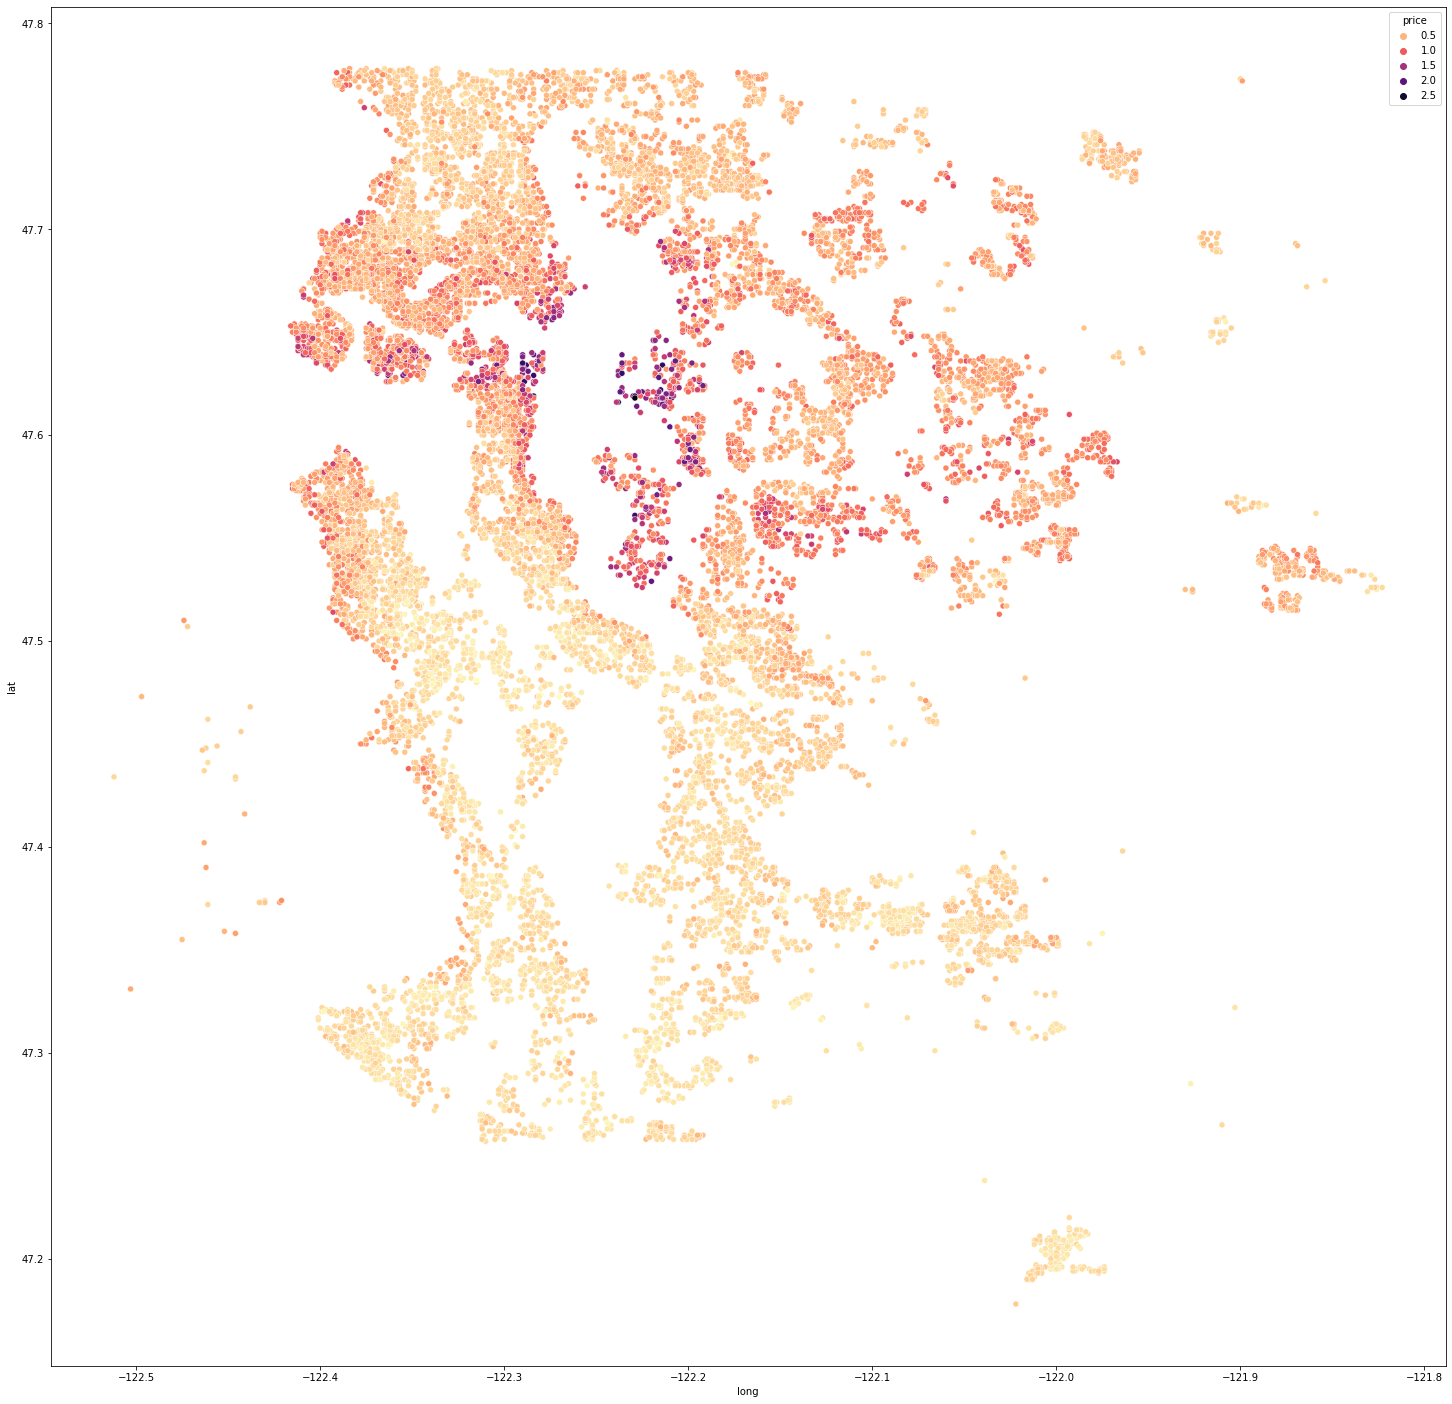

In [40]:
# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates
# the removal of extreme price outliers.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");

Here's a fun way to see the improvements to our data quality after we clean outliers!

### Study Target Variable

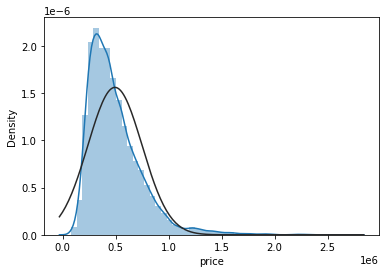

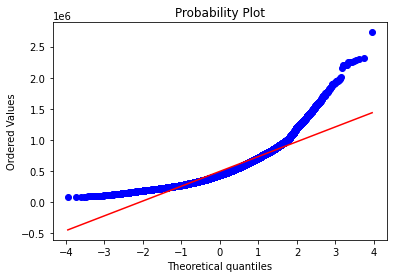

In [41]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [42]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is moderately skewed right, almost highly skewed
# some positive kurtosis, indicating more in the tails. We can see those tails in the right skew.

Skewness: 1.786531
Kurtosis: 5.455957


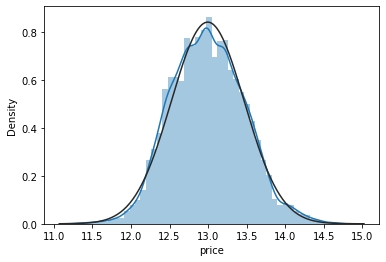

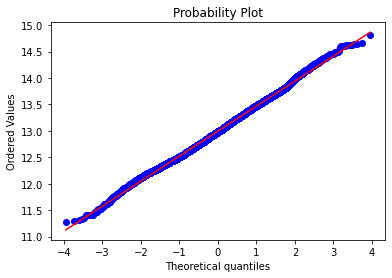

In [43]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed now
# transforming it gives more of a left skew

### Separate Continuous and Categorical

In [44]:
# prepare our categories for data transformation by separating into our data types -
# our target dependent variable, categorical variables, and continuous/ordinal variables

target = ['price']
categoricals = ['price', 'yr_built', 'month_sold', 'zipcode', 'waterfront', 'renovated','basement', 'comparative_sf'] # , 'lat'
continuous = ['sqft_living', 'sqft_lot', 'floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'sqft_above']

## Process Categoricals

In [45]:
df_categoricals = df[categoricals]

df_categoricals

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
17952  475896.0      2008           2    98116         0.0        0.0   
17953  362715.0      2009           5    98103         0.0        0.0   
17954  400754.0      2014           2    98146         0.0        0.0   
17955  401006.0      2004           1    98027         0.0        0.0   
17956  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf  
0           0.0              2  
1           1.0              3  
2           0.0              1  
3           1.0              3  
4           0.0              2  
...         ...            ...  
17952       1.0              2  
17953       0.0              2  
17954       0.0              3  
17955       0.0              2  
17956       0.0              2  

[17957 rows x 8 columns]

Let's look at mean price by month and see if there are any better insights.

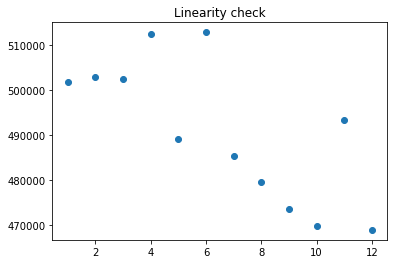

In [46]:
monthly_prices = df_categoricals.groupby('month_sold')['price'].mean()
month = df_categoricals['month_sold'].unique()

plt.scatter(month, monthly_prices)
plt.title("Linearity check")
plt.show()


Our average per month is all over. We are going to keep this as a categorical.

In [47]:
# binning our latitude into equally sized bins, where each bin has the same number of entries

#df_categoricals["lat_block"], lat_bins = pd.qcut(df_categoricals['lat'], q=40, retbins=True)

In [48]:
# binning our year built into equally sized bins, where each bin has the same number of entries

df_categoricals["year_block"], year_bins = pd.qcut(df_categoricals['yr_built'], q=25, retbins=True)

In [49]:
# identifying our categorical columns to one-hot encode
categorical = ['zipcode', 'waterfront', 'renovated', 'basement', 'month_sold', 'year_block', 'comparative_sf'] #  , 'lat_block'

# prepare a new dataframe that has the correct categorical columns (we aren't dropping from our df_categoricals dataframe,
# because we will be using that later still)
df_categorical_preprocess = df_categoricals[categorical]

# telling Pandas that these columns are categoricals
for item in categorical:
    df_categorical_preprocess[item] = df_categorical_preprocess[item].astype('category')

# adding price to our dataframe so that we can do some visualizations    
df_categorical_preprocess['price'] = df['price']

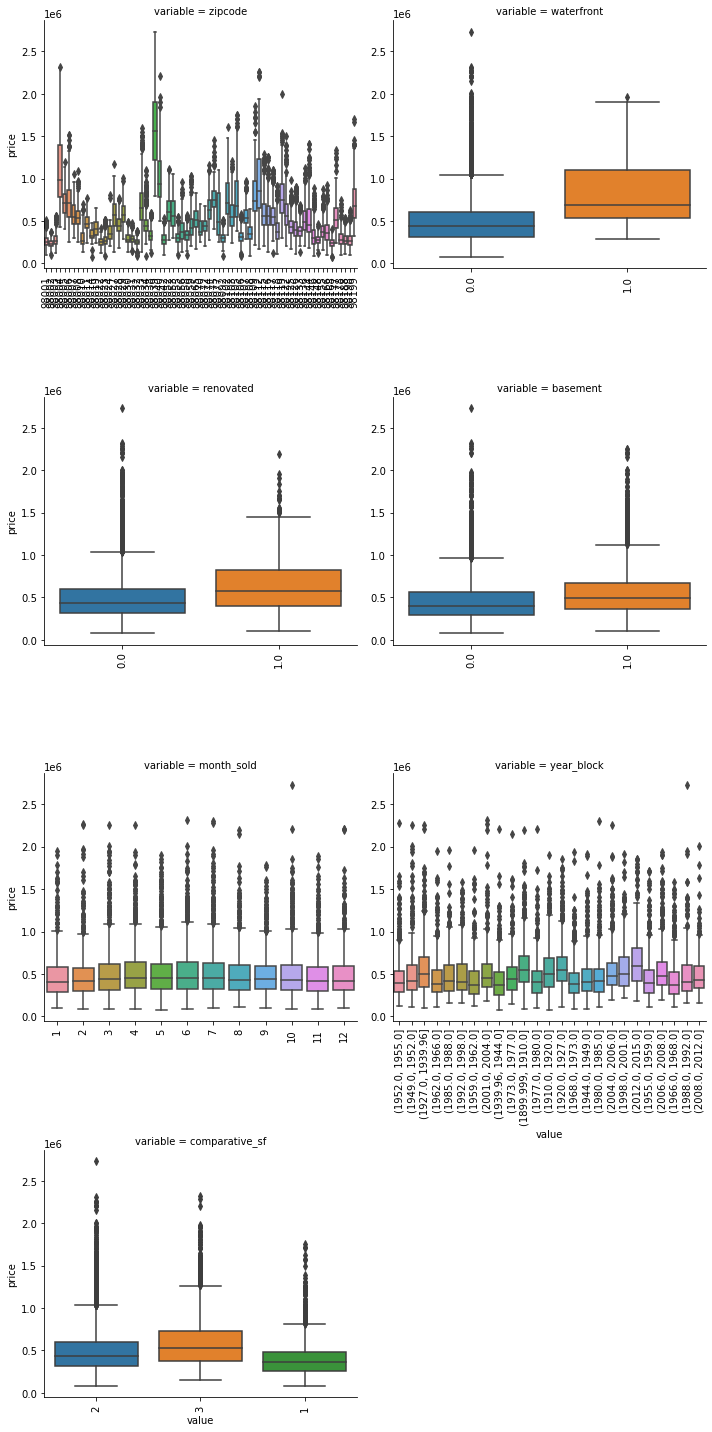

In [50]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categorical_preprocess, id_vars=['price'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

We can visually see the impact of several of our categorical variables. Ultimately we can see with our own eyes why many of these categories work better as very large one-hot-encoded items rather than ordinal continuous variables, even with polynomial relationship.

In [51]:
# make a processed bins file for use with linear regression
df_categoricals_processed = pd.get_dummies(df_categorical_preprocess[categorical], prefix=categorical, drop_first=True)

In [52]:
df_categoricals_processed

zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
17952              0              0              0              0   
17953              0              0              0              0   
17954              0              0              0              0   
17955              0              0              0              0   
17956              0              0              0              0   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
17952              0              0              0              0   
17953              0              0              0              0   
17954              0              0              0              0   
17955              0              0              0              0   
17956              0              0              0              0   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
17952              0              0              0              0   
17953              0              0              0              0   
17954              0              0              0              0   
17955              0              0              0              0   
17956              0              0              0              0   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              1   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
17952              0              0              0              0   
17953              0              0              0              0   
17954              0              0              0              0   
17955              0              0              1              0   
17956              0              0              0              0   

       zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
17952              0              0              0              0   
17953              0              0              0              0   
17954              0              0              0              0   
1

## Create Train/Test Split

We need to create our holdout data before processing our continuous. The biggest reason for this is we will standardize our continuous variables, and you should standardize on your train set and apply that to your test set. Otherwise you are leaking your test data into your train data.

In [53]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 77

In [54]:
# prepare our holdout sets. We're making two separate predictor frames because the continuous variables 
# require processing after we pull this apart, so we're keeping them separate from the categoricals for now.

x_continuous = df[continuous] #continuous variables that require additional processing
x_categorical = df_categoricals_processed # cleaned categorical variables
y = np.log(df[target]) # our log-transformed target variable

In [55]:
# creating our train/validation sets and our test sets

x_train_cont, x_test_cont, y_train_val, y_test = train_test_split(x_continuous, y, test_size=0.2, random_state=randomstate)
x_train_cat, x_test_cat = train_test_split(x_categorical, test_size=0.2, random_state=randomstate)

In [56]:
# reset all of the indices for these data frames just to ward against manipulation mistakes that might result in
# mismatched indices

x_train_cont.reset_index(inplace=True)
x_train_cont.drop('index', axis=1, inplace=True)

x_test_cont.reset_index(inplace=True)
x_test_cont.drop('index', axis=1, inplace=True)

x_train_cat.reset_index(inplace=True)
x_train_cat.drop('index', axis=1, inplace=True)

x_test_cat.reset_index(inplace=True)
x_test_cat.drop('index', axis=1, inplace=True)

y_train_val.reset_index(inplace=True)
y_train_val.drop('index', axis=1, inplace=True)

y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

## Process Train Continuous/Ordinal

### Study Correlations/Multicollinearity

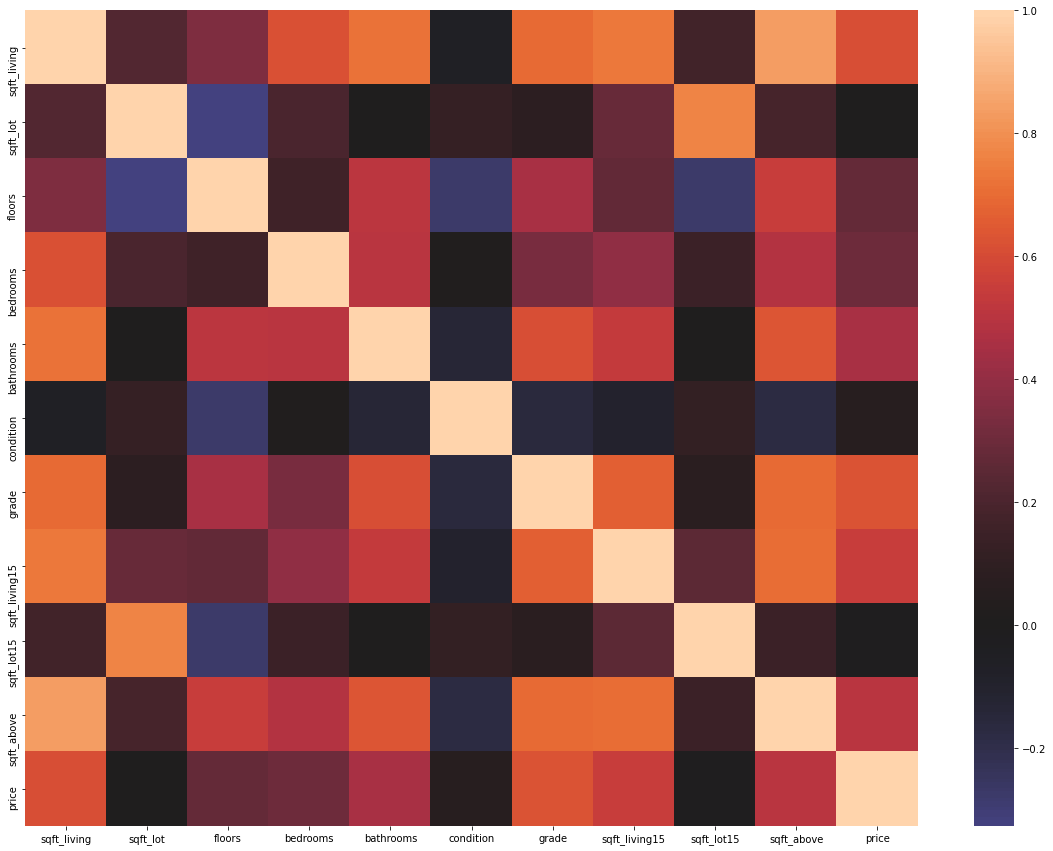

In [57]:
x_train_cont['price'] = y_train_val

# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(x_train_cont.corr(), center=0);

plt.show()

In [58]:
x_train_cont.corr()

sqft_living  sqft_lot    floors  bedrooms  bathrooms  \
sqft_living       1.000000  0.227242  0.345501  0.617116   0.716367   
sqft_lot          0.227242  1.000000 -0.325996  0.202084  -0.001224   
floors            0.345501 -0.325996  1.000000  0.158725   0.508464   
bedrooms          0.617116  0.202084  0.158725  1.000000   0.502542   
bathrooms         0.716367 -0.001224  0.508464  0.502542   1.000000   
condition        -0.053036  0.121784 -0.274779  0.024550  -0.133778   
grade             0.698546  0.086968  0.458802  0.331296   0.608586   
sqft_living15     0.736099  0.281576  0.269566  0.390149   0.530657   
sqft_lot15        0.171208  0.771261 -0.271621  0.146796  -0.003537   
sqft_above        0.838980  0.184011  0.547666  0.486983   0.633288   
price             0.615601 -0.002141  0.276229  0.299698   0.459259   

               condition     grade  sqft_living15  sqft_lot15  sqft_above  \
sqft_living    -0.053036  0.698546       0.736099    0.171208    0.838980   
sqft_lot        0.121784  0.086968       0.281576    0.771261    0.184011   
floors         -0.274779  0.458802       0.269566   -0.271621    0.547666   
bedrooms        0.024550  0.331296       0.390149    0.146796    0.486983   
bathrooms      -0.133778  0.608586       0.530657   -0.003537    0.633288   
condition       1.000000 -0.157377      -0.094616    0.114169   -0.172421   
grade          -0.157377  1.000000       0.668003    0.075022    0.695942   
sqft_living15  -0.094616  0.668003       1.000000    0.255905    0.705878   
sqft_lot15      0.114169  0.075022       0.255905    1.000000    0.142747   
sqft_above     -0.172421  0.695942       0.705878    0.142747    1.000000   
price           0.057431  0.628222       0.547127   -0.011637    0.499049   

                  price  
sqft_living    0.615601  
sqft_lot      -0.002141  
floors         0.276229  
bedrooms       0.299698  
bathrooms      0.459259  
condition      0.057431  
grade          0.628222  
sqft_living15  0.547127  
sqft_lot15    -0.011637  
sqft_above     0.499049  
price          1.000000

In [59]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = x_train_cont.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation
df_correlations[df_correlations.correlation>.70]


level_0        level_1  correlation
pairs                                                                  
(sqft_living, sqft_above)       sqft_living     sqft_above     0.838980
(sqft_above, sqft_living)        sqft_above    sqft_living     0.838980
(sqft_lot, sqft_lot15)             sqft_lot     sqft_lot15     0.771261
(sqft_lot15, sqft_lot)           sqft_lot15       sqft_lot     0.771261
(sqft_living15, sqft_living)  sqft_living15    sqft_living     0.736099
(sqft_living, sqft_living15)    sqft_living  sqft_living15     0.736099
(bathrooms, sqft_living)          bathrooms    sqft_living     0.716367
(sqft_living, bathrooms)        sqft_living      bathrooms     0.716367
(sqft_living15, sqft_above)   sqft_living15     sqft_above     0.705878
(sqft_above, sqft_living15)      sqft_above  sqft_living15     0.705878

we're going to drop sqft_above and sqft_lot15 and just keep the base sqft_living and sqft_lot. We're also going to drop sqft_living15 which fell JUST under the threshold of collinearity, based on the fact that a realtor does not easily have that information available to use in our predictive model. 

In [60]:
x_train_cont.drop(['sqft_above', 'sqft_lot15', 'sqft_living15'], axis=1, inplace=True)

### Check Linearity of Continuous Predictors

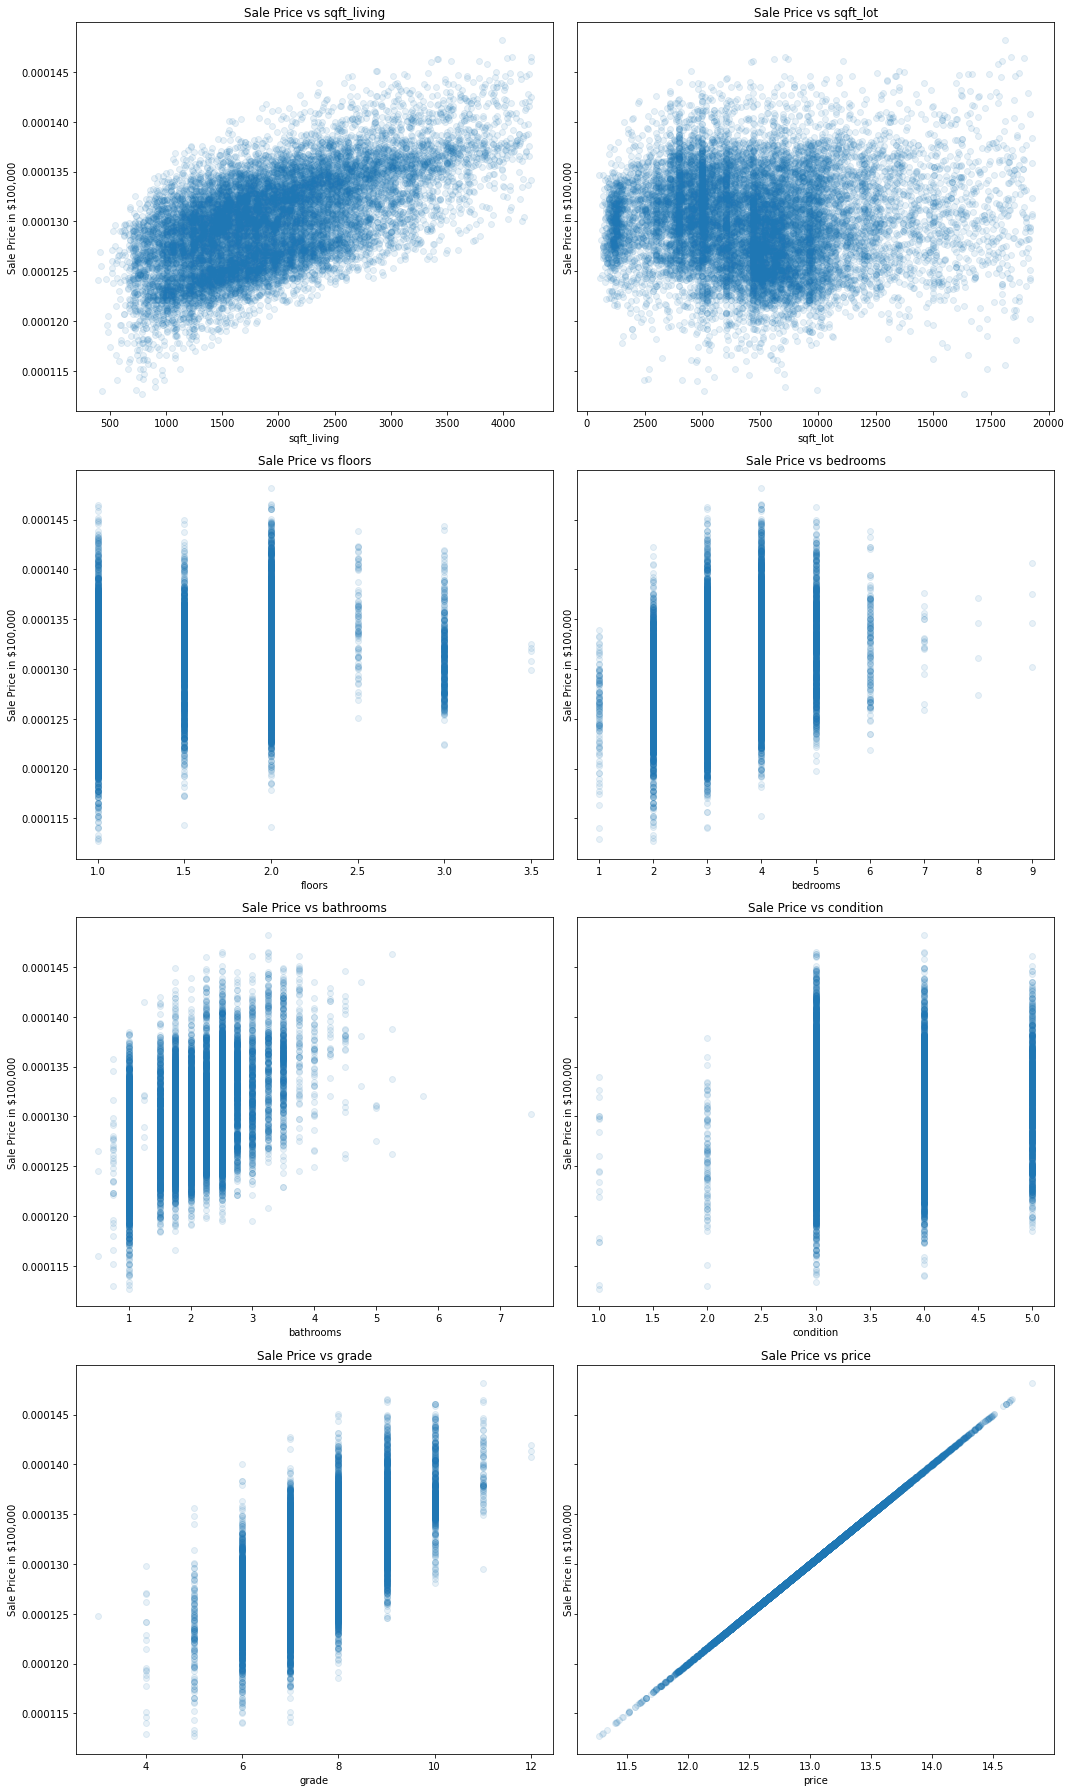

In [61]:
# check linearity

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), x_train_cont.columns):
    ax.scatter(x_train_cont[column], x_train_cont['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()


    * sqft_living, grade have a very strong visual relationship with price
    * bedrooms, bathrooms have a moderate visual relationship with price
    * floors, condition, sqft_lot do not appear to have a strong relationship with price

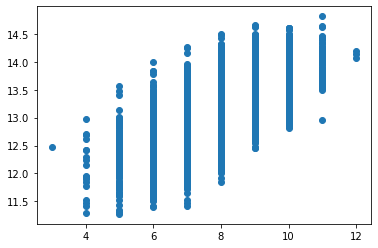

In [62]:
# grade has a very strong relationship to price

plt.scatter(x=x_train_cont['grade'], y=x_train_cont['price']);

Fun fact - "grade" was not well defined in the features list. I looked it up and found that grade is "	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value." So, it's the quality of building materials, and DEFINITELY worth keeping in our model.

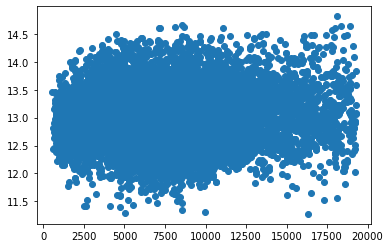

In [63]:
plt.scatter(x=x_train_cont['sqft_lot'], y=x_train_cont['price']);

# this variable does not appear to have a very linear relationship with the target variable.

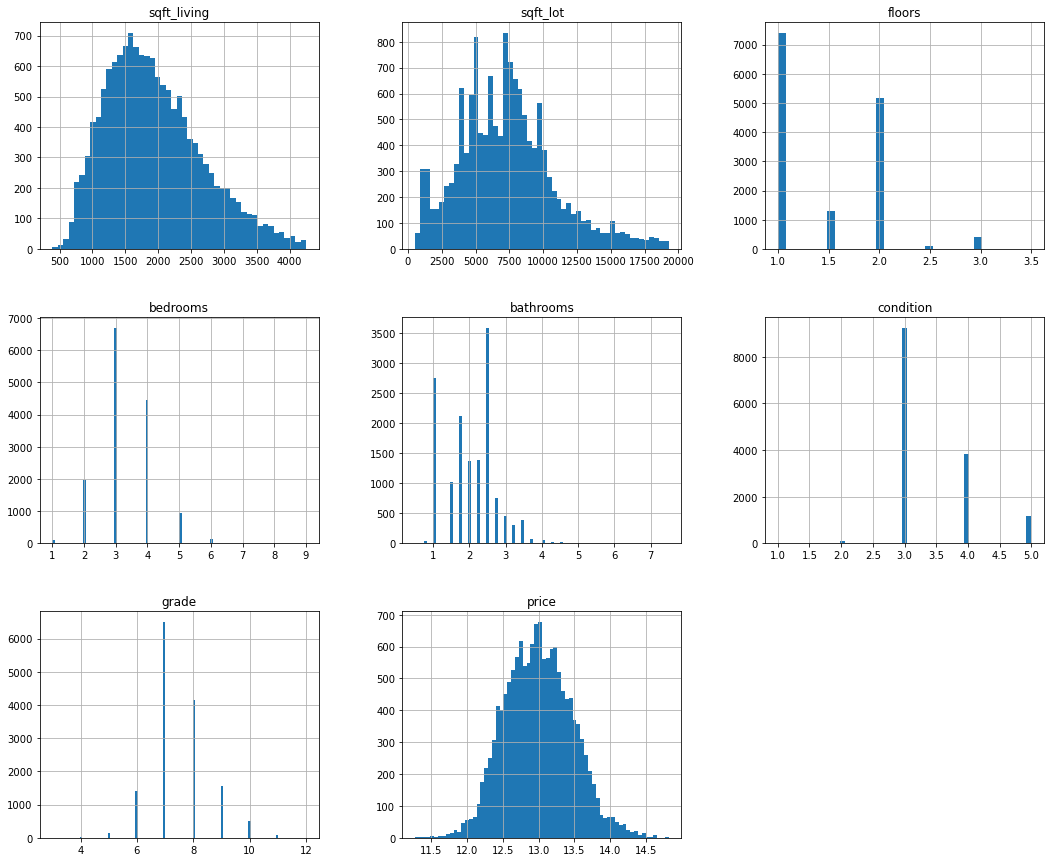

In [64]:
# check out our histograms

x_train_cont.hist(figsize=(18,15), bins='auto');


### Transform and Standardize

In [65]:
# We're going to transform all of these.

# log features
#log_names = [f'{column}' for column in x_train_cont.columns]

#x_train_cont_log = np.log(x_train_cont)
#x_train_cont_log.columns = log_names

In [66]:
# check out our histograms for our transformed data

#x_train_cont_log.hist(figsize=(18,15), bins='auto');

# looks more normal

In [67]:
# check linearity
'''

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), x_train_cont_log.columns):
    ax.scatter(x_train_cont_log[column], x_train_cont['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()
'''

"\n\nfig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,15), sharey=True)\n\nfor ax, column in zip(axes.flatten(), x_train_cont_log.columns):\n    ax.scatter(x_train_cont_log[column], x_train_cont['price']/100000, label=column, alpha=.1)\n    ax.set_title(f'Sale Price vs {column}')\n    ax.set_xlabel(column)\n    ax.set_ylabel('Sale Price in $100,000')\n\nfig.tight_layout()\n"

In [68]:
#fig = plt.figure(figsize=(20,15))
#plt.scatter(x=x_train_cont_log['sqft_lot'], y=x_train_cont['price']);

# log transforming sqft_lot did not help much. This variable simply does not appear to have a great linear relationship with our target variable.

In [69]:
#x_train_cont_log.drop('price', axis=1, inplace=True)
x_train_cont.drop('price', axis=1, inplace=True)

In [70]:
# standardize all of our values with scikit-learn StandardScaler

scaler = StandardScaler()

#transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont_log),columns = x_train_cont_log.columns)
transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont),columns = x_train_cont.columns)

In [71]:
transformed_scaled_continuous

sqft_living  sqft_lot    floors  bedrooms  bathrooms  condition  \
0        -0.682973 -0.871139 -0.878315 -1.520785  -0.416368  -0.643570   
1         2.167820 -0.683064 -0.878315  0.765924   1.351313  -0.643570   
2        -0.545916 -0.010766  0.982461 -1.520785  -0.062832  -0.643570   
3        -0.587033  0.258714 -0.878315 -0.377430  -0.416368   0.884509   
4         1.975940 -0.071399  0.982461 -0.377430   0.644240  -0.643570   
...            ...       ...       ...       ...        ...        ...   
14360     2.414523  0.855221  0.982461 -0.377430   1.351313  -0.643570   
14361     0.153077  1.474465  0.982461  0.765924   0.290704   0.884509   
14362     0.687600 -1.200410  0.982461  0.765924   2.058385  -0.643570   
14363    -0.861148  0.376612 -0.878315 -0.377430  -0.416368   0.884509   
14364     0.002314 -0.990440 -0.878315 -0.377430  -0.062832   0.884509   

          grade  
0      0.485054  
1      0.485054  
2     -0.507087  
3      0.485054  
4      0.485054  
...         ...  
14360  1.477195  
14361 -0.507087  
14362  0.485054  
14363 -1.499228  
14364 -0.507087  

[14365 rows x 7 columns]

## Process Test Continuous/Ordinal

In [72]:
# drop columns that we didn't use in our train set

x_test_cont.drop(['sqft_above', 'sqft_lot15', 'sqft_living15'], axis=1, inplace=True)

In [73]:
# We're going to transform all of these, same as train set

# log features
#log_names = [f'{column}' for column in x_test_cont.columns]

#holdout_log = np.log(x_test_cont)
#holdout_log.columns = log_names

In [74]:
# standardize all of our values with scikit-learn StandardScaler that we fit on the train set

#holdout_scaled = pd.DataFrame(scaler.transform(holdout_log),columns = holdout_log.columns)
holdout_scaled = pd.DataFrame(scaler.transform(x_test_cont),columns = x_test_cont.columns)

In [75]:
# combine our processed holdout continuous with our holdout categoricals

X_test = holdout_scaled.join([x_test_cat])

In [76]:
# prepared test data

X_test

sqft_living  sqft_lot    floors  bedrooms  bathrooms  condition  \
0       -1.381966  0.020112 -0.878315 -1.520785  -0.769904   0.884509   
1        1.181007 -0.457093  0.982461  1.909279   1.351313  -0.643570   
2       -0.915971 -0.244035  0.052073  0.765924  -1.476976  -0.643570   
3       -0.902265 -1.539226  2.843238 -0.377430   0.644240  -0.643570   
4        0.344957 -0.669309  0.982461  0.765924   0.644240  -0.643570   
...           ...       ...       ...       ...        ...        ...   
3587    -0.477387 -0.615413  0.052073 -1.520785  -0.416368  -0.643570   
3588    -1.560140 -0.653589 -0.878315 -1.520785  -1.476976  -0.643570   
3589     1.715531  1.198247  0.982461  0.765924   0.290704  -0.643570   
3590    -0.998205 -0.372881 -0.878315 -1.520785  -1.476976   0.884509   
3591    -1.450494 -1.158865 -0.878315 -1.520785  -1.476976  -0.643570   

         grade  zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0    -0.507087              0              0              0              0   
1     0.485054              0              0              0              0   
2    -0.507087              0              0              0              0   
3     0.485054              0              0              0              0   
4     0.485054              0              0              0              0   
...        ...            ...            ...            ...            ...   
3587  1.477195              0              0              0              0   
3588 -0.507087              0              0              0              0   
3589  2.469336              0              0              0              0   
3590 -0.507087              0              0              0              0   
3591 -0.507087              0              0              0              0   

      zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3587              0              0              0              0   
3588              0              0              0              0   
3589              0              0              0              0   
3590              0              0              0              0   
3591              0              0              0              0   

      zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3587              0              0              0              0   
3588              0              0              0              0   
3589              0              0              0              0   
3590              0              0              0              0   
3591              0              0              0              0   

      zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3587              0              0              0              0   
3588          

In [77]:
# unscaled actual target values for test set

test_actual = np.exp(y_test['price']).astype(int)
test_actual

0       551191
1       642798
2       227420
3       547739
4       564207
         ...  
3587    855875
3588    438007
3589    755185
3590    713570
3591    417086
Name: price, Length: 3592, dtype: int32

## Final Prep for Linear Regression

In [78]:
# combine our processed train continuous with our train categoricals

X_train_val = transformed_scaled_continuous.join([x_train_cat], how='inner')

In [79]:
X_train_val

sqft_living  sqft_lot    floors  bedrooms  bathrooms  condition  \
0        -0.682973 -0.871139 -0.878315 -1.520785  -0.416368  -0.643570   
1         2.167820 -0.683064 -0.878315  0.765924   1.351313  -0.643570   
2        -0.545916 -0.010766  0.982461 -1.520785  -0.062832  -0.643570   
3        -0.587033  0.258714 -0.878315 -0.377430  -0.416368   0.884509   
4         1.975940 -0.071399  0.982461 -0.377430   0.644240  -0.643570   
...            ...       ...       ...       ...        ...        ...   
14360     2.414523  0.855221  0.982461 -0.377430   1.351313  -0.643570   
14361     0.153077  1.474465  0.982461  0.765924   0.290704   0.884509   
14362     0.687600 -1.200410  0.982461  0.765924   2.058385  -0.643570   
14363    -0.861148  0.376612 -0.878315 -0.377430  -0.416368   0.884509   
14364     0.002314 -0.990440 -0.878315 -0.377430  -0.062832   0.884509   

          grade  zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0      0.485054              0              0              0              0   
1      0.485054              0              0              0              0   
2     -0.507087              0              0              0              0   
3      0.485054              0              0              0              0   
4      0.485054              0              0              0              0   
...         ...            ...            ...            ...            ...   
14360  1.477195              0              0              0              0   
14361 -0.507087              1              0              0              0   
14362  0.485054              0              0              0              0   
14363 -1.499228              0              0              0              0   
14364 -0.507087              0              0              0              0   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              1              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
14360              0              0              0              0   
14361              0              0              0              0   
14362              0              0              0              0   
14363              0              0              0              0   
14364              0              0              0              0   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              1              0   
...              ...            ...            ...            ...   
14360              0              0              0              0   
14361              0              0              0              0   
14362              0              0              0              0   
14363              0              0              0              0   
14364              0              0              0              0   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
14360              0        

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [80]:
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [81]:
values = pd.DataFrame({'actual':test_actual})

## Base Linear Regression Model

Run a base model with no cross-validation or specific feature selection to see our base model scores.

In [82]:
predictors_train = sm.add_constant(X_train_val)
model = sm.OLS(y_train_val, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     828.8
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        15:52:50   Log-Likelihood:                 5059.9
No. Observations:               14365   AIC:                            -9888.
Df Residuals:                   14249   BIC:                            -9009.
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           12.5919      0.016    784.174      0.000      12.560      12.623
sqft_living                      0.1884      0.003     59.126      0.000       0.182       0.195
sqft_lot                         0.0243      0.002     11.118      0.000       0.020       0.029
floors                          -0.0123      0.002     -5.018      0.000      -0.017      -0.007
bedrooms                        -0.0019      0.002     -0.955      0.339      -0.006       0.002
bathrooms                        0.0265      0.003     10.303      0.000       0.021       0.032
condition                        0.0365      0.002     21.897      0.000       0.033       0.040
grade                            0.1038      0.003     41.148      0.000       0.099       0.109
zipcode_98002                   -0.0125      0.018     -0.688      0.491      -0.048       0.023
zipcode_98003                    0.0409      0.016      2.509      0.012       0.009       0.073
zipcode_98004                    1.1074      0.017     65.288      0.000       1.074       1.141
zipcode_98005                    0.7722      0.021     36.985      0.000       0.731       0.813
zipcode_98006                    0.6556      0.015     43.974      0.000       0.626       0.685
zipcode_98007                    0.6615      0.020     32.854      0.000       0.622       0.701
zipcode_98008                    0.6933      0.017     41.768      0.000       0.661       0.726
zipcode_98010                    0.2300      0.031      7.412      0.000       0.169       0.291
zipcode_98011                    0.4684      0.018     25.438      0.000       0.432       0.504
zipcode_98014                    0.3519      0.031     11.477      0.000       0.292       0.412
zipcode_98019                    0.3406      0.020     17.257      0.000       0.302       0.379
zipcode_98022                    0.0295      0.020      1.479      0.139      -0.010       0.069
zipcode_98023                   -0.0178      0.014     -1.235      0.217      -0.046       0.010
zipcode_98024                    0.3735      0.040      9.368      0.000       0.295       0.452
zipcode_98027                    0.5951      0.017     35.509      0.000       0.562       0.628
zipcode_98028                    0.4241      0.016     26.127      0.000       0.392       0.456
zipcode_98029                    0.6217      0.016     38.487      0.000       0.590       0.653
zipcode_98030                    0.0578      0.017      3.469      0.001       0.025       0.090
zipcode_98031                    0.0812      0.016      4.928      0.000       0.049       0.114
zipcode_98032                    0.0102      0.021      0.484      0.629      -0.031       0.052
zipcode_98033                    0.7861      0.015     52.911      0.000    

Perform cross-validation with our base model over 5 splits and get our mean R^2.

In [83]:
model = LinearRegression()
model.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(model, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.8674507924122722

In [84]:
# How many predictors are in our base model?
print("{} predictors used for this model".format(X_train_val.shape[1]))

115 predictors used for this model


In [85]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

residuals = test_actual - test_predictions_unscaled

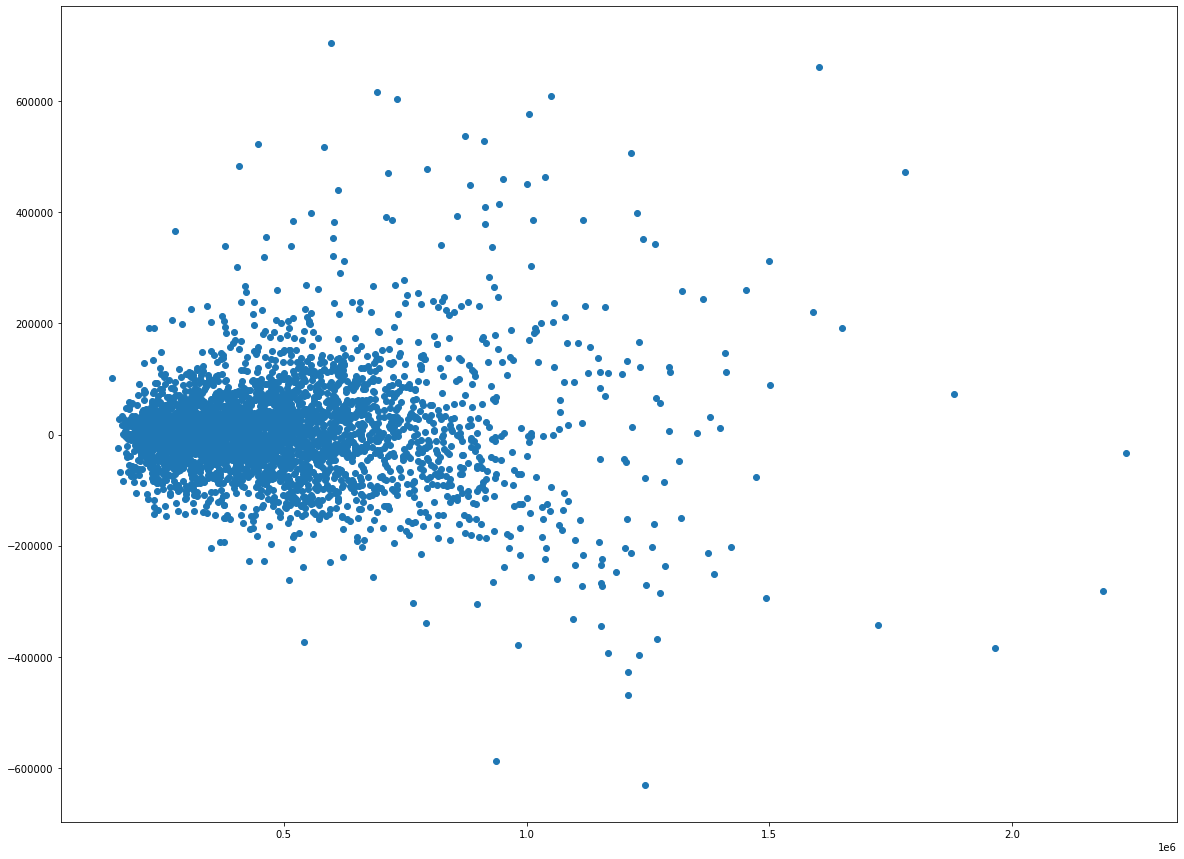

In [86]:
fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# We can see just a couple of outliers showing up in our residuals

In [87]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

61836.92

In [88]:
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)
rmse

14579.31

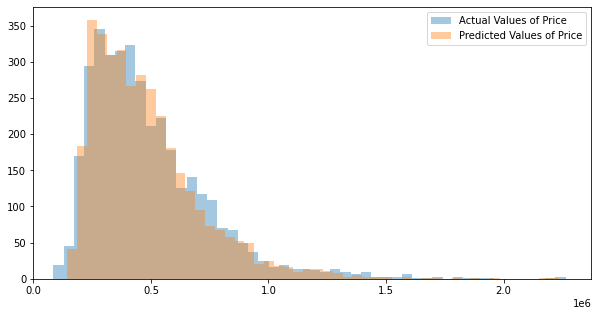

In [89]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(test_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [90]:
models['Models'].append('Basic LR')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [91]:
values['lin_pred'] = test_predictions_unscaled
values['lin_resid'] = residuals

### Study Residuals

In [92]:
# We need our statsmodels model again to plot residuals
predictors_train = sm.add_constant(X_train_val)
model = sm.OLS(y_train_val, predictors_train).fit()

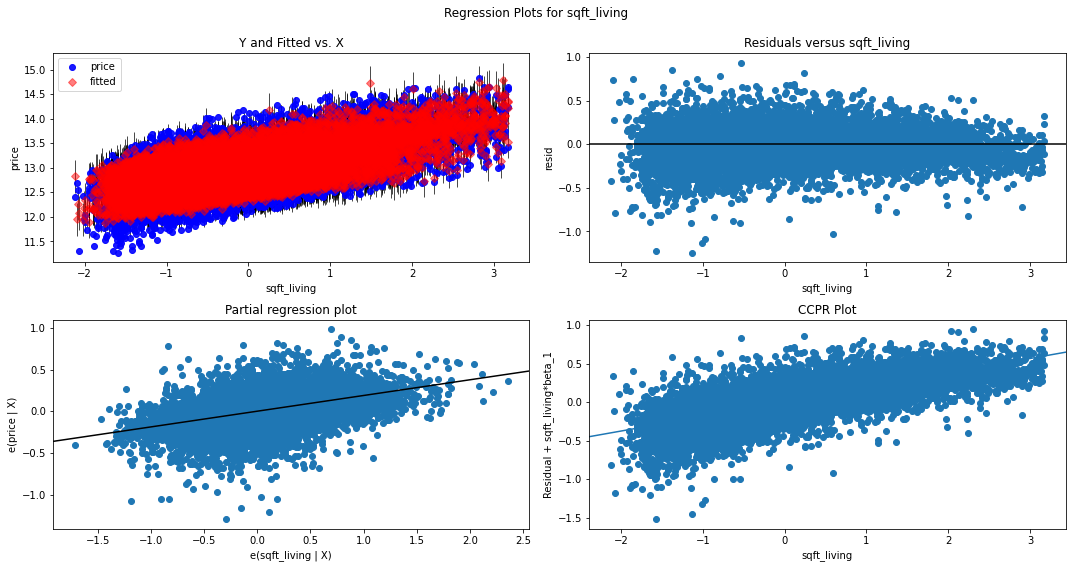

In [93]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

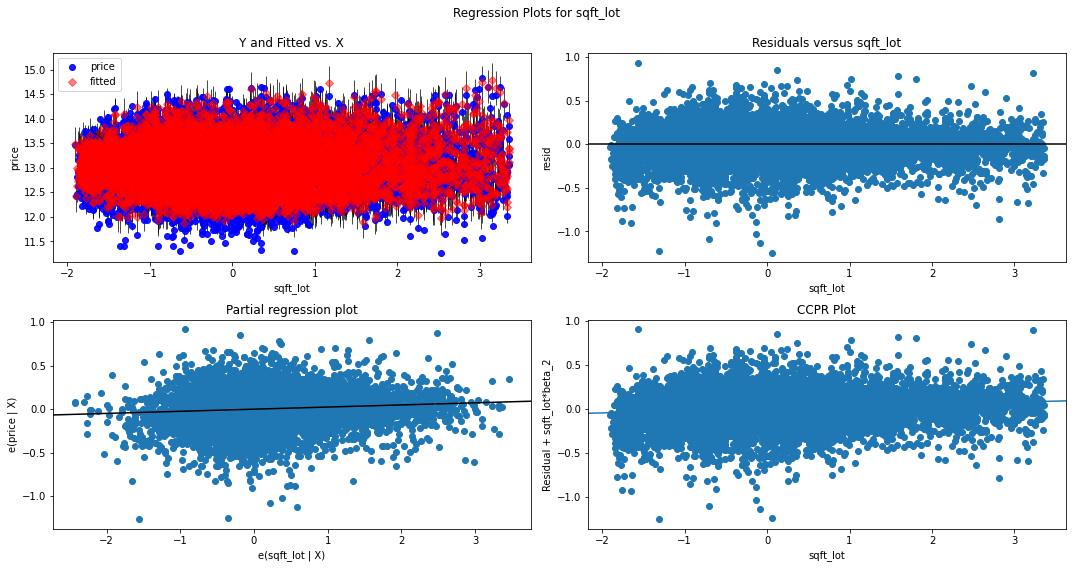

In [94]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_lot", fig=fig)
plt.show()

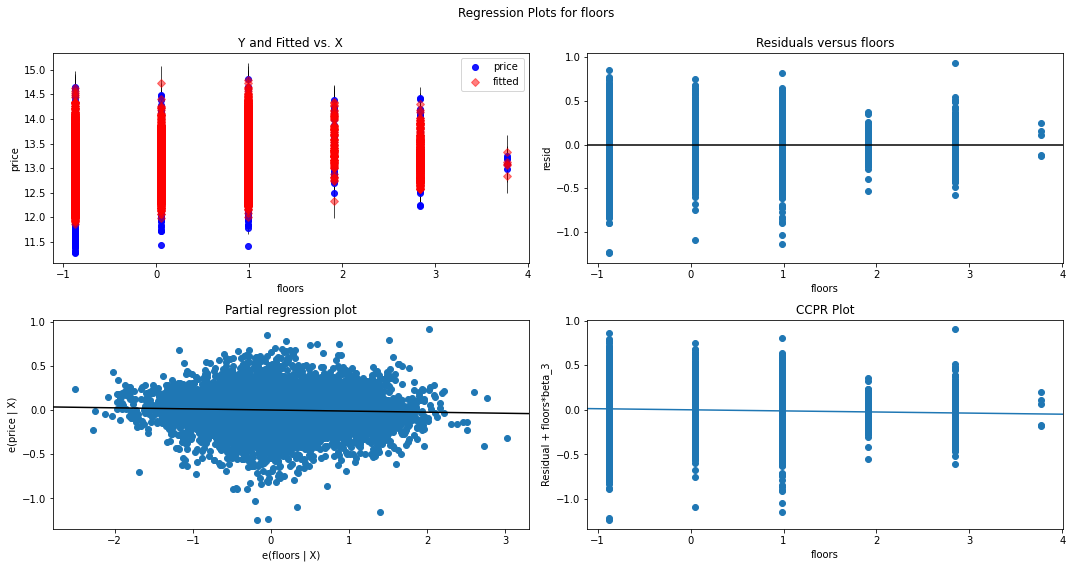

In [95]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "floors", fig=fig)
plt.show()

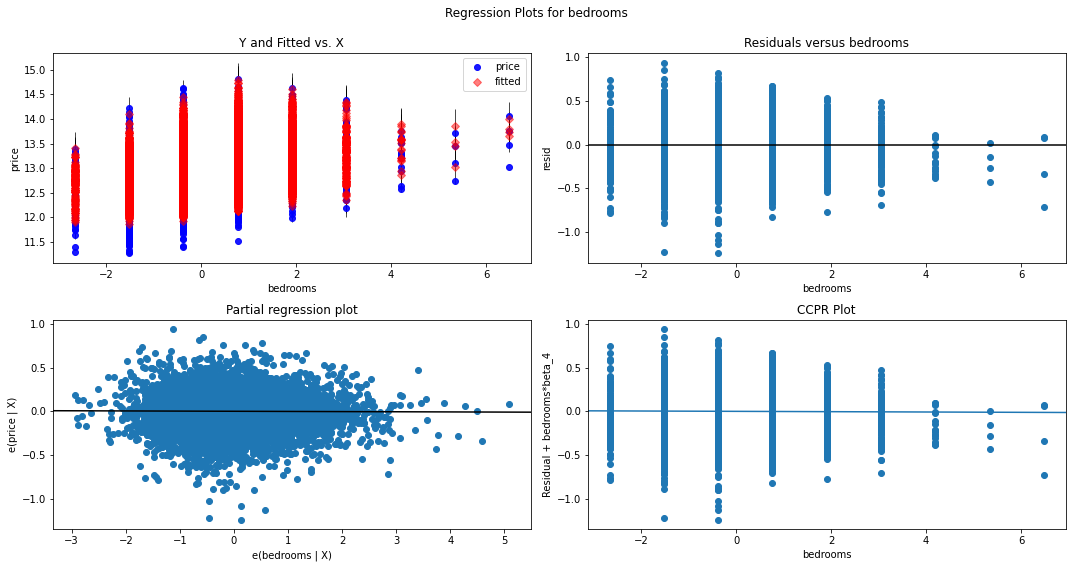

In [96]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bedrooms", fig=fig)
plt.show()

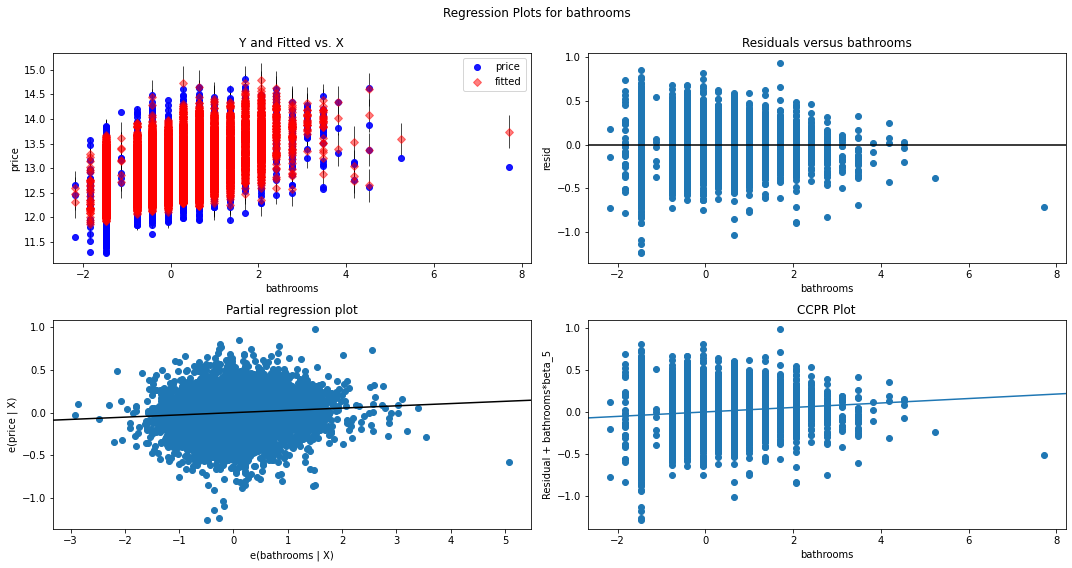

In [97]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

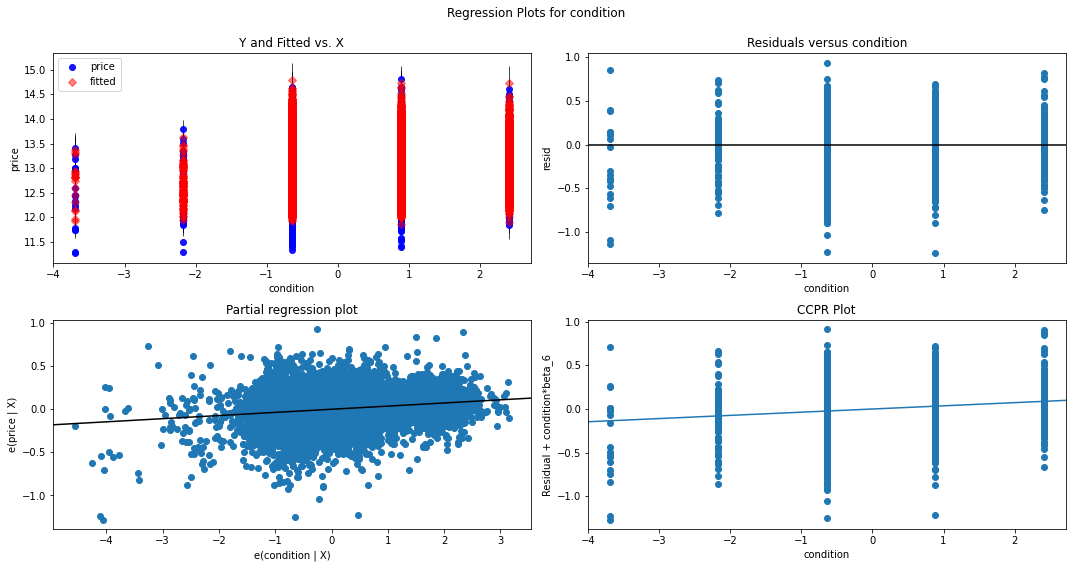

In [98]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "condition", fig=fig)
plt.show()

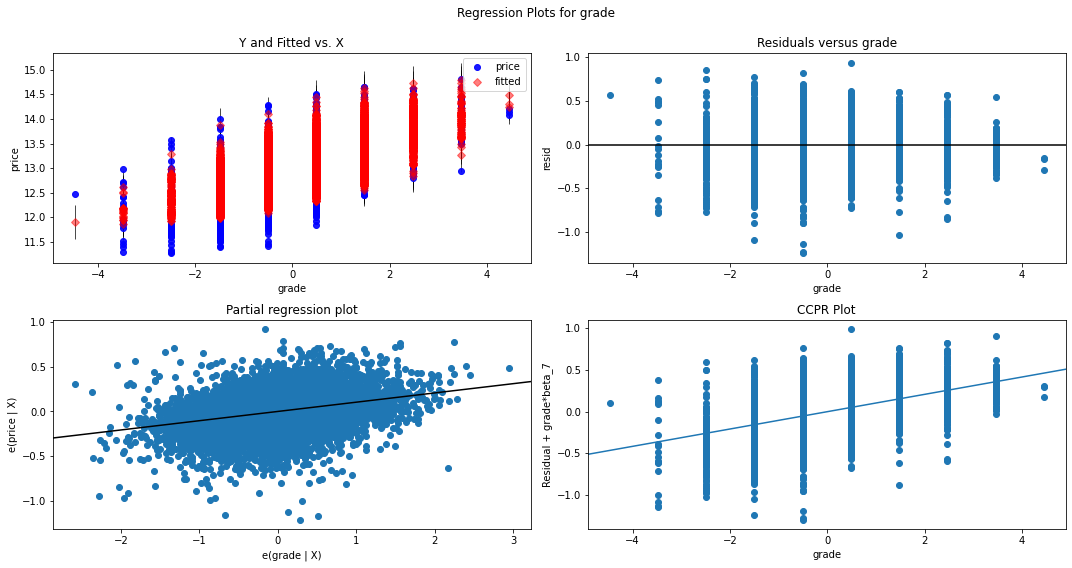

In [99]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

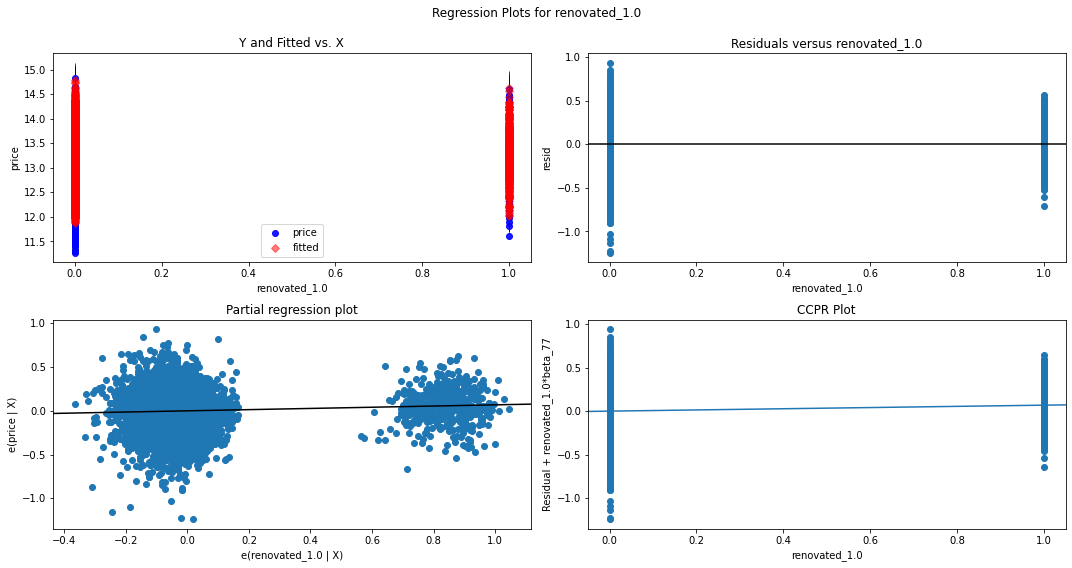

In [100]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "renovated_1.0", fig=fig)
plt.show()

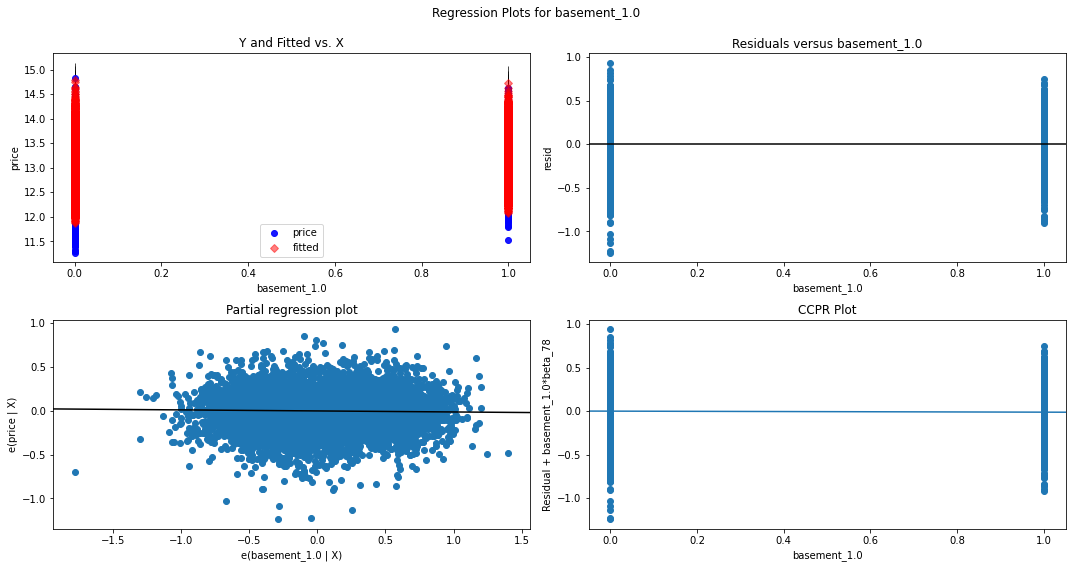

In [101]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "basement_1.0", fig=fig)
plt.show()

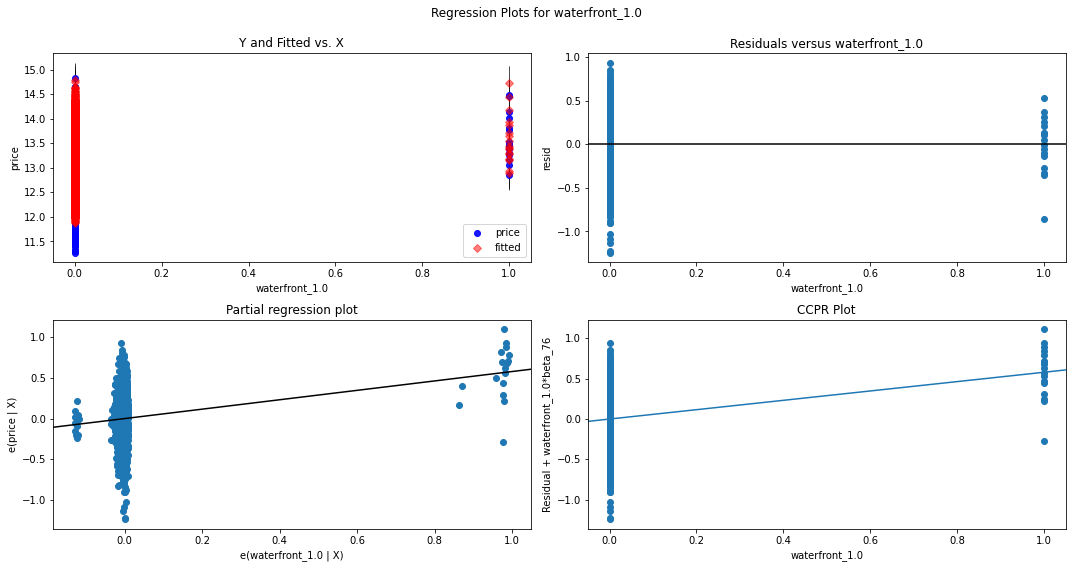

In [102]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "waterfront_1.0", fig=fig)
plt.show()

### Find/Add Interactions

I wrote a function which finds all of the feature combinations possible in our dataset. Then for each combination, the function runs a linear regression with cross validation on 5 folds and gets the r^2 score for the regression including that feature combination. All scores are recorded and r^2 score improvement is assessed, with the resulting table giving the increase in model improvement from a feature combo. 

In [103]:
def test_feature_combinations(price, variables):
    
    """Function takes in target price and a dataframe of independent variables, and 
    tests model improvement for each combination of variables"""
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df

In [104]:
# running our function on our continuous variables to look for improvement
# our R2 is much lower for model base score because we aren't including our categorical variables in this improvement assessment

scoring_df = test_feature_combinations(y_train_val, transformed_scaled_continuous)

Model base score is  0.4944
sqft_living sqft_lot 0.497
sqft_living floors 0.4945
sqft_living bedrooms 0.4949
sqft_living bathrooms 0.495
sqft_living condition 0.4997
sqft_living grade 0.4943
sqft_lot floors 0.4944
sqft_lot bedrooms 0.4952
sqft_lot bathrooms 0.4978
sqft_lot condition 0.4952
sqft_lot grade 0.4952
floors bedrooms 0.4946
floors bathrooms 0.4944
floors condition 0.5007
floors grade 0.4943
bedrooms bathrooms 0.4956
bedrooms condition 0.495
bedrooms grade 0.4945
bathrooms condition 0.5001
bathrooms grade 0.4945
condition grade 0.4986


In [105]:
# showing our improvement scores for our interactions

scoring_df.sort_values('improvement', ascending=False)

feature1   feature2  scores  improvement
13       floors  condition  0.5007       0.0063
18    bathrooms  condition  0.5001       0.0057
4   sqft_living  condition  0.4997       0.0053
20    condition      grade  0.4986       0.0042
8      sqft_lot  bathrooms  0.4978       0.0034
0   sqft_living   sqft_lot  0.4970       0.0026
15     bedrooms  bathrooms  0.4956       0.0012
7      sqft_lot   bedrooms  0.4952       0.0008
9      sqft_lot  condition  0.4952       0.0008
10     sqft_lot      grade  0.4952       0.0008
3   sqft_living  bathrooms  0.4950       0.0006
16     bedrooms  condition  0.4950       0.0006
2   sqft_living   bedrooms  0.4949       0.0005
11       floors   bedrooms  0.4946       0.0002
1   sqft_living     floors  0.4945       0.0001
17     bedrooms      grade  0.4945       0.0001
19    bathrooms      grade  0.4945       0.0001
6      sqft_lot     floors  0.4944       0.0000
12       floors  bathrooms  0.4944       0.0000
5   sqft_living      grade  0.4943      -0.0001
14       floors      grade  0.4943      -0.0001

We won't add any interactions. None of these improvements were significant enough.

In [106]:
break

SyntaxError: 'break' outside loop (<ipython-input-106-6aaf1f276005>, line 1)

## Linear Regression - Feature Selectors

### Forward-Backward Selector

First we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model.

This model gives us a list of the important features based on their p-value.

This model takes quite some time to run, so is commented out with the results replicated in markdown following.

In [ ]:

'''def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


result = stepwise_selection(X_train_val, y_train_val, verbose=True)

print('resulting features:', result)'''


result = ['grade', 'sqft_living', 'zipcode_98023', 'zipcode_98092', 'year_block_(1921.0, 1927.0]', 'zipcode_98004', 'zipcode_98002', 'condition', 'zipcode_98115', 'zipcode_98112', 'zipcode_98199', 'zipcode_98103', 'zipcode_98117', 'zipcode_98119', 'zipcode_98105', 'zipcode_98033', 'zipcode_98040', 'zipcode_98107', 'zipcode_98122', 'zipcode_98116', 'zipcode_98109', 'zipcode_98102', 'zipcode_98052', 'zipcode_98006', 'zipcode_98136', 'zipcode_98005', 'zipcode_98053', 'zipcode_98008', 'comparative_sf_3', 'zipcode_98144', 'month_sold_4', 'zipcode_98029', 'zipcode_98074', 'zipcode_98125', 'zipcode_98007', 'zipcode_98177', 'zipcode_98027', 'zipcode_98034', 'zipcode_98075', 'zipcode_98126', 'zipcode_98039', 'renovated_1.0', 'zipcode_98118', 'zipcode_98133', 'zipcode_98011', 'zipcode_98155', 'zipcode_98065', 'zipcode_98028', 'zipcode_98072', 'sqft_lot', 'year_block_(2012.0, 2015.0]', 'waterfront_1.0', 'month_sold_3', 'year_block_(1927.0, 1940.0]', 'year_block_(1911.0, 1921.0]', 'zipcode_98077', 'zipcode_98059', 'zipcode_98056', 'zipcode_98108', 'zipcode_98106', 'zipcode_98019', 'zipcode_98166', 'zipcode_98146', 'zipcode_98024', 'bathrooms', 'zipcode_98014', 'year_block_(2006.0, 2008.0]', 'zipcode_98070', 'zipcode_98038', 'zipcode_98058', 'comparative_sf_2', 'year_block_(2004.0, 2006.0]', 'year_block_(1977.0, 1979.0]', 'zipcode_98178', 'zipcode_98055', 'year_block_(1962.0, 1966.0]', 'year_block_(1968.0, 1973.0]', 'year_block_(1973.0, 1977.0]', 'year_block_(1959.0, 1962.0]', 'year_block_(1966.0, 1968.0]', 'year_block_(1955.0, 1959.0]', 'floors', 'basement_1.0', 'month_sold_5', 'zipcode_98148', 'year_block_(1952.0, 1955.0]', 'zipcode_98031', 'zipcode_98010', 'zipcode_98198', 'zipcode_98168', 'month_sold_2', 'month_sold_6', 'year_block_(2008.0, 2012.0]', 'year_block_(1979.0, 1984.0]']

['grade', 'sqft_living', 'year_block_(1914.0, 1925.0]', 'lat_block_(47.375, 47.394]', 'lat_block_(47.394, 47.43]', 'lat_block_(47.43, 47.451]', 'condition', 'lat_block_(47.451, 47.474]', 'lat_block_(47.363, 47.375]', 'lat_block_(47.35, 47.363]', 'lat_block_(47.489, 47.5]', 'lat_block_(47.474, 47.489]', 'lat_block_(47.5, 47.512]', 'lat_block_(47.331, 47.35]', 'zipcode_98004', 'zipcode_98106', 'year_block_(1925.0, 1939.0]', 'lat_block_(47.655, 47.666]', 'lat_block_(47.633, 47.643]', 'lat_block_(47.674, 47.68]', 'lat_block_(47.643, 47.655]', 'lat_block_(47.666, 47.674]', 'lat_block_(47.68, 47.686]', 'zipcode_98040', 'waterfront_1.0', 'lat_block_(47.607, 47.621]', 'lat_block_(47.621, 47.633]', 'lat_block_(47.686, 47.692]', 'zipcode_98116', 'zipcode_98074', 'lat_block_(47.593, 47.607]', 'lat_block_(47.692, 47.698]', 'zipcode_98006', 'zipcode_98136', 'lat_block_(47.582, 47.593]', 'lat_block_(47.698, 47.707]', 'zipcode_98168', 'lat_block_(47.707, 47.718]', 'sqft_lot', 'zipcode_98027', 'zipcode_98014', 'year_block_(2011.0, 2015.0]', 'bedrooms', 'zipcode_98059', 'zipcode_98166', 'lat_block_(47.718, 47.727]', 'lat_block_(47.571, 47.582]', 'lat_block_(47.554, 47.564]', 'lat_block_(47.564, 47.571]', 'comparative_sf_3', 'lat_block_(47.547, 47.554]', 'zipcode_98108', 'lat_block_(47.54, 47.547]', 'lat_block_(47.727, 47.736]', 'lat_block_(47.532, 47.54]', 'zipcode_98177', 'zipcode_98032', 'renovated_1.0', 'zipcode_98019', 'zipcode_98075', 'lat_block_(47.524, 47.532]', 'lat_block_(47.736, 47.747]', 'lat_block_(47.747, 47.764]', 'lat_block_(47.764, 47.778]', 'lat_block_(47.512, 47.524]', 'basement_1.0', 'bathrooms', 'zipcode_98133', 'year_block_(1971.0, 1977.0]', 'year_block_(1962.0, 1967.0]', 'year_block_(1977.0, 1981.0]', 'year_block_(1959.0, 1962.0]', 'year_block_(1954.0, 1959.0]', 'year_block_(1967.0, 1971.0]', 'month_sold_4', 'zipcode_98112', 'zipcode_98119', 'zipcode_98102', 'zipcode_98109', 'zipcode_98024', 'zipcode_98010', 'zipcode_98038', 'month_sold_5', 'month_sold_6', 'zipcode_98039', 'zipcode_98103', 'zipcode_98117', 'zipcode_98115', 'comparative_lot_3', 'year_block_(2007.0, 2011.0]', 'zipcode_98122', 'zipcode_98199', 'zipcode_98105', 'zipcode_98107', 'zipcode_98033', 'month_sold_7', 'month_sold_3', 'zipcode_98188', 'zipcode_98070', 'zipcode_98198', 'floors', 'year_block_(1950.0, 1954.0]', 'month_sold_8', 'zipcode_98005', 'zipcode_98146', 'zipcode_98126', 'zipcode_98144', 'zipcode_98029', 'zipcode_98028', 'zipcode_98056', 'month_sold_9', 'year_block_(1981.0, 1987.0]', 'year_block_(1987.0, 1991.0]', 'year_block_(1945.0, 1950.0]', 'year_block_(1991.0, 1997.0]']

In [ ]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train_val[result]
X_test_refined = X_test[result]

predictors_int = sm.add_constant(X_train_refined)
model = sm.OLS(y_train_val, predictors_int).fit()
model.summary()

In [ ]:
print("{} predictors used".format(len(result)))

In [ ]:
model = LinearRegression()
model.fit(X_train_refined, y_train_val)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train_val, cv=cv)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
test_predictions_refined = model.predict(X_test_refined)

# reverse log transform our predicted values
test_predictions_refined_unscaled = np.exp(test_predictions_refined)
test_predictions_refined_unscaled=test_predictions_refined_unscaled.flatten()

residuals = test_actual - test_predictions_refined_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_refined_unscaled, residuals)

In [ ]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['sqft_living'], X_test['grade'], test_actual, c=test_actual, cmap='magma_r');

In [ ]:
mae = round(mean_absolute_error(test_actual, test_predictions_refined_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_refined_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(test_predictions_refined_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Forw-Back Selector')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['forw_back_pred'] = test_predictions_refined_unscaled
values['forw_back_resid'] = residuals

### Permutation Importance

Next we will study feature selection via permutation importance, using a sklearn LinearRegression model and the library eli5. For permutation importance, each column is individually scrambled, and the resulting error informs the feature weight. If the scramble causes high error in the results, the feature is considered important. If the scramble causes low error, the feature is considered unimportant.

This model gives us a list of important features based on how much error scrambling their columns produces.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

regressor = LinearRegression()
regressor.fit(X_train_val, y_train_val)

perm = PermutationImportance(regressor, random_state=1).fit(X_train_val, y_train_val)
eli5.show_weights(perm, feature_names = X_train_val.columns.tolist())

In [ ]:
# sorted list of relative feature importance via permutation importance - bottom 30 features

eli = pd.DataFrame(zip(X_train_val.columns.tolist(), perm.feature_importances_))
eli.sort_values(1, ascending=False, inplace=True)
eli.reset_index(inplace=True)
eli.drop('index', axis=1, inplace=True)
eli.tail(30)


One thing that permutation importance does NOT do is help us pick how many features we should use. So we will just use 96, like our forward-backward selector.

In [ ]:
result_eli5 = list(eli[:97][0])

In [ ]:
# Run our linear regression again, using the features recommended by our feature selector

X_eli5 = X_train_val[result_eli5]

predictors_int = sm.add_constant(X_eli5)
model = sm.OLS(y_train_val, predictors_int).fit()
model.summary()


In [ ]:
model = LinearRegression()
model.fit(X_eli5, y_train_val)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_eli5, y_train_val, cv=cv)
r2 = cv_5.mean()
r2

In [ ]:
X_test_eli5 = X_test[result_eli5]

eli5_predictions = model.predict(X_test_eli5)

eli5_predictions_unscaled = np.exp(eli5_predictions)
eli5_predictions_unscaled = eli5_predictions_unscaled.flatten().astype(int)

residuals = test_actual - eli5_predictions_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(eli5_predictions_unscaled, residuals);

# We can see just a couple of extreme outliers showing up in our residuals

In [ ]:
mae = round(mean_absolute_error(test_actual, eli5_predictions_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, eli5_predictions_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(eli5_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

This also did not improve on our basic linear regression using all features.

In [ ]:
models['Models'].append('Permutation Importance')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['perm_pred'] = eli5_predictions_unscaled
values['perm_resid'] = residuals

### Recursive Feature Elimination with Cross Validation - Linear Regression

RFECV uses the model's scores to determine how many and which features should be included in the model. It also has integrated cross-validation, so it's a great one-step tool. RFECV is not a model itself! It takes an estimator as a parameter to use in its testing.

In [ ]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression()
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')

rfecv.fit(X_train_val, y_train_val)

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X_train_val.columns
dset['used'] = rfecv.support_

# The fearures that RFECV did not use
dset[dset['used']==False]

In [ ]:
# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

In [ ]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train_val[rfecv_result]
X_test_rfecv = X_test[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train_val, predictors_int).fit()
model.summary()

In [ ]:
# getting the r2 score of our best feature set
r2 = model.rsquared
r2

RFECV still includes features with a p-value over .05. Overall though, accuracy is just about the same as the other feature selection methods that we have tried.


In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [ ]:
rfecv_predictions = rfecv.predict(X_test)

rfecv_predictions_unscaled = np.exp(rfecv_predictions)
rfecv_predictions_unscaled = rfecv_predictions_unscaled.flatten().astype(int)

residuals = test_actual - rfecv_predictions_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(rfecv_predictions_unscaled, residuals)


In [ ]:
mae = round(mean_absolute_error(test_actual, rfecv_predictions_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, rfecv_predictions_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(rfecv_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('RFECV')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['rfecv_pred'] = rfecv_predictions_unscaled
values['rfecv_resid'] = residuals

### Visualizing R2 at different features selected (OLS LR)


We can plot the change in our R^2 score as we add features to the model. We can see that around 110 features, there isn't a lot of improvement to the model.

In [ ]:
'''
# explore the number of selected features for RFE

# get a list of these_models to evaluate
def get_models():
    these_models = dict()
    for i in range(70, 151):
        rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
        these_models[str(i)] = rfe
    return these_models

# evaluate a given model using cross-validation and return r2 score for model
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring='r2', cv=5, n_jobs=-1, error_score='raise')
    return scores

these_models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in these_models.items():
    scores = evaluate_model(model, X_train_val, y_train_val)
    results.append(scores)
    names.append(name)
    print('>%s features: %.3f R^squared' % (name, mean(scores)))

'''

In [ ]:
# plot model performance for comparison

#fig = plt.figure(figsize=(20,10))
#plt.boxplot(results, labels=names, showmeans=True)
#plt.show()

## Custom LAD Regression Model

Least Absolute Deviations model (uses MAE to optimize model)

Written by Robert Kubler: https://towardsdatascience.com/build-your-own-custom-scikit-learn-regression-5d0d718f289

In [ ]:
# Prepare our custom LAD regression, using the features recommended by our forward-backward feature selector

X_train_refined = X_train_val[result]
X_test_refined = X_test[result]

In [ ]:
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class LADRegression(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        d = X.shape[1]
        mae_loss = lambda coefs: np.mean(np.abs(y - X@coefs[:-1] - coefs[-1]))
        *self.coef_, self.intercept_ = minimize(mae_loss, x0=np.array((d+1)*[0.])).x # the heavy lifting
        
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        return X@self.coef_ + self.intercept_

In [ ]:
model = LADRegression()

model.fit(X_train_refined, y_train_val)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train_val, cv=cv)
r2 = cv_5.mean()
r2

In [ ]:
predictions_LAD = model.predict(X_test_refined)
predictions_LAD_unscaled = np.exp(predictions_LAD).flatten().astype(int)

residuals = test_actual - predictions_LAD_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_LAD_unscaled, residuals)

In [ ]:
mae = round(mean_absolute_error(test_actual, predictions_LAD_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_LAD_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_LAD_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('LAD Regression')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['lad_pred'] = predictions_LAD_unscaled
values['lad_resid'] = residuals

## Regularization models

### Lasso Regression

Lasso is a regularized model. These models try to simplify the model, in order to prevent overfitting, make the model more interpretable, and simplify feature selection. Lasso will try to solve the regression using fewer features in the final model, and therefore minimizing complexity. 

Lasso assigns penalties to strong coefficients that the model may overemphasize. Some coefficients therefore end up being reduced to 0, and removed from the model.

In [ ]:
parameters = {'alpha':[1, 0.1, 0.001, 0.0005, .0001, .00005]}
lasso = Lasso()
grid = GridSearchCV(lasso, parameters, scoring='neg_mean_absolute_error',cv=5)
grid.fit(X_train_val, y_train_val)

In [ ]:
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


The very low optimal alpha tells us that the model is not improved by penalizing the coefficients. Most of our features are relevant to the prediction, and the model scores better when they are not penalized. With an alpha this low, the Lasso regression is mostly just functioning equivalently to our normal OLS regression. We'll see in a moment if it removed anything at all.

In [ ]:
lasso = Lasso(alpha = [0.00005])
lasso.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(lasso, X_train_refined, y_train_val, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
coef = pd.Series(lasso.coef_, index = X_train_val.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

As expected, not much was removed. Only a single variable was left out at this alpha level.

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model");

In [ ]:
predictions_lasso = lasso.predict(X_test)
predictions_lasso_unscaled = np.exp(predictions_lasso)

residuals = test_actual - predictions_lasso_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_lasso_unscaled, residuals)


In [ ]:
mae = round(mean_absolute_error(test_actual, predictions_lasso_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_lasso_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_lasso_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Lasso')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['lasso_pred'] = predictions_lasso_unscaled
values['lasso_resid'] = residuals

### Ridge Regression

Unlike Lasso,  Ridge does not seek to reduce coefficients. Like Lasso, it will penalize coefficients that the model overemphasizes.

In [ ]:
parameters = {'alpha':[1, 0.1, 0.001, 0.0005]}
ridge = Ridge()
grid = GridSearchCV(ridge, parameters, scoring='neg_mean_absolute_error',cv=5)
grid.fit(X_train_val, y_train_val)

In [ ]:
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


In [ ]:
ridge = Ridge(alpha = [0.0005])
ridge.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(ridge, X_train_refined, y_train_val, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
predictions_ridge = ridge.predict(X_test)
predictions_ridge_unscaled = np.exp(predictions_ridge).flatten()

residuals = test_actual - predictions_ridge_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_ridge_unscaled, residuals)

In [ ]:
mae = round(mean_absolute_error(test_actual, predictions_ridge_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_ridge_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_ridge_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Ridge')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['ridge_pred'] = predictions_ridge_unscaled
values['ridge_resid'] = residuals

### Elastic Net Regression

Elastic Net is another regularlized model that uses elements of Lasso in penalizing over-emphasized coefficients, without eliminating any (is actually a combo of Lasso and Ridge, the latter of which penalizes coefficients in a different way from Lasso, but doesn't eliminate coefficients).

In [ ]:
parameters = {'alpha':[1, 0.1, 0.001, 0.0005, .0001, .00005]}
elasticnet = ElasticNet()
grid = GridSearchCV(elasticnet, parameters, scoring='neg_mean_absolute_error',cv=5)
grid.fit(X_train_val, y_train_val)

In [ ]:
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

ElasticNet is experiencing a similar situation to Lasso, where the model is just not benefited much from coefficient removal/penalization.

In [ ]:
elasticnet = ElasticNet(alpha = [0.00005])
elasticnet.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(elasticnet, X_train_refined, y_train_val, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
predictions_elastic = elasticnet.predict(X_test)
predictions_elastic_unscaled = np.exp(predictions_elastic)

In [ ]:
coef = pd.Series(elasticnet.coef_, index = X_train_val.columns)

In [ ]:
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model");

In [ ]:
residuals = test_actual - predictions_elastic_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_elastic_unscaled, residuals)

In [ ]:
mae = round(mean_absolute_error(test_actual, predictions_elastic_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_elastic_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_elastic_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Elastic Net')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['elastic_pred'] = predictions_elastic_unscaled
values['elastic_resid'] = residuals

## K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

In [ ]:
mae_val = [] #to store rmse values for different k

for K in range(25):
    K = K+1
    
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_val, y_train_val)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate rmse
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)

In [ ]:
index_min = np.argmin(mae_val) + 1

In [ ]:
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
model.fit(X_train_val, y_train_val)  #fit the model
pred_knn = model.predict(X_test) #make prediction on test set
pred_knn = np.exp(pred_knn).flatten().astype(int)

In [ ]:
scores = cross_val_score(model, X_train_val, y_train_val, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

In [ ]:
residuals = test_actual - pred_knn

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(pred_knn, residuals)

In [ ]:
mae = round(mean_absolute_error(test_actual, pred_knn), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, pred_knn)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(pred_knn, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('KNN')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['knn_pred'] = pred_knn
values['knn_resid'] = residuals

## Support Vector Regression

Support vector regression is a form of regression that allows us to define the acceptable error in our model and then finds the line that best fits that data, according to our specifications. This is really useful with something like housing price predictions, where we are ok with our prediction being within a certain dollar amount. SVR will attempt to get all of the predictions within that dollar amount when possible. This will result in a fit line that is different than a linear regression would have produced, but should result in a lower absolute error, which is a reasonable scoring metric for housing price predictions.

We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our SVM! Here are the parameters we are trying out:

* kernel: linear is parametric, and rbf is non-parametric. One of these should perform better. Our data is not totally normal, so it might be rbf.
* epsilon: This value is how much error we're ok with accepting without assigning a penalty to the model
* C: The error that we will accept from a point outside our epsilon

Our C and epsilon need to be in scale with our output variable, which is our log-transformed price.


In [ ]:
param_grid = [
    {'kernel' : ['linear', 'rbf'], 'C' : [.5, 1, 3, 5], 'epsilon' : [.05, .1, .5, 1]} ]

Running this GridSearch took about 90 minutes, so we commented it out after running the first time

In [ ]:
#svr = SVR()
#grid = GridSearchCV(svr, param_grid, scoring='neg_mean_absolute_error', cv=5)
#grid.fit(X_train_val, y_train_val)

The following cannot produce results with the above commented out, but results have been replicated in the markdown following.

In [ ]:
'''
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
y_true, y_pred = test_actual, np.exp(grid.predict(X_test))'''


Best parameters set found on train set: 

{'C': 3, 'epsilon': 0.1, 'kernel': 'linear'}

Grid scores on train set:

    *-0.120 (+/-0.003) for {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.130 (+/-0.004) for {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.156 (+/-0.006) for {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.217 (+/-0.003) for {'C': 0.1, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 0.1, 'epsilon': 1, 'kernel': 'linear'}
    *-0.334 (+/-0.008) for {'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.121 (+/-0.005) for {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.160 (+/-0.009) for {'C': 0.5, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.195 (+/-0.004) for {'C': 0.5, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 0.5, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 0.5, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.122 (+/-0.005) for {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.163 (+/-0.008) for {'C': 1, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.193 (+/-0.004) for {'C': 1, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 1, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 1, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 3, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.126 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.165 (+/-0.006) for {'C': 3, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.193 (+/-0.004) for {'C': 3, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 3, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 3, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 5, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.128 (+/-0.004) for {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.166 (+/-0.005) for {'C': 5, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.193 (+/-0.004) for {'C': 5, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 5, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 5, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 5, 'kernel': 'rbf'}

In [ ]:
params = {'kernel' : 'linear', 'C' : 3, 'epsilon' : .1}
svr = SVR(**params)

svr.fit(X_train_val, y_train_val)

#cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# commented out because it takes forever to run and doing a simple cv-5

cv_5 = cross_val_score(svr, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
predictions_SVR = svr.predict(X_test)
predictions_SVR_unscaled = np.exp(predictions_SVR)

In [ ]:
residuals = test_actual - predictions_SVR_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_SVR_unscaled, residuals)

In [ ]:
mae = round(mean_absolute_error(test_actual, predictions_SVR_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_SVR_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_SVR_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('SVR')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['svr_pred'] = predictions_SVR_unscaled
values['svr_resid'] = residuals

## Redo Data for Decision-Based Regressors

We're now going to work with some different model types that are entirely different from linear regression. To work with these regressors, we're going to roll back some of our one-hot encoding and bring those elements back to categories. Decision tree regressors do not benefit from one-hot encoding. It DOES require our categoricals to be numerical, so we will ensure that they are not strings. We also don't need to standardize our continuous features with these models. Let's check out what we need to roll back.

We're going to roll back zipcode into a single column categorical. We'll use age blocks still, but in-column. We're still going to use month as a categorical.

### Redo Categoricals

In [ ]:
# we're going back and getting our categoricals data frame to re-configure these categorials for gradient boosting
df_boost = df_categoricals

In [ ]:
df_boost

In [ ]:
# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_boost['zipcode'] = df_boost['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [ ]:
# reducing the granularity of our age group. We want whole numbers here so round to nearest whole number, always up.
df_boost['age_group'] = np.ceil((2015 - df_boost['yr_built'])/4)

In [ ]:
# reducing the granularity of our latitude category by rounding to the nearest .1
#df_boost['lat_round'] = round(df_boost['lat'], 1)

In [ ]:
categorical = ['zipcode', 'waterfront', 'renovated', 'basement', 'comparative_sf', 'month_sold', 'age_group'] #, 'lat_round'

# making our boost-ready categorical data frame using the columns we need
df_boost_processed = df_boost[categorical]

# tagging all of these things as categoricals so they are considered properly instead of ordinal/numerical
for item in categorical:
    df_boost_processed[item] = df_boost_processed[item].astype('category')


In [ ]:
df_boost_processed

### Remake Holdout

In [ ]:
# dividing our re-processed categoricals in the same manner as the original set

x_boost_cats_train, x_boost_cats_test = train_test_split(df_boost_processed, test_size=0.2, random_state=randomstate)

In [ ]:
x_boost_cats_train.reset_index(inplace=True)
x_boost_cats_train.drop('index', axis=1, inplace=True)

x_boost_cats_test.reset_index(inplace=True)
x_boost_cats_test.drop('index', axis=1, inplace=True)

In [ ]:
# making our final boost_processed ready data frame by concatenating our target price, continuous variables, and boost-ready
# categorical variables

X_train_val = pd.concat([transformed_scaled_continuous, x_boost_cats_train], axis=1)
X_test = pd.concat([holdout_scaled, x_boost_cats_test], axis=1)


In [ ]:
# last check that our data types are correct - all should be numerical or categories, and even the categories should be in
# numerical format
X_train_val.dtypes

## Gradient Boosting Regressor

This model is entirely different than linear regression. Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* Loss: Loss function to be optimized. We are using lad for all of these, which is least absolute deviation
* n_estimators: Number of boosts to perform. Gradient boosting is, according to sklearn, pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, but I read with high-cardinality variables that 4-8 is usually good, so we are trying everything from 3-8 to see what works the best
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

In [ ]:
param_grid = [
    {'loss': ['lad'], 'n_estimators' : [250, 500],'max_depth' : [3, 4, 5, 6, 7, 8], 'learning_rate': [.05, .1, .3]}] # 

Running this GridSearch took about 90 minutes, so we commented it out

In [ ]:
#model = GradientBoostingRegressor()
#grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
#grid.fit(X_train_val, y_train_val)

In [ ]:
# creating our train/validation sets and our test sets

x_train_cont, x_test_cont, y_train_val, y_test = train_test_split(x_continuous, y, test_size=0.2, random_state=randomstate)
x_train_cat, x_test_cat, y_train_val, y_test = train_test_split(x_categorical, y, test_size=0.2, random_state=randomstate)

The following cannot produce results with the above commented out, but results have been replicated in the markdown following.

In [ ]:
#print("Best parameters set found on train set: \n")
#print(grid.best_params_)
#print("\nGrid scores on train set:\n")
#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#              % (mean, std * 2, params))
#y_true, y_pred = test_actual, np.exp(grid.predict(X_test))

Best parameters set found on train set: 

{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}

Grid scores on train set:

    *-66840.120 (+/-1619.859) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 250}
    *-62664.947 (+/-2133.751) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}
    *-62374.456 (+/-1229.272) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 250}
    *-59640.226 (+/-1162.829) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 500}
    *-59865.205 (+/-970.467) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 250}
    *-57976.535 (+/-700.847) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500}
    *-58247.526 (+/-1246.676) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 250}
    *-57503.606 (+/-1123.625) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 500}
    *-57789.270 (+/-2015.145) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 250}
    *-57059.973 (+/-1836.378) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 500}
    *-57376.748 (+/-1550.273) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 250}
    *-56932.683 (+/-1813.476) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}
    *-62553.238 (+/-1591.178) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 250}
    *-59918.017 (+/-1060.959) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}
    *-59436.297 (+/-885.120) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 250}
    *-58370.928 (+/-1248.473) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 500}
    *-58107.360 (+/-1576.668) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 250}
    *-57537.077 (+/-1074.531) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500}
    *-57761.874 (+/-1123.443) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 250}
    *-57482.741 (+/-1816.020) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 500}
    *-57442.457 (+/-1966.396) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 250}
    *-57167.007 (+/-1483.537) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 500}
    *-57684.695 (+/-1458.799) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 250}
    *-57257.558 (+/-1229.135) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}
    *-59406.260 (+/-200.394) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 250}
    *-59317.330 (+/-1132.891) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}
    *-58407.874 (+/-1212.328) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 250}
    *-58532.393 (+/-1337.937) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 500}
    *-58209.084 (+/-478.089) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 250}
    *-58261.074 (+/-576.375) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500}
    *-57762.180 (+/-1812.929) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 250}
    *-57889.671 (+/-1840.939) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 500}
    *-58400.892 (+/-2428.807) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 250}
    *-58574.829 (+/-1144.900) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 500}
    *-59126.455 (+/-2238.013) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 250}
    *-58816.255 (+/-1367.941) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}

Having found the optimal n_estimators, max_depth and learning_rate with our GridSearchCV, we run our regressor on the train_val set with the chosen options.

In [ ]:
params = {'loss': 'lad', 'n_estimators': 500, 'max_depth': 8, 'learning_rate': .05}  
boosted = GradientBoostingRegressor(**params)

boosted.fit(X_train_val, y_train_val)

cv_5 = cross_val_score(boosted, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
gradient_boosted_preds = boosted.predict(X_test)

# reverse log transform our predicted values
gradient_predictions_unscaled = np.exp(gradient_boosted_preds)
gradient_predictions_unscaled = gradient_predictions_unscaled.flatten().astype(int)

residuals = test_actual - gradient_predictions_unscaled


In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(gradient_predictions_unscaled, residuals)

In [ ]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['sqft_living'], X_test['grade'], test_actual, c=X_test['zipcode'], cmap='viridis_r')
#ax.scatter(X_test['sqft_living'], X_test['grade'], test_actual, c=X_test['zipcode'], cmap='magma')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Grade of Materials', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

# first num is tilt angle, second num is turn angle
# default is about 30,300
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(30, 300);

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, gradient_predictions_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, gradient_predictions_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(test_actual, hist=True, kde=False)
sns.distplot(gradient_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Gradient Boosting')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['boost_pred'] = gradient_predictions_unscaled
values['boost_resid'] = residuals

## K-Nearest Neighbors Model

We're going to see if K-nearest neighbors works any better without one-hot encoding.

In [ ]:
mae_val = [] #to store rmse values for different k

for K in range(25):
    K = K+1
    
    # set up the KNN regressor
    knn = neighbors.KNeighborsRegressor(n_neighbors = K)

    knn.fit(X_train_val, y_train_val)  #fit the model
    pred=knn.predict(X_test) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate rmse
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)

In [ ]:
index_min = np.argmin(mae_val) + 1

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = index_min)
knn.fit(X_train_val, y_train_val)  #fit the model
pred_knn = knn.predict(X_test) #make prediction on test set
pred_knn = np.exp(pred_knn).flatten().astype(int)

In [ ]:
scores = cross_val_score(knn, X_train_val, y_train_val, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

In [ ]:
residuals = test_actual - pred_knn

fig = plt.figure(figsize=(20,15))
plt.scatter(pred_knn, residuals)

In [ ]:
mae = round(mean_absolute_error(test_actual, pred_knn), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, pred_knn)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(pred_knn, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('KNN_no_one_hot')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['knn_nohot_pred'] = pred_knn
values['knn_nohot_resid'] = residuals

## Random Forest Regressor

In [ ]:
param_grid = [
    {'bootstrap': [True, False], 'n_estimators' : [100, 250, 500],'max_depth' : [5, 10, 20, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}] # 

Grid Search for optimal parameters. Took several hours to run, so commented out after storing results.

In [ ]:
'''
model = RandomForestRegressor()
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_train_val, y_train_val)

'''

In [ ]:
'''
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
y_true, y_pred = test_actual, np.exp(grid.predict(X_test))
'''

Best parameters set found on train set: 

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

Grid scores on train set:

-111270.360 (+/-2943.016) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
-111289.131 (+/-2556.734) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
-111224.722 (+/-2679.890) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
-111283.816 (+/-2866.479) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
-111349.179 (+/-2658.378) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}
-111175.618 (+/-2881.753) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
-111230.092 (+/-2986.651) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
......
-91654.274 (+/-2019.948) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
-91407.873 (+/-2143.925) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
-91354.544 (+/-2304.075) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}

In [ ]:
params = {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}  
randomforest = RandomForestRegressor(**params)

randomforest.fit(X_train_val, y_train_val)

cv_5 = cross_val_score(randomforest, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
forest_predictions = randomforest.predict(X_test)

# reverse log transform our predicted values
forest_predictions_unscaled = np.exp(forest_predictions)
forest_predictions_unscaled = forest_predictions_unscaled.flatten().astype(int)

residuals = test_actual - forest_predictions_unscaled

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(forest_predictions_unscaled, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, forest_predictions_unscaled), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(test_actual, forest_predictions_unscaled)), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(test_actual, hist=True, kde=False)
sns.distplot(forest_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Random Forest')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['forest_pred'] = forest_predictions_unscaled
values['forest_resid'] = residuals

In [ ]:
'''from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, param_name, np.arange(5,25), cv=5, scoring='r2')
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(5,25), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(5,25), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    
ValidationCurve(RandomForestRegressor(), X_train_val, y_train_val, 'max_depth', 'Maximum Depth')'''

# Comps "Model"

Realtors have, traditionally, used a more grassroots method for predicting sales prices - the comps model. "Comps" are comparative properties, which are located in a nearby geographical area and have similar feature stats. With comps, a realtor looks for other similar houses in the area of the house being listed, and selects a price appropriately. It's a very literal application of K-nearest neighbors where the 2-dimensional grid is the latitude and longitude, and a neighbor is defined as the points having the closest physical feature similarities. We are going to build a comps "model" and see how our regression model compares. I use "model" in quotes because this isn't a model in machine learning terms. It requires the entire dataset to produce an answer, rather than a regression model which is a mathematical expression that we can save and utilize independently. It is essentially a "realtor simulator" which simulates the behavior of a realtor looking for comps. However for the purposes of our research, this is a Comps Model.

## Data Prep

In [ ]:
# our data set for a comps model looks a lot simpler, and requires no feature scaling. Our feature set is smaller.

df_comps = df[['lat', 'long', 'price', 'sqft_living', 'sqft_lot', 'bedrooms', 'condition', 'grade']]
df_comps['price'] = df['price']
df_comps

In [ ]:
# our descriptors can help us figure out the appropriate range to use when seeking a comp for each of these features

df_comps.describe()

In [ ]:
# We want both latitude and longitude together in order to locate the exact location of a property.
# We make a new column in our data frame that groups this coordinate location together

dataset = list(zip(df_comps['lat'],df_comps['long']))
df_comps['coordinates'] = dataset
df_comps.reset_index(inplace=True, drop=True)
df_comps

In [ ]:
# A fun visual to see how using lat/long and comps makes a k-nearest neighbors problem.
# When we plot the latitude and longitude, we end up with a map of king county home sales!
# Yes, we saw this earlier in the notebook. But now we are thinking about it in a different context.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df_comps, x="long", y="lat", hue="price", palette="viridis_r");

Generate comps

* Generate a sq footage % range
* Generate a lot size % range
* Decide if +/- 1 bedroom is acceptable
* Decide if +/- 1 condition is acceptable


* For KNN:
    * For each entry:
    * establish comp requirements
    * create comp dataframe
    * determine neighborhood inclusion zone using within reasonable lat/long
    * create check dataframe which only includes entries within the inclusion zone
    * make sure there are at least x entries available. If not, increase inclusion zone.
    * calculate euclidean distance against all entries in inclusion zone
    * store euclidean distance to dataframe column for local zone
    * accept top x entries by euclidean distance


## Comps Functions

In [ ]:
def inclusion_zone(base_property, housing_set):
    """Function which takes in a property location and returns properties within 
    the predetermined range for latitude and longitutde"""
    lat = base_property['lat']
    long = base_property['long']
    eligible_zone = housing_set.loc[(housing_set['lat'] >= (lat-latrange)) & 
                                        (housing_set['lat'] <= (lat+latrange))&
                                      (housing_set['long'] >= (long-longrange)) & 
                                       (housing_set['long'] <= (long+longrange))]
    return eligible_zone

def find_comps(base_property, housing_set, bedrooms, condition, grade):
    """Function which takes in a property and its base features. It uses the property to call on the
    inclusion zone function, which finds all properties within a range of latitude and longitude.
    It then refines to the properties in the inclusion zone which match the features within a certain range.
    The function then returns all of the eligible property matches."""
    eligible_zone = inclusion_zone(base_property, housing_set)
    sqft = base_property['sqft_living']
    lot = base_property['sqft_lot']
    
    eligible_homes = eligible_zone.loc[(eligible_zone['sqft_living'] >= (sqft*(1-sqftrange))) & 
                                   (eligible_zone['sqft_living'] <= (sqft*(1+sqftrange))) &
                                  (eligible_zone['sqft_lot'] >= (lot*(1-lotrange))) & 
                                   (eligible_zone['sqft_lot'] <= (lot*(1+lotrange))) &
                                  (eligible_zone['bedrooms'] >= (bedrooms-(1+bedmod))) & 
                                   (eligible_zone['bedrooms'] <= (bedrooms+(1+bedmod))) &
                                  (eligible_zone['condition'] >= (condition-(1+condmod))) & 
                                   (eligible_zone['condition'] <= (condition + (1+condmod))) & 
                                       (eligible_zone['grade'] >= (grade-(1+grademod))) & 
                                       (eligible_zone['grade'] <= (grade + (1+grademod)))]
    return eligible_homes


# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    """calculates the euclidean distance between two coordinates"""
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

def comp_value(base_property, housing_set):
    """Takes in the property to find comps for, and the housing set from which to search for comps.
    Sets up the base feature values based on the property.
    Finds comparable properties by calling the find_comps function and sending the property, housing set and features.
    Checks to ensure there are at least 10 properties in addition to the property being comped. If there are not,
    returns NaN.
    If there are enough properties to perform a comp, it calculates euclidean distance, and uses the 6 closest properties as comps.
    Takes the average price/sqft of the comps and calculates the price for the base property by multiplying its
    sqft_living by the price/sqft for the comps.
    Returns a price.
    """
    bedrooms = base_property['bedrooms']
    condition = base_property['condition']
    grade = base_property['grade']
    start_coordinates = base_property['coordinates']
    eligible_homes = find_comps(base_property, housing_set, bedrooms, condition, grade)
    if eligible_homes.shape[0] >= 11:
        eligible_homes['distance'] = eligible_homes['coordinates'].apply(lambda x: euclidean_distance(start_coordinates, x))
        eligible_homes = eligible_homes.sort_values('distance', ascending=True)
        current_index = base_property.name
        comps = eligible_homes.iloc[:6]
        sq_footage = comps['sqft_living'].sum()
        total_price = comps['price'].sum()
        pr_sqft = total_price/sq_footage
        comp_value = base_property['sqft_living'] * pr_sqft
        comp_value = round(comp_value, 0)      
        return comp_value
    else:
        return np.nan
    

## Comps Model

In [ ]:
# Create our train/test split on the comps data set

compsfinder, getcomps = train_test_split(df_comps, test_size=0.2, random_state=randomstate)

In [ ]:
# reset all of the indices for these data frames just to ward against manipulation mistakes that might result in
# mismatched indices

compsfinder.reset_index(inplace=True)
compsfinder.drop('index', axis=1, inplace=True)

getcomps.reset_index(inplace=True)
getcomps.drop('index', axis=1, inplace=True)

In [ ]:
# rename the target price into our test dataset into actual
getcomps.rename(columns={'price':'actual'}, inplace=True)

In [ ]:
getcomps

How can we figure out what parameters give us the best comps results? We want to use something similar to GridSearchCV, but we haven't written a custom estimator. To do this, we will use sklearn's ParameterGrid. It puts together parameter combinations for us to use in whatever custom fashion we wish.

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {'latrange': [.005, .01], 'longrange': [.005, .01], 'sqftrange': [.025, .05], 'lotrange': [.1, .2], 'bedmod': [.25], 'condmod': [.5, 1], 'grademod': [.5, 1, 1.5], }

combos = list(ParameterGrid(param_grid))

len(combos)

We're going to apply our 96 different parameter combinations to our testing dataframe. Afterward we'll check which parameters gave us the best results, and use those parameters for our final "comps model". Unfortunately, we don't have cv for this task. That's bad news for us.

Testing our parameters took a couple of hours, so after running it once, I comment it out and store the results.

### Rewrite with some cv

In [ ]:




'''
comps_scores = {}

for i in range(len(combos)):
    parameters = combos[i]
    getcomps[i] = None
    latrange = .02
    longrange = .02
    sqftrange = .1
    lotrange = .5
    bedmod = 0
    condmod = 0
    grademod = 1
    while getcomps.isna().sum()[i] != 0:
        getcomps.loc[getcomps[i].isna(), i] = getcomps.loc[getcomps[i].isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
        latrange += combos[i]['latrange']
        longrange += combos[i]['longrange']
        sqftrange += combos[i]['sqftrange']
        lotrange += combos[i]['lotrange']
        bedmod += combos[i]['bedmod']
        condmod += combos[i]['condmod']
        grademod += combos[i]['grademod']
    key = str(combos[i])
    value = round(mean_absolute_error(getcomps['actual'], getcomps[i]), 2)
    comps_scores[key] = value
    print(i+1, value, parameters)
'''

1 120176.49 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
2 118470.94 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
3 120092.22 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
4 119308.61 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
5 125567.83 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
6 125818.76 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
7 125678.26 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
8 126838.63 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
9 124148.03 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
10 123145.39 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
11 123884.52 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
12 123974.23 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
13 130806.52 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
14 130229.15 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
15 130912.94 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
16 131376.29 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
17 109069.36 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
18 109410.56 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
19 109501.47 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
20 109628.37 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
21 113711.81 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
22 112078.32 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
23 114349.97 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
24 112635.79 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
25 112416.4 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
26 111906.24 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
27 113546.95 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
28 111855.1 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
29 115435.05 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
30 114966.29 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
31 115853.64 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
32 115724.15 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
33 103109.21 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
34 105918.24 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
35 103308.97 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
36 106624.58 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
37 106770.74 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
38 108781.33 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
39 107146.03 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
40 109315.67 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
41 104331.4 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
42 107826.18 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
43 105042.17 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
44 108565.07 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
45 108125.17 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
46 110442.01 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
47 108365.6 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
48 111155.63 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
49 120177.97 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
50 118484.18 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
51 120098.53 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
52 119321.76 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
53 125568.8 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
54 125822.89 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
55 125679.46 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
56 126842.73 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
57 124146.01 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
58 123145.33 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
59 123887.17 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
60 123974.17 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
61 130803.34 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
62 130232.94 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
63 130910.0 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
64 131384.24 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
65 109067.73 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
66 109557.09 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
67 109569.0 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
68 109577.98 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
69 113897.47 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
70 112456.21 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
71 114595.74 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
72 113084.43 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
73 112575.32 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
74 112204.46 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
75 113676.87 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
76 112159.97 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
77 115689.08 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
78 115554.46 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
79 116208.53 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
80 116353.97 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
81 103123.19 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
82 105915.06 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
83 103389.54 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
84 106626.86 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
85 106836.31 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
86 108882.75 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
87 107222.31 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
88 109326.32 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
89 104428.36 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
90 107945.19 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
91 105094.56 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
92 108595.39 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
93 108237.1 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
94 110556.68 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
95 108496.59 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
96 111199.52 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}

In [ ]:
# picked out the best scoring combination

#key_min = min(comps_scores.keys(), key=(lambda k: comps_scores[k]))
#key_max = max(comps_scores.keys(), key=(lambda k: comps_scores[k]))
#print('Best: '+key_min, '\nWorst: '+key_max)

    Best: {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025} 
    Worst: {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}

In [ ]:
compsfinder

In [ ]:
# start with all estimated values empty
getcomps['comps_est'] = np.NaN

latrange = .02
longrange = .02
sqftrange = .1
lotrange = .5
bedmod = 0
condmod = 0
grademod = 1

# call the getcomps function on all rows where no comps have been identified
# this function continues to run so long as any NaN remains
# each time the getcomps function cannot find any comps for a property, the search parameters
# for an acceptable comp are loosened. Eventually all properties will have comps,
# because ultimately the property could use the entire dataset as a comp, if needed.
while getcomps.isna().sum()['comps_est'] != 0:
    getcomps.loc[getcomps.comps_est.isna(), 'comps_est'] = getcomps.loc[getcomps.comps_est.isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
    latrange += .005
    longrange += .005
    sqftrange += .025
    lotrange += .1
    bedmod += .25
    condmod += .5
    grademod += 1.5


In [ ]:
comps_predictions = getcomps[['actual', 'comps_est']]
comps_predictions

In [ ]:
residuals = getcomps['actual'] - getcomps['comps_est']

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(getcomps['comps_est'], residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(getcomps['actual'], getcomps['comps_est']), 2)
mae

In [ ]:
rmse = round(np.sqrt(mean_squared_error(getcomps['actual'], getcomps['comps_est'])), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(getcomps['actual'], hist=True, kde=False)
sns.distplot(getcomps['comps_est'], hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
models['Models'].append('Realtor Simulator')
models['r2'].append(None)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
values['compsmodel_pred'] = getcomps['comps_est']
values['compsmodel_resid'] =  residuals

It would seem that our "realtor simulator" performs worse than our regression model, but not by a lot.

# Model Selection

We ran several different types of models, and logged the r^squared, mean absolute error and rmse for each model type. Which model performed the best for us?

In [ ]:
model_types = pd.DataFrame(models)

In [ ]:
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)

In [ ]:
model_types

In [ ]:
plt.plot(model_types['mae'])

In [ ]:
values

In [ ]:
fig = plt.figure(figsize=(20,15))

plt.scatter(values['boost_pred'], values['boost_resid'], color='red')
plt.scatter(values['compsmodel_pred'], values['compsmodel_resid'], color='blue')
plt.scatter(values['rfecv_pred'], values['rfecv_resid'], color='green')

## TO DO make this nice

# Visualizations

In [ ]:
df

In [ ]:
viz_df = df[['price', 'sqft_living', 'zipcode', 'grade', 'bathrooms']]

In [ ]:
# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# we're using the median house value for a zip code to determine the zip code's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(viz_df.groupby('zipcode')['price'].median().sort_values(ascending=True))
zipsorted

# set the entries per segment into which to bin our variable
entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)),entries)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
viz_df['zipcode'] = viz_df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [ ]:
viz_df['zip_median'] = viz_df['zipcode'].apply(lambda x: round(viz_df.loc[viz_df['zipcode']==x]['price'].median(), 4))

In [ ]:
viz_df

In [ ]:
viz_target = viz_df['price']/100000
viz_sqft = viz_df['sqft_living']
viz_grade = viz_df['grade']
viz_bath = viz_df['bathrooms']
viz_zip = viz_df['zipcode'] 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)

In [ ]:
upper_zips = viz_df[viz_df['zipcode'] > (70*.9)]

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(upper_zips['sqft_living'], upper_zips['price'], c='k')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)

In [ ]:
lower_zips = viz_df[viz_df['zipcode'] < (70*.1)]

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(lower_zips['sqft_living'], lower_zips['price'], c='k')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(viz_grade, viz_target, c=viz_zip, cmap='magma_r')

ax.set_xlabel('Grade of Materials', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(viz_bath, viz_target, c=viz_zip, cmap='magma_r')

ax.set_xlabel('Number of Bathrooms', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)

In [ ]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['sqft_living'], X_test['grade'], test_actual, c=X_test['zipcode'], cmap='viridis_r')
#ax.scatter(X_test['sqft_living'], X_test['grade'], test_actual, c=X_test['zipcode'], cmap='magma')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Grade of Materials', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

# first num is tilt angle, second num is turn angle
# default is about 30,300
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(15, 305);

## Visualizations with Geopandas

We're going to use the Geopandas library and publicly available GIS maps to visualize the importance of location as a feature.

In [ ]:
# reading in our downloaded shape files for king county, downloaded from the king county public GIS site

# we're loading this in as a geopandas data frame, which will read similar to a pandas data frame, but is different!

king_county_surrounding = gpd.read_file('gis/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp')

In [ ]:
# check out our data

king_county_surrounding

In [ ]:
# what type is all of this data?

king_county_surrounding.dtypes

# As a geopandas object, it has this data type "geometry" where it describes the shapes and coordinates

In [ ]:
# This particular GIS map is king county and surrounding, but we want ONLY king county, so we filter out the other counties

king_county = king_county_surrounding[(king_county_surrounding['COUNTY'] == '033')]

In [ ]:
# Ready to work with this data frame

king_county

In [ ]:
# the heart of a geopandas data frame is visualization, and it is perfectly integrated to do that in a few lines. Here is King County

fig, ax = plt.subplots(figsize = (20,40))
king_county.plot(ax=ax)
ax.set_title('King County',fontdict = {'fontsize': 30})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20});

In [ ]:
# Our map looks squat and ugly. We are going to figure out how to fix that. First let's check what kind of projection the data
# frame is using

king_county.crs

In [ ]:
# We are changing our data into a mercator projection which is the standard world map-style projection that elongates latitude
# and will make the map look more the way we are used to

# Project the data into Mercator Projection epsg=3395
king_county_projected = king_county.to_crs({'init': 'epsg:3395'})

# See the geometry column of the projected countries
king_county_projected['geometry'][:5] 

In [ ]:
# We're making a new dataframe which is a groupby of our original data grouped by zipcode then sorted by median value
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# renaming our price column to median
zipsorted.rename(columns={'price':'median'}, inplace=True)

In [ ]:
# merging our median home value onto the king county geopandas data frame, on zip code
merged = king_county_projected.set_index('ZIP').join(zipsorted)
merged.head()

In [ ]:
# Making a choropleth which is a geo heat map 

# set the range for the choropleth
vmin, vmax = 120, 220

# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20,40))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax.set_axis_off()
ax.set_title('Median home price per zip code', fontdict={'fontsize': '25', 'fontweight' : '3'})

# create map
merged.plot(column='median', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax);

Now we're going to build a different type of map, which will have all of our sales plotted in a scatter overlaid on our king county zip code map. We'll use the latitidue and longitude coordinates in our original data frame to do this.

In [ ]:
test_actual

In [ ]:
forest_predictions_unscaled

In [ ]:
crs = {'init': 'epsg:4326'} # initiating my coordinate system
geometry = [Point(x,y) 
           for x,y in zip(df.long,df.lat)] # creating points
geo_df = gpd.GeoDataFrame(df, # the dataframe
                          crs = crs, # coordinate system that the data is using - lat/long uses the crs we initiated
                          geometry = geometry) # geometric points

# Project the coordinates into Mercator Projection epsg=3395 which is what we made our King County map into (otherwise
# our data points would not line up with our map properly)
geo_df_p = geo_df.to_crs({'init': 'epsg:3395'})

In [ ]:
# looking at our data to get our quantiles for price

geo_df_p.describe()

In [ ]:
# dividing our data into four quantiles

first = geo_df_p[geo_df_p['price'] < 194000]

second = geo_df_p[(geo_df_p['price'] >= 194000) & (geo_df['price'] < 310000)]

third = geo_df_p[(geo_df_p['price'] >= 310000) & (geo_df['price'] < 369950)]

fourth = geo_df_p[(geo_df_p['price'] >= 369950) & (geo_df['price'] < 429900)]

fifth = geo_df_p[(geo_df_p['price'] >= 429900) & (geo_df['price'] < 511950)]

sixth = geo_df_p[(geo_df_p['price'] >= 511950) & (geo_df['price'] < 594000)]

seventh = geo_df_p[(geo_df_p['price'] >= 594000) & (geo_df['price'] < 902000)]

eighth = geo_df_p[geo_df_p['price'] >= 902000]

In [ ]:
# plotting our quantiles on our map with increasing color depth for price

fig, ax = plt.subplots(figsize = (20,40))
ax.set_aspect(2)
king_county_projected.plot(ax=ax, alpha = 0.8, color = 'grey')

first.plot(ax = ax , markersize = 1, color = '#FFFFFF',marker = 'o',label = '<= 194k')
second.plot(ax = ax , markersize = 1, color = '#FFFFCC',marker = 'o',label = '194k to 310k')
third.plot(ax = ax , markersize = 1, color = '#FFFF00',marker = 'o',label = '310k to 370k')
fourth.plot(ax = ax , markersize = 1, color = '#FFB266',marker = 'o',label = '370k to 430k')
fifth.plot(ax = ax , markersize = 1, color = '#FF8000',marker = 'o',label = '430k to 512k')
sixth.plot(ax = ax , markersize = 1, color = '#FF0000',marker = 'o',label = '512k to 594k')
seventh.plot(ax = ax , markersize = 1, color = '#990000',marker = 'o',label = '594k to 902k')
eighth.plot(ax = ax , markersize = 1, color = '#000000',marker = 'o',label = '>= 902k')


plt.legend(prop = {'size':20} )


lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)
for handle in lgnd.legendHandles:
    handle.set_sizes([80.0])

ax.set_title('Houses in King County, WA', fontdict = {'fontsize':
                20})

ax.set_axis_off()

After seeing this particular visualization, we went back and included latitude as a predictor in our model, independent of zip code.

# Final Model

Now that we've chosen a favorite regression for this problem (Ridge), we want to be able to actually use the model to predict new data. Our steps are as follows:

* Build a model using our ENTIRE dataset for deployment
* Write our own standardization functions that we can apply to incoming new data
* Prepare a more intuitive GUI for predicting on new data

## Train model on entire data set

### Re-merge Train and Test data into one large data set

In [ ]:
x_test_cont

In [ ]:
x_train_cont

In [ ]:
X_all_continuous = x_test_cont.append(x_train_cont)
X_all_continuous.reset_index(inplace=True)
X_all_continuous.drop(['index', 'price'], axis=1, inplace=True)

In [ ]:
x_categorical

In [ ]:
X_all_categoricals = x_test_cat.append(x_train_cat)
X_all_categoricals.reset_index(inplace=True)
X_all_categoricals.drop('index', axis=1, inplace=True)

## Get standardization coefficients to apply to new data

While forming our model, we used the sklearn StandardScaler. But how do we scale brand new features that we are trying to predict from? In order to do so, we need to write a standardization function for each of our features, that we can then save and apply to our new prediction data.

In [ ]:
standardization_coeffs = {}

for item in X_all_continuous:
    standardization_coeffs[item+'_mean'] = X_all_continuous[item].mean()
    standardization_coeffs[item+'_std'] = X_all_continuous[item].std()

print(standardization_coeffs)

### Save Standardization coefficients to file

In [ ]:
# save standardization coefficients to file so I can use these later
with open('standardization_coeffs.csv','w', newline="") as f:
    w = csv.writer(f)
    w.writerows(standardization_coeffs.items())

### Apply transformation and standardization to continuous frame before merge

In [ ]:
#X_all_continuous = np.log(X_all_continuous)

In [ ]:
for item in X_all_continuous:
    X_all_continuous[item] = (X_all_continuous[item] - standardization_coeffs[item+'_mean'])/standardization_coeffs[item+'_std']

In [ ]:
X_all_continuous

## Merge Continuous and Categorical

In [ ]:
X_final = pd.concat([X_all_continuous, X_all_categoricals], axis=1)

In [ ]:
X_final

In [ ]:
y_final = y_test.append(y_train_val)
y_final.reset_index(inplace=True)
y_final.drop('index', axis=1, inplace=True)

## Train Final Model

In [ ]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression()
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
final_model = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')
final_model.fit(X_final, y_final)

### Save model to file

In [ ]:
#from joblib import dump
#dump(final_model, 'final_model.joblib') 

### Other modeling things we need to save

lat_bins and year_bins
features columns

# Making New Predictions

    sqft_living - number
    sqft_lot - number
    floors - number
    bedrooms - number
    bathrooms - number
    condition - pick from range
    grade - pick from range
    comparative_sf - pick from range
    zipcode - number
    month - number
    age_group - enter year built
    lat_round - enter address for lookup
    waterfront - yes/no
    renovated - yes/no
    basement - yes/no

## Set up empty/default predictive data frame

In [ ]:
# Get the columns that we use from our final model
columns = X_train_val.columns

## Predictive Functions

In [ ]:
# Function to standardize new data according to the mean and std deviation that we saved for each column

def standardize_continuous(key, value):
    """Standardize a value according to saved mean and standard deviation saved values"""
    #transformed = (np.log(value) - standardization_coeffs[key+'_mean']) / standardization_coeffs[key+'_std']
    transformed = (value - standardization_coeffs[key+'_mean']) / standardization_coeffs[key+'_std']

    return transformed

In [ ]:
def predict_from_one(continuous, dichotomous, high_card_cat, binned):
    """Takes in a series of dictionaries with predictive variables. Pre-processes the variables
    to conform with model predictors. Runs model on submitted predictors and returns a prediction."""
    
    # create an empty dictionary to store our predictor parameters
    test_parameters = {}
    
    # create our predictor data frame full of 0s
    test_frame = pd.DataFrame(0, index=range(1), columns=columns)

    # standardize and store our continuous variables in our predictor dictionary
    for item in continuous:
        test_parameters[item] = standardize_continuous(item, continuous[item])
    
    # for our categoricals, not all are used in our model. For each categorical that we would create with our entered data,
    # we check first and see if it's in our model at all. If the column is there, it stores
    # the predictor in our predictor dictionary as a 1, otherwise it is ignored.
    
    # This code first checks if the column we want is in our data frame. If the column is there, it stores
    # this predictor in our predictor dictionary as a 1
    for item in high_card_cat:
        if item+'_'+str(high_card_cat[item]) in test_frame.columns:
            test_parameters[item+'_'+str(high_card_cat[item])] = 1
        
    # This code first checks if the column we want is in our data frame. If the column is there, it stores
    # this predictor in our predictor dictionary as a 1
    for item in dichotomous:
        if dichotomous[item]:
            test_parameters[item+'_1.0']=1

    # function to find lower and upper bin bounds for our age blocks
    def age_block_finder(year, bins):
        for i in range(len(bins)):
            if year > bins[i] and year < bins[i+1]:
                lower_year, upper_year = bins[i], bins[i+1]
            else: continue
        return lower_year, upper_year


    # find the lower and upper bounds for age block and lat block
    lower_year, upper_year = age_block_finder(year_built, year_bins) # lower and upper bounds for our age block

    # This code first checks if the column we want is in our data frame. If the column is there, it stores
    # this predictor in our predictor dictionary as a 1
    if 'year_block_('+str(lower_year)+', '+str(upper_year)+']' in test_frame.columns:
        test_parameters['year_block_('+str(lower_year)+', '+str(upper_year)+']'] = 1
      
    # enter all of our predictors into our predictor data frame
    for item in test_parameters:
        value = test_parameters[item]
        test_frame[item] = value
    
    # send the predictor data frame to the model and get a prediction
    predicted_price = int(np.exp(final_model.predict(test_frame)))    
    
    # return the prediction
    return predicted_price

In [ ]:
def prepare_line(x):
    sqft_living = x['sqft_living']
    sqft_lot = x['sqft_lot']
    floors = x['floors']
    bedrooms = x['bedrooms']
    bathrooms = x['bathrooms']
    zipcode = x['zipcode']
    month = x['month_sold']
    condition = x['condition']
    grade = x['grade']
    comparative_sf = x['comparative_sf']
    year_built = x['year_built']
    waterfront = x['waterfront']
    renovated = x['renovated']
    basement = x['basement']

    continuous = {'sqft_living':sqft_living, 'sqft_lot':sqft_lot, 'floors':floors, 'bedrooms':bedrooms, 'bathrooms':bathrooms, 'condition':condition, 'grade':grade}
    dichotomous = {'waterfront':waterfront, 'renovated':renovated, 'basement':basement}
    high_card_cat = {'zipcode': zipcode, 'month_sold':month, 'comparative_sf':comparative_sf}
    binned = {'year_built':year_built}
    
    predicted_price = predict_from_one(continuous, dichotomous, high_card_cat, binned)
 
    return predicted_price

In [ ]:
def predict_from_dataframe(new_data):
    predictions = []
    actuals = []
    actuals = new_data.apply(lambda x: get_actual(x), axis=1)
    predictions = new_data.apply(lambda x: prepare_line(x), axis=1)
    new_predictions = pd.DataFrame()
    new_predictions['actual'] = actuals
    new_predictions['predictions'] = predictions
    return new_predictions

In [ ]:
def get_actual(line):
    actual = line['actual']
    return actual

## Enter Predictors

### Future Work - GUI

This section could be a GUI, where a realtor can enter these various details into a user-friendly interface and have the details converted to proper format for our predictor behind the scenes.

We're not going to create this GUI here, so some of our data will be pre-processed when entered into our predictive matrix.

## Predict one independent entry

In [ ]:
sqft_living = 1960
sqft_lot = 5000
floors = 2
bedrooms = 2.5
bathrooms = 4
zipcode = 98136
month = 12

# The description here is: Overall property condition
# The choices here are: Poor, Okay, Average, Good, Excellent
# provide examples to indicate that this variable indicates property repair/maintenance level, not quality of materials
# GUI: checkbox, check only one
condition = 3

# The description here is: Quality of property materials
# The choices here are: Low Quality, Below Average Quality, Average/Builder Grade, Above Average Quality, Very High Quality
# Give examples within each category so they can make a best guess. Ex. Low Quality - Linoleum >20 yrs old, Laminate counters
# ex. continued - Very High Quality - crown moulding, solid slab granite. 
# provide examples to allow proper selection of grade
# GUI: checkbox, check only one
grade = 5

# subjective variable - how does this home's square footage relate in size to its neighbors?
# smaller, average or larger
# GUI: checkbox, check only one
comparative_sf = 2

# provide year built
year_built = 1965

# provide address here for lookup, use lookup service to get latitude. We are not doing that here
# for time expediency reasons. we're just directly entering a latitude
# GUI: enter an address
lat_round = round(47.5208, 3)

# these are binary flags, put 1/0
#GUI: Checkbox, check to include
waterfront = 0
renovated = 1
basement = 0

# Storing all of our variables to process them to populate our data frame

continuous = {'sqft_living':sqft_living, 'sqft_lot':sqft_lot, 'floors':floors, 'bedrooms':bedrooms, 'bathrooms':bathrooms, 'condition':condition, 'grade':grade}
dichotomous = {'waterfront':waterfront, 'renovated':renovated, 'basement':basement}
high_card_cat = {'zipcode': zipcode, 'month_sold':month, 'comparative_sf':comparative_sf}
binned = {'year_built':year_built}

In [ ]:
predicted_price = predict_from_one(continuous, dichotomous, high_card_cat, binned)

In [ ]:
predicted_price

## Load and predict from csv

I used the sales lookup tool at https://info.kingcounty.gov/assessor/esales/Residential.aspx to get a sample of properties from King County sold in June of 2015.

In [ ]:
# load and look at our king county housing data
new_data = pd.read_csv('newhousedata.csv')
new_data

In [ ]:
compsfinder = df_comps

new_data['comps_est'] = np.NaN
dataset = list(zip(new_data['lat'],new_data['long']))
new_data['coordinates'] = dataset

latrange = .02
longrange = .02
sqftrange = .1
lotrange = .5
bedmod = 0
condmod = 0
grademod = 1

while new_data.isna().sum()['comps_est'] != 0:
    new_data.loc[new_data.comps_est.isna(), 'comps_est'] = new_data.loc[new_data.comps_est.isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
    latrange += .005
    longrange += .005
    sqftrange += .025
    lotrange += .1
    bedmod += .25
    condmod += .5
    grademod += 1.5

In [ ]:
stuff = predict_from_dataframe(new_data)

stuff['predictions'] = round(stuff['predictions']*(1+monthly_appreciation), 0)
stuff['comps_est'] = round(new_data['comps_est']*(1+monthly_appreciation), 0)
stuff

In [ ]:
x_stuff = stuff['actual']
y_stuff = (stuff['predictions'] - stuff['actual'])

fig = plt.figure(figsize=(20,15))
plt.scatter(x_stuff, y_stuff);

In [ ]:
# Calculate our mean absolute error for regression

mae = round(mean_absolute_error(stuff['actual'], stuff['predictions']), 2)
mae

In [ ]:
# calculate our rmse for regression

rmse = round(np.sqrt(mean_squared_error(stuff['actual'], stuff['predictions'])), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(stuff['predictions'], hist=True, kde=False, bins=20)
sns.distplot(stuff['actual'], hist=True, kde=False, bins=20)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
# Calculate our mean absolute error for realtor simulator

mae = round(mean_absolute_error(stuff['actual'], stuff['comps_est']), 2)
mae

In [ ]:
# calculate our rmse for realtor simulator

rmse = round(np.sqrt(mean_squared_error(stuff['actual'], stuff['comps_est'])), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(stuff['comps_est'], hist=True, kde=False, bins=20)
sns.distplot(stuff['actual'], hist=True, kde=False, bins=20)
plt.legend(labels=['Actual Values of Price', 'Comps Prediction'])
plt.xlim(0,);

# Explanation of Attempts - Feature Engineering/Selection

A lot of efforts were made to retain granularity while decreasing model complexity, but generally, keeping categoricals one-hot encoded as granularly as possible resulted in the best performance.

These are things I tried that did not improve the model:

* Month ranked on mean sales price, then expressed with polynomial relationship with price (one-hot encoded all 12 was better)
* Month binned into 4 quarters (one-hot encoded all 12 was better)
* Zip code as ordinal, ranked based on median home value per zip code (one-hot encoded all 70 was better)
* Zip code in bins (ex 7, 10 bins)
* Zip code, ranked as ordinal, then expressed with polynomial relationship with price (one-hot encoded all 70 was better)
* sqft_living expressed as polynomial relationship with price (ineffective)
* feature engineered "location" attempting to correlate with zip code based on housing quality using condition and grade (did not correlate). Needed more neighborhood quality metrics.
* ranking property based on its relationship to the sqft_15 categories by ranking it either smaller, medium or higher than neighbors, hypothetically penalizes being the biggest house in the neighborhood. Made this but feature selectors generally eliminated.
* Age of house, rather than bins of year built, as ordinal with relationship to price (high-cardinality one-hot encoded bins was better)
* Latitude relationship with Price as polynomial relationship. Although relationship was clear on scatter, addition of feature was not meaningful.

# TO DO

Other:

* Add statistical evaluations to selected model
* determine ranges and confidence level for predictions


# Conclusions

# Recommendations

# Future Work

King County GIS offers maps for tons of metrics that can help us more granularly determine neighborhood quality and price, including average household income which should be a strong predictor.

However we want a tool that a realtor can use to price, or a homebuyer can use to budget, so we need predictors that can be effectively rated by a realtor or understood by a buyer.

School district is one of these and is understood anecdotally to impact house prices. King County has GIS maps available for both school district and actual school locations.

We can get actual school district assignments by first utilizing King County's plot lookup tool with our lat/longs, and entering this address into GreatSchools.org with web scraper, getting back school name and rating for elementary, middle, high. We can test if overall school district and individual school levels have a unique effect on property price, and determine which metric there is most appropriate to use. This is information that a realtor has or a buyer can provide as desirable, on at least the district level.

We can also study other metrics used by the value predictor on Redfin to make our own predictions. Walkability is a metric to study, and this can be determined using those same GIS maps. King County has them available for all public services and public parks.

In [ ]:
break

# Deprecated/Unused

This section represents code written for the project that was not used, but that I wish to retain for reference purposes

## Month/Price as polynomial feature

In [ ]:
# we're using the mean house value for a month to determine the month's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
monthsorted = pd.DataFrame(df_bins.groupby('month_sold')['price'].mean().sort_values(ascending=True))
monthsorted

# set the entries per segment into which to bin our variable
entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
monthsorted['rank'] = np.divmod(np.arange(len(monthsorted)),entries)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_bins['monthsorted'] = df_bins['month_sold'].apply(lambda x: make_group(x, monthsorted, 'rank'))

In [ ]:
df_bins

In [ ]:
y = df_target_log
x = df_bins['monthsorted']

In [ ]:
y = np.array(y)
x = np.array(x)
x = x.reshape(-1, 1)

In [ ]:
y = y[x[:,0].argsort()]
x = x[x[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(x, y)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(x)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, y)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(x)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, y)

pred = linreg.predict(x)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)

plt.scatter(x, y)
plt.yscale('log')
plt.title("Train data")
plt.plot(x, pred, c='red', label='Linear regression line')
plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

I see no reason to express this with a polynomial relationship. We will proceed with our plan to bin the months into four quarters.

## Month binned into 4 quarters

In [ ]:
# group our dataframe by month with average price
monthranks = pd.DataFrame(df_categoricals.groupby('month_sold')['price'].mean())

# set the entries per segment into which to bin our variable
entries = 3

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
monthranks['quarter'] = np.divmod(np.arange(len(monthranks)),entries)[0]+1

# make a new column on our dataframe. Look up each month entry's segment, and append to the column.
df_categoricals['quarter'] = df_categoricals['month_sold'].apply(lambda x: make_group(x, monthranks, 'quarter'))

## Zip code binning

In [ ]:
# we're using the median house value for a zip code to determine the zip code's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df_bins.groupby('zipcode')['price'].median().sort_values(ascending=True))
zipsorted

# set the entries per segment into which to bin our variable
entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)),entries)[0]+1


zipsorted
# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_bins['zip_group'] = df_bins['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

## Zip Code/price as polynomial feature

I am very confident that Zip Code's relationship with price is best expressed via a polynomial. Our steps to doing this are as follows:
* rank our individual zip codes by median home price and sort from low to high
* Assign a rank number of 1-70 to the zips
* Apply zip code ranks to data by zip code
* Log transform the zip code ranks
* Test different polynomial degrees on the zip code/price relationship

In [ ]:
# we're using the median house value for a zip code to determine the zip code's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df_bins.groupby('zipcode')['price'].median().sort_values(ascending=True))
zipsorted

# set the entries per segment into which to bin our variable
#entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)),1)[0]+1


zipsorted
# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_bins['zip_group'] = df_bins['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [ ]:
# we're dropping our price column; we don't need to do that from a programming standpoint,
# but we'll able to use this zipsorted table as our zipcode lookup for our rank numbers,
# so it's helpful if it's tidy.
# to that end we will re-sort the index by zip code so we have a clean lookup table for later
#zipsorted.drop('price', axis=1, inplace=True)
#zipsorted.sort_index(inplace=True, ascending=True)
#zipsorted

In [ ]:
zip_group = np.log(df_bins['zip_group'].astype(int))
zip_group = np.array(zip_group)
zip_group = zip_group.reshape(-1, 1)

target = np.array(df_target_log)

In [ ]:
target = target[zip_group[:,0].argsort()]
zip_group = zip_group[zip_group[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(zip_group, target)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(zip_group)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, target)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(zip_group)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, target)

poly10 = PolynomialFeatures(degree=10)
x_poly10 = poly10.fit_transform(zip_group)
poly_reg10 = LinearRegression()
poly_reg10.fit(x_poly10, target)

pred = linreg.predict(zip_group)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)
pred10 = poly_reg10.predict(x_poly10)

plt.scatter(zip_group, target)
plt.yscale('log')
plt.title("Train data")
plt.plot(zip_group, pred, c='red', label='Linear regression line')
plt.plot(zip_group, pred2, c='yellow', label='Polynomial regression line 2')
plt.plot(zip_group, pred3, c='green', label='Polynomial regression line 3')
plt.plot(zip_group, pred10, c='black', label='Polynomial regression line 10')
;


In [ ]:
print(linreg.score(x, y), poly_reg2.score(x_poly2, y), poly_reg3.score(x_poly3, y), poly_reg10.score(x_poly10, y))

We have a HUGE increase in R2 by using a polynomial relationship, and our 3rd degree relationship looks to fit our data very well without overfitting.

However in practice - we obtained a better score on our model by one-hot encoding our 70 zip codes, rather than using this polynomial relationship.

#### Zip

In [ ]:
df_zip = df_bins['zip_group']
df_zip
plt.hist(df_zip)

In [ ]:
df_zip = np.array(df_zip)
df_zip = df_zip.reshape(-1,1)

In [ ]:
poly3 = PolynomialFeatures(degree=3)
df_zip3 = poly3.fit_transform(df_zip)

In [ ]:
zip_poly = pd.DataFrame(df_zip3)
zip_poly

In [ ]:
zip_poly.drop(0, axis=1, inplace=True)

In [ ]:
zip_poly.rename(columns={0:'zip_intercept',1:"zip_1", 2:'zip_2', 3:'zip_3'}, inplace=True)

In [ ]:
scaler = StandardScaler()
zip_poly[['zip_1', 'zip_2', 'zip_3']] = scaler.fit_transform(zip_poly[['zip_1', 'zip_2', 'zip_3']])

In [ ]:
zip_poly

## sqft_living /price as polynomial feature

In [ ]:
df_polynomial = df[polynomial]
df_polynomial

Our Sqft-living relationship to price does not look linear. I wonder if it would be better expressed as a polynomial relationship.

In [ ]:

this = df_continuous_standardized['sqft_living']
this

that = df_target_log
that

In [ ]:
this = np.array(this)
this = this.reshape(-1, 1)
that = np.array(y)
that = that.reshape(-1, 1)

In [ ]:
that = that[this[:,0].argsort()]
this = this[this[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(this, that)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(this)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, that)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(this)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, that)


poly10 = PolynomialFeatures(degree=10)
x_poly10 = poly10.fit_transform(this)
poly_reg10 = LinearRegression()
poly_reg10.fit(x_poly10, that)


pred = linreg.predict(this)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)
pred10 = poly_reg10.predict(x_poly10)

plt.scatter(this, that)
plt.yscale('log')
plt.title("Train data")
plt.scatter(this, pred, c='red', label='Linear regression line')
plt.scatter(this, pred2, c='yellow', label='Polynomial regression line 2')
plt.scatter(this, pred3, c='green', label='Polynomial regression line 3')
plt.scatter(this, pred10, c='black', label='Polynomial regression line 10')
;

In [ ]:
print(linreg.score(this, that), poly_reg2.score(x_poly2, that), poly_reg3.score(x_poly3, that), poly_reg10.score(x_poly10, that))

We don't have enough of an improvement when moving to a 2nd degree polynomial to change our sqft_living to a polynomial relationship.

#### Sqft_living

In [ ]:
df_sqft = df['sqft_living']
df_sqft
plt.hist(df_sqft)

In [ ]:
#df_sqft = np.log(df_sqft)
#plt.hist(df_sqft)

In [ ]:
df_sqft = np.array(df_sqft)
df_sqft = df_sqft.reshape(-1,1)

In [ ]:
poly2 = PolynomialFeatures(degree=2)
sqft2 = poly2.fit_transform(df_sqft)

In [ ]:
sqft_poly = pd.DataFrame(sqft2)
sqft_poly

In [ ]:
sqft_poly.drop(0, axis=1, inplace=True)

In [ ]:
sqft_poly.rename(columns={0:'sqft_intercept',1:"sqft_1", 2:'sqft_2'}, inplace=True)

In [ ]:
scaler = StandardScaler()
sqft_poly[['sqft_1', 'sqft_2']] = scaler.fit_transform(sqft_poly[['sqft_1', 'sqft_2']])

In [ ]:
sqft_poly

## Latitude/price as polynomial feature

In [ ]:
#x = df_continuous_log['sqft_living']
x = df['lat']
y = df_target_log

In [ ]:
x = np.array(x)
x = x.reshape(-1, 1)
y = np.array(y)
y = y.reshape(-1, 1)

In [ ]:
y = y[x[:,0].argsort()]
x = x[x[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(x, y)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(x)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, y)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(x)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, y)


poly5 = PolynomialFeatures(degree=5)
x_poly5 = poly10.fit_transform(x)
poly_reg5 = LinearRegression()
poly_reg5.fit(x_poly10, y)


pred = linreg.predict(x)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)
pred5 = poly_reg5.predict(x_poly10)

plt.scatter(x, y)
plt.yscale('log')
plt.title("Train data")
plt.scatter(x, pred, c='red', label='Linear regression line')
plt.scatter(x, pred2, c='yellow', label='Polynomial regression line 2')
plt.scatter(x, pred3, c='green', label='Polynomial regression line 3')
plt.scatter(x, pred5, c='black', label='Polynomial regression line 5')
;

In [ ]:
print(linreg.score(x, y), poly_reg2.score(x_poly2, y), poly_reg3.score(x_poly3, y), poly_reg5.score(x_poly5, y))

We can use our latitude as a predictor as a 4th degree polynomial.

In [ ]:
df_lat = df['lat']
df_lat


In [ ]:
df_lat = np.array(df_lat)
df_lat = df_lat.reshape(-1,1)

In [ ]:
poly = PolynomialFeatures(degree=4)
latitude = poly.fit_transform(df_lat)

In [ ]:
lat_poly = pd.DataFrame(latitude)
lat_poly

In [ ]:
lat_poly.drop(0, axis=1, inplace=True)

In [ ]:
lat_poly.rename(columns={1:"lat_1", 2:'lat_2', 3:'lat_3', 4:'lat_4'}, inplace=True)

In [ ]:
scaler = StandardScaler()
lat_poly[['lat_1', 'lat_2', 'lat_3', 'lat_4']] = scaler.fit_transform(lat_poly[['lat_1', 'lat_2', 'lat_3', 'lat_4']])

In [ ]:
lat_poly

## Polynomial learning stuff

In [ ]:
# creating our train/validation sets and our test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

# get our actual prices reverse log transformed
test_actual = np.exp(y_test)

In [ ]:
X_train_poly = X_train_val['sqft_living']
X_train_poly = X_train_poly.values.reshape(-1, 1)
y_train_poly = y_train_val

X_test_poly = X_test['sqft_living']
X_test_poly = X_test_poly.values.reshape(-1, 1)
y_test_poly = y_test

In [ ]:


# fit multiple polynomial features
degrees = [1, 2, 3, 6]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train_poly), len(degrees)))
y_test_pred = np.zeros((len(X_test_poly), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_poly, y_train_poly)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = np.exp(model.predict(X_train_poly))
    y_test_pred[:, i] = np.exp(model.predict(X_test_poly))

In [ ]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train_poly, np.exp(y_train_poly))
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train_poly, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test_poly, np.exp(y_test_poly))
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test_poly, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# compare r2 for train and test sets (for all polynomial fits)
print("Mean absolute error: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(mean_absolute_error(np.exp(y_train_poly), y_train_pred[:, i]), 2)
    test_r2 = round(mean_absolute_error(np.exp(y_test_poly), y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

In [ ]:
df_bins

In [ ]:
X_now = df_bins['zip_group'].astype(int)
X_now = np.log(X_now)
X_now

In [ ]:
# creating our train/validation sets and our test sets

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_now, y, test_size=0.2)

# get our actual prices reverse log transformed
test_actual = np.exp(y_test)

In [ ]:
X_train_poly = np.array(X_train_poly)
X_train_poly = X_train_poly.reshape(-1, 1)
X_test_poly = np.array(X_test_poly)
X_test_poly = X_test_poly.reshape(-1, 1)

In [ ]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train_poly), len(degrees)))
y_test_pred = np.zeros((len(X_test_poly), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_poly, y_train_poly)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = np.exp(model.predict(X_train_poly))
    y_test_pred[:, i] = np.exp(model.predict(X_test_poly))

In [ ]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train_poly, np.exp(y_train_poly))
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train_poly, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test_poly, np.exp(y_test_poly))
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test_poly, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# compare r2 for train and test sets (for all polynomial fits)
print("Mean absolute error: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(mean_absolute_error(np.exp(y_train_poly), y_train_pred[:, i]), 2)
    test_r2 = round(mean_absolute_error(np.exp(y_test_poly), y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

In [ ]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X_train_poly)

In [ ]:
x_poly

In [ ]:
stuff = pd.DataFrame(x_poly)
stuff

## Manually locating zip outliers

In [ ]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98112)]
# There is only a single property in this zip code selling for under 200k. We're going to consider this an outlier sale.

In [ ]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98109)]
# There are two listings in this zip code selling for under 250k. We're going to consider this an outlier sale.
# worth noting these are both the exact same property. These are both bad listings.

# Now that we see these two listings, we have a new thing to look for - duplicate data where the latitude/long need
# to be rounded to 3 digits

In [ ]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98033)]
# There are two listings in this zip code selling for under 250k. We're going to consider these outlier sales.


In [ ]:
df.loc[(df['price'] <= 200000) & (df['zipcode'] == 98166)]
# There are several listings in this zip code selling for under 200k. We're going to drop the bottom
# two as most suspicious, plus these appear to be the same listing.
# We're also going to drop the listings in this price range taht are over 1000 square feet. 

In [ ]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98027)]
# There are four listings under 250k in this zip. We'll drop just the lowest one, and keep the other 3, with reservations.

In [ ]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98117)]
# only one property under 250k in this zipcode. We will remove it.

In [ ]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98065)]
# only one property under 250k in this zipcode. We will remove it.